# Time Series Anomaly Detection Exercises

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mason_functions as mf
import warnings
warnings.filterwarnings('ignore')

import env
import os

Exercises
file name: time_series_anomaly_detection.py or time_series_anomaly_detection.ipynb
The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is curriculum_logs.
Hint: You will need to explore the database and significantly adjust your acquisition step (yay SQL!)

In [2]:
# define url 
url = mf.get_db_url('curriculum_logs')

# define sql query
sql = '''
SELECT * 
FROM logs
LEFT JOIN cohorts on logs.cohort_id = cohorts.id
'''

# set up if-conditional to see if a .csv is cached
if os.path.isfile('curriculum_logs_unfiltered.csv'):
    af = pd.read_csv('curriculum_logs_unfiltered.csv', index_col = 0)
    
else:

    # use pandas's read_sql function to retrieve data from codeup db
    af = pd.read_sql(sql, url)
    
    # cache data
    af.to_csv('curriculum_logs_unfiltered.csv')

# preview query results
af.head()

date      time                                 path  user_id  \
0  2018-01-26  09:55:03                                    /        1   
1  2018-01-26  09:56:02                              java-ii        1   
2  2018-01-26  09:56:05  java-ii/object-oriented-programming        1   
3  2018-01-26  09:56:06   slides/object_oriented_programming        1   
4  2018-01-26  09:56:24            javascript-i/conditionals        2   

   cohort_id            ip    id     name     slack  start_date    end_date  \
0        8.0  97.105.19.61   8.0  Hampton  #hampton  2015-09-22  2016-02-06   
1        8.0  97.105.19.61   8.0  Hampton  #hampton  2015-09-22  2016-02-06   
2        8.0  97.105.19.61   8.0  Hampton  #hampton  2015-09-22  2016-02-06   
3        8.0  97.105.19.61   8.0  Hampton  #hampton  2015-09-22  2016-02-06   
4       22.0  97.105.19.61  22.0    Teddy    #teddy  2018-01-08  2018-05-17   

            created_at           updated_at  deleted_at  program_id  
0  2016-06-14 19:52:26  2016-06-14 19:52:26         NaN         1.0  
1  2016-06-14 19:52:26  2016-06-14 19:52:26         NaN         1.0  
2  2016-06-14 19:52:26  2016-06-14 19:52:26         NaN         1.0  
3  2016-06-14 19:52:26  2016-06-14 19:52:26         NaN         1.0  
4  2018-01-08 13:59:10  2018-01-08 13:59:10         NaN         2.0

In [3]:
# get df info
af.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900223 entries, 0 to 900222
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        900223 non-null  object 
 1   time        900223 non-null  object 
 2   path        900222 non-null  object 
 3   user_id     900223 non-null  int64  
 4   cohort_id   847330 non-null  float64
 5   ip          900223 non-null  object 
 6   id          847330 non-null  float64
 7   name        847330 non-null  object 
 8   slack       847330 non-null  object 
 9   start_date  847330 non-null  object 
 10  end_date    847330 non-null  object 
 11  created_at  847330 non-null  object 
 12  updated_at  847330 non-null  object 
 13  deleted_at  0 non-null       float64
 14  program_id  847330 non-null  float64
dtypes: float64(4), int64(1), object(10)
memory usage: 109.9+ MB


In [4]:
# set a list of columns I don need
don_need = ['id', 'slack', 'deleted_at']

# drop these columns
af = af.drop(columns = don_need)

In [5]:
# confirm changes with info
af.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900223 entries, 0 to 900222
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        900223 non-null  object 
 1   time        900223 non-null  object 
 2   path        900222 non-null  object 
 3   user_id     900223 non-null  int64  
 4   cohort_id   847330 non-null  float64
 5   ip          900223 non-null  object 
 6   name        847330 non-null  object 
 7   start_date  847330 non-null  object 
 8   end_date    847330 non-null  object 
 9   created_at  847330 non-null  object 
 10  updated_at  847330 non-null  object 
 11  program_id  847330 non-null  float64
dtypes: float64(2), int64(1), object(9)
memory usage: 89.3+ MB


In [6]:
# preview final base frame
af.head()

date      time                                 path  user_id  \
0  2018-01-26  09:55:03                                    /        1   
1  2018-01-26  09:56:02                              java-ii        1   
2  2018-01-26  09:56:05  java-ii/object-oriented-programming        1   
3  2018-01-26  09:56:06   slides/object_oriented_programming        1   
4  2018-01-26  09:56:24            javascript-i/conditionals        2   

   cohort_id            ip     name  start_date    end_date  \
0        8.0  97.105.19.61  Hampton  2015-09-22  2016-02-06   
1        8.0  97.105.19.61  Hampton  2015-09-22  2016-02-06   
2        8.0  97.105.19.61  Hampton  2015-09-22  2016-02-06   
3        8.0  97.105.19.61  Hampton  2015-09-22  2016-02-06   
4       22.0  97.105.19.61    Teddy  2018-01-08  2018-05-17   

            created_at           updated_at  program_id  
0  2016-06-14 19:52:26  2016-06-14 19:52:26         1.0  
1  2016-06-14 19:52:26  2016-06-14 19:52:26         1.0  
2  2016-06-14 19:52:26  2016-06-14 19:52:26         1.0  
3  2016-06-14 19:52:26  2016-06-14 19:52:26         1.0  
4  2018-01-08 13:59:10  2018-01-08 13:59:10         2.0

In [7]:
# cache data in a .csv
af.to_csv('anomaly_frame.csv')

In [8]:
# concatenate date and time
af['date_time'] = af.date + ' ' + af.time

# set date to datetime object using pandas
af.date_time = pd.to_datetime(af.date_time, format = '%Y-%m-%d %H:%M:%S')

# set index to datetime object created
af = af.set_index('date_time')

#drop originals
af = af.drop(columns = ['date', 'time'])

In [9]:
# verify
af.head(1)

path  user_id  cohort_id            ip     name  \
date_time                                                             
2018-01-26 09:55:03    /        1        8.0  97.105.19.61  Hampton   

                     start_date    end_date           created_at  \
date_time                                                          
2018-01-26 09:55:03  2015-09-22  2016-02-06  2016-06-14 19:52:26   

                              updated_at  program_id  
date_time                                             
2018-01-26 09:55:03  2016-06-14 19:52:26         1.0

In [10]:
# check end of data
af.tail(1)

path  user_id  cohort_id             ip  \
date_time                                                                   
2021-04-21 16:44:39  jquery/mapbox-api       64       28.0  71.150.217.33   

                      name  start_date    end_date           created_at  \
date_time                                                                 
2021-04-21 16:44:39  Staff  2014-02-04  2014-02-04  2018-12-06 17:04:19   

                              updated_at  program_id  
date_time                                             
2021-04-21 16:44:39  2018-12-06 17:04:19         2.0

Actually, let's just set all of the dates/ times to datetime objects. Why not?

In [11]:
# convert date/ time columns to datetime objects
# af.time = pd.Timestamp(af.time) # actually scratch that for now that is hard why dont i just concatenate the date and the time and then format it hmmm
af.start_date = pd.to_datetime(af.start_date)
af.end_date = pd.to_datetime(af.end_date)
af.created_at = pd.to_datetime(af.created_at)
af.updated_at = pd.to_datetime(af.updated_at)

In [12]:
# verify
af.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 09:55:03 to 2021-04-21 16:44:39
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   path        900222 non-null  object        
 1   user_id     900223 non-null  int64         
 2   cohort_id   847330 non-null  float64       
 3   ip          900223 non-null  object        
 4   name        847330 non-null  object        
 5   start_date  847330 non-null  datetime64[ns]
 6   end_date    847330 non-null  datetime64[ns]
 7   created_at  847330 non-null  datetime64[ns]
 8   updated_at  847330 non-null  datetime64[ns]
 9   program_id  847330 non-null  float64       
dtypes: datetime64[ns](4), float64(2), int64(1), object(3)
memory usage: 75.5+ MB


In [13]:
# verify
af.head()

path  user_id  cohort_id  \
date_time                                                                      
2018-01-26 09:55:03                                    /        1        8.0   
2018-01-26 09:56:02                              java-ii        1        8.0   
2018-01-26 09:56:05  java-ii/object-oriented-programming        1        8.0   
2018-01-26 09:56:06   slides/object_oriented_programming        1        8.0   
2018-01-26 09:56:24            javascript-i/conditionals        2       22.0   

                               ip     name start_date   end_date  \
date_time                                                          
2018-01-26 09:55:03  97.105.19.61  Hampton 2015-09-22 2016-02-06   
2018-01-26 09:56:02  97.105.19.61  Hampton 2015-09-22 2016-02-06   
2018-01-26 09:56:05  97.105.19.61  Hampton 2015-09-22 2016-02-06   
2018-01-26 09:56:06  97.105.19.61  Hampton 2015-09-22 2016-02-06   
2018-01-26 09:56:24  97.105.19.61    Teddy 2018-01-08 2018-05-17   

                             created_at          updated_at  program_id  
date_time                                                                
2018-01-26 09:55:03 2016-06-14 19:52:26 2016-06-14 19:52:26         1.0  
2018-01-26 09:56:02 2016-06-14 19:52:26 2016-06-14 19:52:26         1.0  
2018-01-26 09:56:05 2016-06-14 19:52:26 2016-06-14 19:52:26         1.0  
2018-01-26 09:56:06 2016-06-14 19:52:26 2016-06-14 19:52:26         1.0  
2018-01-26 09:56:24 2018-01-08 13:59:10 2018-01-08 13:59:10         2.0

In [14]:
# cache this frame too, but be sure to re-convert all dates/ times columns to datetimes after loading through
# pandas read_csv function
af.to_csv('reminder_convert_datetimes.csv')

## Exercise I 
Label students by the program they are in.

In [15]:
# view different programs
af.program_id.value_counts()

2.0    713365
3.0    103412
1.0     30548
4.0         5
Name: program_id, dtype: int64

In [16]:
# create columns that label students by the program they are in
af['front_end'] = af.program_id == 4
af['data_science'] = af.program_id == 3
af['java'] = af.program_id == 2
af['php'] = af.program_id == 1

In [17]:
# mira
af.head()

path  user_id  cohort_id  \
date_time                                                                      
2018-01-26 09:55:03                                    /        1        8.0   
2018-01-26 09:56:02                              java-ii        1        8.0   
2018-01-26 09:56:05  java-ii/object-oriented-programming        1        8.0   
2018-01-26 09:56:06   slides/object_oriented_programming        1        8.0   
2018-01-26 09:56:24            javascript-i/conditionals        2       22.0   

                               ip     name start_date   end_date  \
date_time                                                          
2018-01-26 09:55:03  97.105.19.61  Hampton 2015-09-22 2016-02-06   
2018-01-26 09:56:02  97.105.19.61  Hampton 2015-09-22 2016-02-06   
2018-01-26 09:56:05  97.105.19.61  Hampton 2015-09-22 2016-02-06   
2018-01-26 09:56:06  97.105.19.61  Hampton 2015-09-22 2016-02-06   
2018-01-26 09:56:24  97.105.19.61    Teddy 2018-01-08 2018-05-17   

                             created_at          updated_at  program_id  \
date_time                                                                 
2018-01-26 09:55:03 2016-06-14 19:52:26 2016-06-14 19:52:26         1.0   
2018-01-26 09:56:02 2016-06-14 19:52:26 2016-06-14 19:52:26         1.0   
2018-01-26 09:56:05 2016-06-14 19:52:26 2016-06-14 19:52:26         1.0   
2018-01-26 09:56:06 2016-06-14 19:52:26 2016-06-14 19:52:26         1.0   
2018-01-26 09:56:24 2018-01-08 13:59:10 2018-01-08 13:59:10         2.0   

                     front_end  data_science   java    php  
date_time                                                   
2018-01-26 09:55:03      False         False  False   True  
2018-01-26 09:56:02      False         False  False   True  
2018-01-26 09:56:05      False         False  False   True  
2018-01-26 09:56:06      False         False  False   True  
2018-01-26 09:56:24      False         False   True  False

In [18]:
# create column called program that declares what program the student is in
af['program'] = af.program_id.map({1.0: 'Full-Stack PHP',
                                   2.0: 'Full-Stack Java',
                                   3.0: 'Data Science',
                                   4.0: 'Front-End'
                                  }
                                 )

In [19]:
# set a list of columns to map
programs = ['front_end', 'data_science', 'java', 'php']

# commence loop through list to map one-hot encoding for practical purposes like the .sum() function
for program in programs:
    af[program] = af[program].map({False: 0,
                                   True: 1
                                  }
                                 )

In [20]:
# alright what's going on here
af.head()

path  user_id  cohort_id  \
date_time                                                                      
2018-01-26 09:55:03                                    /        1        8.0   
2018-01-26 09:56:02                              java-ii        1        8.0   
2018-01-26 09:56:05  java-ii/object-oriented-programming        1        8.0   
2018-01-26 09:56:06   slides/object_oriented_programming        1        8.0   
2018-01-26 09:56:24            javascript-i/conditionals        2       22.0   

                               ip     name start_date   end_date  \
date_time                                                          
2018-01-26 09:55:03  97.105.19.61  Hampton 2015-09-22 2016-02-06   
2018-01-26 09:56:02  97.105.19.61  Hampton 2015-09-22 2016-02-06   
2018-01-26 09:56:05  97.105.19.61  Hampton 2015-09-22 2016-02-06   
2018-01-26 09:56:06  97.105.19.61  Hampton 2015-09-22 2016-02-06   
2018-01-26 09:56:24  97.105.19.61    Teddy 2018-01-08 2018-05-17   

                             created_at          updated_at  program_id  \
date_time                                                                 
2018-01-26 09:55:03 2016-06-14 19:52:26 2016-06-14 19:52:26         1.0   
2018-01-26 09:56:02 2016-06-14 19:52:26 2016-06-14 19:52:26         1.0   
2018-01-26 09:56:05 2016-06-14 19:52:26 2016-06-14 19:52:26         1.0   
2018-01-26 09:56:06 2016-06-14 19:52:26 2016-06-14 19:52:26         1.0   
2018-01-26 09:56:24 2018-01-08 13:59:10 2018-01-08 13:59:10         2.0   

                     front_end  data_science  java  php          program  
date_time                                                                 
2018-01-26 09:55:03          0             0     0    1   Full-Stack PHP  
2018-01-26 09:56:02          0             0     0    1   Full-Stack PHP  
2018-01-26 09:56:05          0             0     0    1   Full-Stack PHP  
2018-01-26 09:56:06          0             0     0    1   Full-Stack PHP  
2018-01-26 09:56:24          0             0     1    0  Full-Stack Java

You did it! Too much work, mason. Too much work for question 1. All you needed was cell 17.

## Exercise II 
Is it possible to identify the user_id of a staff member?

Yes. Yes it is.

In [21]:
# view number of unique user ids that are staff
af.user_id[af.name == 'Staff'].nunique()

51

In [22]:
# set a boolean mask that determines whether the record was accessed by a staff member
af['staff'] = af.name == 'Staff'

In [23]:
# get proportion of records that belong to staff members
print(f'{round(af.staff.mean() * 100)}% of logs belong to staff.')

9% of logs belong to staff.


In [24]:
# pull up number of unique user ids that are identified as staff again just to be (I am! I am!)
print(f"There are {af[af.name == 'Staff'].user_id.nunique()} staff users.")

There are 51 staff users.


In [25]:
# pull up listed array of all the user ids that are staff
print(f"The user ids for staff are listed as so: {list(af[af.name == 'Staff'].user_id.unique())}.")

The user ids for staff are listed as so: [53, 314, 40, 64, 11, 211, 1, 312, 146, 248, 370, 397, 404, 257, 428, 461, 37, 514, 539, 545, 546, 572, 315, 41, 592, 618, 620, 521, 652, 502, 653, 480, 738, 742, 745, 813, 430, 816, 581, 854, 855, 744, 893, 148, 894, 513, 630, 308, 951, 953, 980].


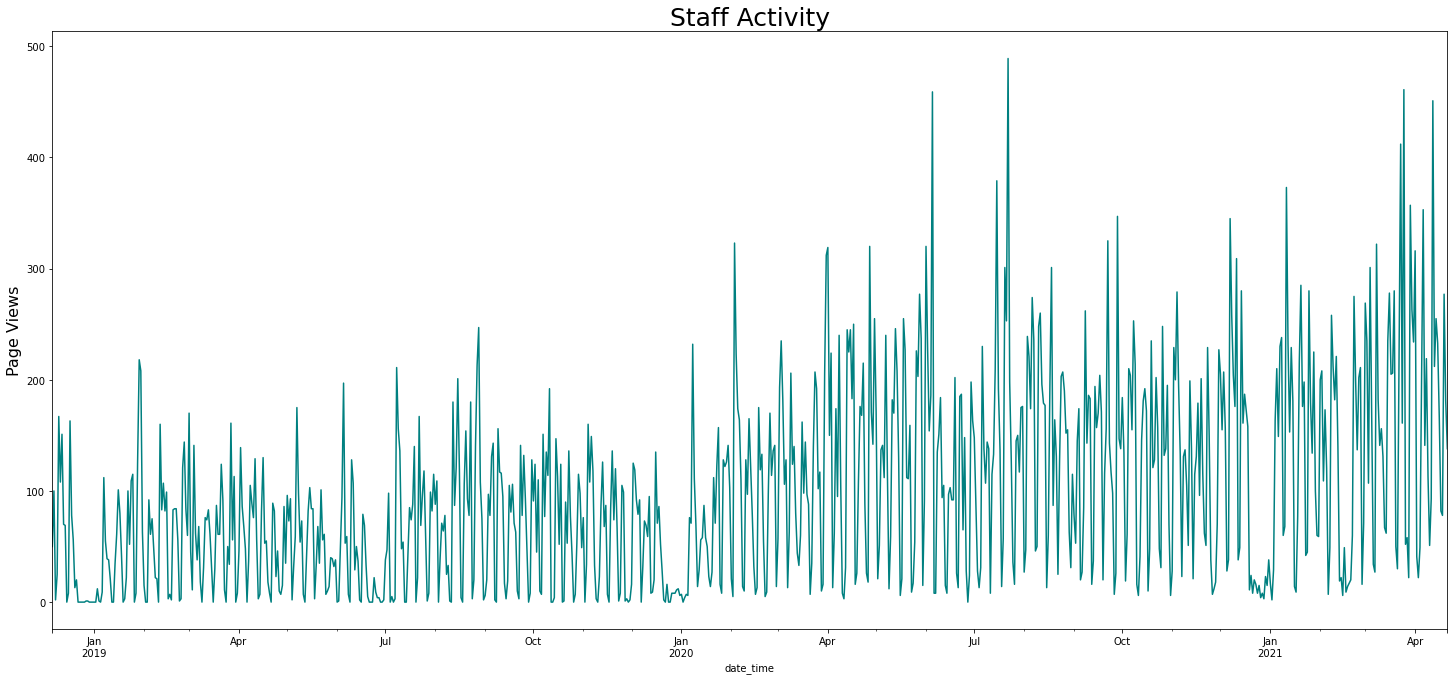

In [26]:
# assign variable to dataframe consisting of staff users only
staff = af[af.staff == True]

# resample staff activity by day
staff_acts = staff.path.resample('D').count()

# create figure
plt.figure(figsize = (25, 11))

# plot staff activity
staff_acts.plot(color = 'teal')

# include clarity
plt.title('Staff Activity', size = 25)
plt.ylabel('Page Views', size = 16);

## Exercise III 
Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.

In [27]:
# pull up all unique user ids that have a record of not being staff at least at one point in time 
# and have accessed the curriculum past their 'end date'
af[(af.index > af.end_date) & (af.name != 'Staff')].user_id.unique()

array([  1,  11,  21,  26,  37,  40,  50,  51,  53,  60,  64,  66,  67,
        68,  69,  70,  71,  72,  75,  76,  77,  80,  81,  82,  83,  84,
        85,  87,  90,  91,  92,  93,  94,  95,  96,  97,  98,  42, 101,
        47, 102,  16,  41,  17,  22,  15, 104,  57,  10, 105, 106,  28,
       107,  65,  52,  33,  56, 108,  27,  38,  36, 109, 110, 112, 113,
       114, 115, 139, 140, 141, 143, 144, 146, 147, 148, 149, 150, 151,
       152, 153, 156, 161, 162, 163, 164, 165, 167, 168, 169, 170, 172,
       173, 174, 175, 177, 178, 179,  18,   6,  29,  19, 180,  99,  43,
        31,   7, 181, 138,  35, 142,   5, 155, 154,  88, 209, 210,   3,
        20, 118, 211, 212, 214, 216, 217, 130, 135, 131, 128, 127, 124,
       159,  12, 145, 241, 242, 136, 157, 171, 123,  25, 134, 119, 243,
       244, 245, 246, 160, 248, 252, 254, 255, 120, 257, 279, 280, 281,
        14, 188, 215, 253, 186, 283, 184, 278, 183, 204, 193, 195, 197,
       249, 206, 284, 121, 201, 285, 286, 311, 190, 312, 116, 20

## Exercise IV 
Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2.

In [28]:
### Below Function Credits Go to Adam ###

import datetime as dt


def user_details(df, user):
    user_info = {'cohort': af[af.user_id == user].name.unique(),
                 'program': af[af.user_id == user].program.unique(), 
                 'start_date': af[af.user_id == user].start_date.unique(),
                 'end_date': af[af.user_id == user].end_date.unique()
                }
    user_info = pd.DataFrame(user_info)
    
    return user_info

def user_logs(df, user):
    
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    
    df = df[df.user_id == user]    # assign variable to dataframe for specified user's data
    user_pages = df['path'].resample('D').count()    # resample page views by count per day
    
    return user_pages    # return new dataframe

def active_user_logs(df, user):
    
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    
    df = df[df.user_id == user]    # assign variable to dataframe for specified user's data
    df = df[df.index < df.end_date]    # re assign data to active only
    active_views = df['path'].resample('D').count()    # resample page views by count per day
    
    return active_views    # return new dataframe

def post_grad_logs(df, user):
    
    '''
    This function returns a dataframe consisting of data for only a single defined user
    '''
    
    df = df[df.user_id == user]    # assign variable to dataframe for specified user's data
    df = df[df.index > df.end_date]    # re assign data to post graduation only
    post_grad_views = df['path'].resample('D').count()    # resample page views by count per day
    
    return post_grad_views    # return new dataframe

def plot_activity(df, user):
    
    df = df[df.user_id == user]    # assign variable to dataframe for specified user's data 
    user_pages = df['path'].resample('D').count()    # resample page views by count per day
    plt.figure(figsize = (20, 8))    # set figure
    plt.ylabel('Page Views', size = 13)    # label y-axis
    plt.title(f'User {user} Activity', size = 16)    # set title
    user_pages.plot(color = 'indigo', label = f'User {user} Activity')    # plot activity

def plot_user_activity(df, user):
    
    user_info = user_details(df, user)    # get user info
    s_year = user_info.start_date[0].year    # get user start date info formatted for vertical line plot
    s_month = user_info.start_date[0].month
    s_day = user_info.start_date[0].day
    e_year = user_info.end_date[0].year    # get user end date info for vertical line plot
    e_month = user_info.end_date[0].month
    e_day = user_info.end_date[0].day
    
    df = df[df.user_id == user]    # assign variable to dataframe for specified user's data 
    user_pages = df['path'].resample('D').count()    # resample page views by count per day
    plt.figure(figsize = (20, 8))    # set figure
    plt.ylabel('Page Views', size = 13)    # label y-axis
    plt.title(f'User {user} Activity', size = 16)    # set title
    user_pages.plot(color = 'indigo', label = f'User {user} Activity')    # plot activity
    
    # plot start and end dates
    plt.axvline(dt.datetime(s_year, s_month, s_day), label = 'Start Date', color = 'darkorange')
    plt.axvline(dt.datetime(e_year, e_month, e_day), label = 'End Date', ls = 'dashdot', color = 'plum')
    plt.legend();    # include legend
    
    
def plot_active_user_activity(df, user):
    
    df = df[df.user_id == user]    # assign variable to dataframe for specified user's data 
    df = df[df.index < df.end_date]    # re assign data to active only
    user_pages = df['path'].resample('D').count()    # resample page views by count per day
    plt.figure(figsize = (20, 8))    # set figure
    plt.ylabel('Page Views', size = 13)    # label y-axis
    plt.title(f'User {user} Activity', size = 16)    # set title
    user_pages.plot(color = 'indigo');    # plot activity
    
def plot_post_grad_activity(df, user):
    
    df = df[df.user_id == user]    # assign variable to dataframe for specified user's data 
    df = df[df.index > df.end_date]    # re assign data to post-graduation only
    user_pages = df['path'].resample('D').count()    # resample page views by count per day
    plt.figure(figsize = (20, 8))    # set figure
    plt.ylabel('Page Views', size = 13)    # label y-axis
    plt.title(f'User {user} Activity', size = 16)    # set title
    user_pages.plot(color = 'indigo');    # plot activity


def compute_pct_b(user_pages, span, weight, user):    
    
    '''
    This function adds the %b of a bollinger band range for the page views of a single user's log activity
    '''
    
    # Calculate bollinger bands
    mb = user_pages.ewm(span = span).mean()
    stdev = user_pages.ewm(span = span).std()
    ub = mb + stdev * weight
    lb = mb - stdev * weight
    
    # Combine all data into a single dataframe
    bb = pd.concat([user_pages, lb, mb, ub], axis=1)
    
    # Set columns
    bb.columns = ['user_pages', 'lb', 'mb', 'ub']
    
    # Calculate percent b and relevant user id to dataframe
    bb['pct_b'] = (bb['user_pages'] - bb['lb']) / (bb['ub'] - bb['lb'])
    bb['user_id'] = user
    
    # Return finished frame
    return bb


def plot_bands(bb, user):
    
    '''
    This function plots the bolliger bands of the page views for a single user
    '''
    
    fig, ax = plt.subplots(figsize = (20, 9))    # set figure and axis
    ax.plot(bb.index, bb.user_pages, label = 'Page Views | User: ' + str(user), color = 'plum') # plot activity
    ax.plot(bb.index, bb.mb, label = 'EMA/ Midband', color = 'darkorange')    # plot midband
    ax.plot(bb.index, bb.ub, label = 'Upper Band', color = 'crimson')    # plot upper band
    ax.plot(bb.index, bb.lb, label = 'Lower Band', color = 'navy')    # plot lower band
    ax.legend(loc = 'best')    # include legend
    ax.set_ylabel('Page Views', size = 13)    # label y-axis
    ax.set_title(f'User {user} Activity Relative to Bollinger Bands', size = 16)    # title
    
    
def find_anomalies(df, user, span, weight, plot = False):

    '''
    This function returns the records where a user's daily activity exceeded the upper limit of a bollinger band range
    '''    
    user_pages = user_logs(df, user)    # Reduce dataframe to represent a single user

    bb = compute_pct_b(user_pages, span, weight, user)    # Add bollinger band data to dataframe 
    
    if plot:                     # Plot data if requested (plot = True)
        plot_bands(bb, user)  
        
    return bb[bb.pct_b > 1]    # Return only records that sit outside of bollinger band upper limit

def find_active_anomalies(df, user, span, weight, plot = False):

    '''
    This function returns the records where a user's daily activity exceeded the upper limit of a bollinger band range
    '''    
    active_views = active_user_logs(df, user)    # Reduce dataframe to represent a single user

    bb = compute_pct_b(active_views, span, weight, user)    # Add bollinger band data to dataframe 
    
    if plot:                     # Plot data if requested (plot = True)
        plot_bands(bb, user)  
        
    return bb[bb.pct_b > 1]    # Return only records that sit outside of bollinger band upper limit

In [29]:
# resample paths by day by count
pages = af.path.resample('D').count()

# preview resampled data
pages.head()

date_time
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: path, dtype: int64

### Visualize Exponential Moving Averages

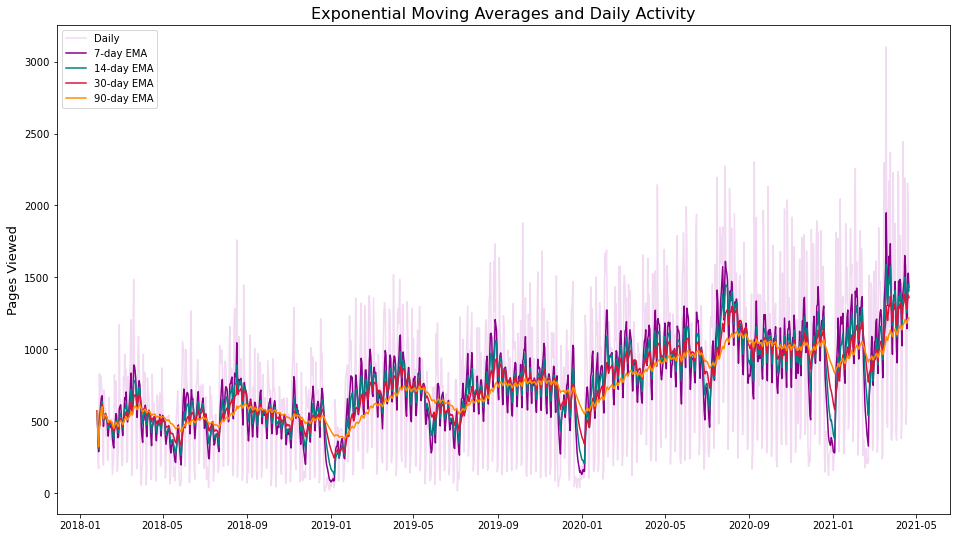

In [30]:
# create 7, 14, 30 and 90 day exponential moving averages
ema_7d = pages.ewm(span = 7).mean()
ema_14d = pages.ewm(span = 14).mean()
ema_30d = pages.ewm(span = 30).mean()
ema_90d = pages.ewm(span = 90).mean()

# plot EMAs
fig, ax = plt.subplots(figsize = (16, 9))    # create figure and axis

ax.plot(pages.index, pages, label = 'Daily', alpha = .38, color = 'plum')    # plot daily activity on to axis
ax.plot(pages.index, ema_7d, label = '7-day EMA', color = 'darkmagenta')    # plot 7-day EMA on axis
ax.plot(pages.index, ema_14d, label = '14-day EMA', color = 'teal')    # plot 14-day EMA on axis
ax.plot(pages.index, ema_30d, label = '30-day EMA', color = 'crimson')    # plot 30-day EMA on axis
ax.plot(pages.index, ema_90d, label = '90-day EMA', color = 'darkorange')    # plot 90-day EMA on axis

ax.legend()    # set legend
ax.set_ylabel('Pages Viewed', size = 13)    # set y-axis label
ax.set_title('Exponential Moving Averages and Daily Activity', size = 16);    # set title

In [31]:
# set window span
span = 30

# compute midband
mb = pages.ewm(span = span).mean()

# preview midband values
mb.head()

date_time
2018-01-26    572.000000
2018-01-27    395.300000
2018-01-28    315.139578
2018-01-29    457.002386
2018-01-30    501.369064
Freq: D, Name: path, dtype: float64

In [32]:
# compute exponential standard deviation
stdev = pages.ewm(span = span).std()

# preview values
stdev.head()

date_time
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: path, dtype: float64

In [33]:
# compute upper and lower bands with K set to 2
ub = mb + stdev * 2
lb = mb - stdev * 2

# preview upper bound
ub.head()

date_time
2018-01-26            NaN
2018-01-27     878.961038
2018-01-28     742.895854
2018-01-29    1089.938060
2018-01-30    1070.328518
Freq: D, Name: path, dtype: float64

In [34]:
# preview lower bound
lb.head()

date_time
2018-01-26           NaN
2018-01-27    -88.361038
2018-01-28   -112.616698
2018-01-29   -175.933288
2018-01-30    -67.590389
Freq: D, Name: path, dtype: float64

In [35]:
# concatenate bollinger band data
bb_data = pd.concat([pages, lb, mb, ub], axis = 1)

# set columns
bb_data.columns = ['pages', 'lb', 'mb', 'ub']

# preview data
bb_data.head()

pages          lb          mb           ub
date_time                                             
2018-01-26    572         NaN  572.000000          NaN
2018-01-27    230  -88.361038  395.300000   878.961038
2018-01-28    170 -112.616698  315.139578   742.895854
2018-01-29    830 -175.933288  457.002386  1089.938060
2018-01-30    652  -67.590389  501.369064  1070.328518

### Visualize Bollinger Bands

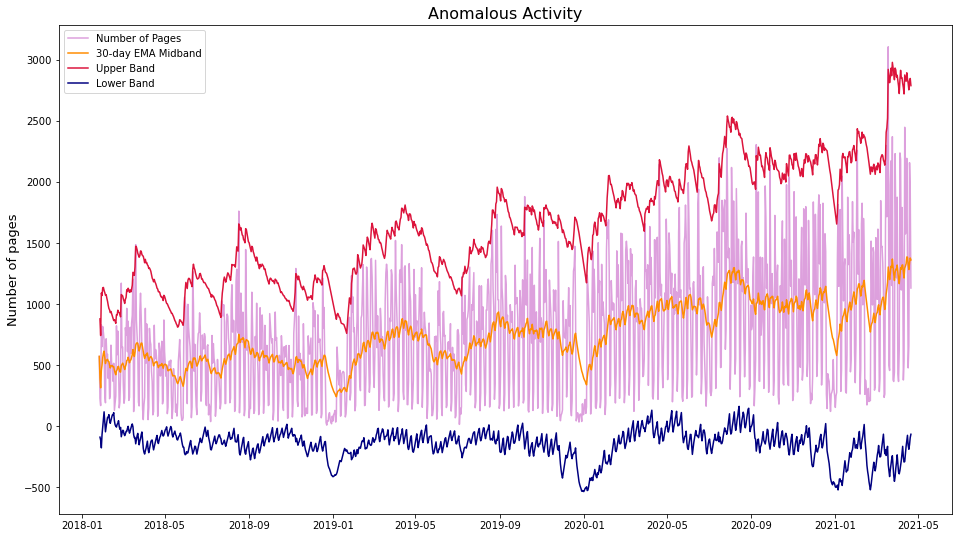

In [36]:
# plot bands
fig, ax = plt.subplots(figsize = (16, 9))    # set figure and axis

ax.plot(bb_data.index, bb_data.pages, label = 'Number of Pages', color = 'plum')    # plot page views on axis
ax.plot(bb_data.index, bb_data.mb, label = '30-day EMA Midband', color = 'darkorange') # plot midband on axis
ax.plot(bb_data.index, bb_data.ub, label = 'Upper Band', color = 'crimson')    # plot upper band on axis
ax.plot(bb_data.index, bb_data.lb, label = 'Lower Band', color = 'navy')    # plot lower band on axis

ax.legend(loc = 'best')    # include legend
ax.set_ylabel('Number of pages', size = 13)    # label y-axis
ax.set_title('Anomalous Activity', size = 16);    # title

In [37]:
# compute %b
bb_data['pct_b'] = (bb_data['pages'] - bb_data['lb']) / (bb_data['ub'] - bb_data['lb'])

# preview dataframe
bb_data.head()

pages          lb          mb           ub     pct_b
date_time                                                       
2018-01-26    572         NaN  572.000000          NaN       NaN
2018-01-27    230  -88.361038  395.300000   878.961038  0.329116
2018-01-28    170 -112.616698  315.139578   742.895854  0.330348
2018-01-29    830 -175.933288  457.002386  1089.938060  0.794657
2018-01-30    652  -67.590389  501.369064  1070.328518  0.632374

In [38]:
# view records where overall user activity is suspicious
bb_data[bb_data.pct_b > 1]

pages          lb           mb           ub     pct_b
date_time                                                        
2018-02-27   1171  -85.155652   496.375166  1077.905985  1.080042
2018-03-20   1486 -142.875035   665.021495  1472.918024  1.008096
2018-05-30   1056 -217.939741   400.137163  1018.214066  1.030567
2018-07-23   1027 -139.375411   435.495343  1010.366096  1.014468
2018-08-17   1760 -151.691251   751.910516  1655.512283  1.057817
2018-11-08   1291 -126.001309   561.449002  1248.899313  1.030621
2019-01-28   1232 -272.918675   447.643274  1168.205223  1.044267
2019-07-08   1225 -256.993715   479.213223  1215.420161  1.006506
2019-10-07   1879 -184.835797   803.738383  1792.312562  1.043845
2020-07-16   2196 -126.979325  1010.532255  2148.043834  1.021079
2020-09-08   2304 -202.661156  1005.605271  2213.871699  1.037297
2021-03-19   3104 -312.832914  1303.128816  2919.090546  1.057213

Dates that hold suspicious activity:
* 2018
    * february 27
    * march 30
    * may 30
    * july 23
    * august 17
    * november 8
* 2019
    * january 28
    * july 8
    * october 7
* 2020
    * july 16
    * september 8
* 2021
    * march 19

In [39]:
# assign variable to dataframe of all user activity on first suspicious date
sus1 = af['2018-02-27']
sus1

path  user_id  \
date_time                                                              
2018-02-27 00:04:11       java-i/syntax-types-and-variables        4   
2018-02-27 00:09:51       slides/syntax_types_and_variables        4   
2018-02-27 00:15:28                       java-i/console-io        4   
2018-02-27 00:15:32                       slides/console_io        4   
2018-02-27 00:17:42                       slides/console_io        4   
...                                                     ...      ...   
2018-02-27 23:23:46   html-css/css-ii/bootstrap-grid-system       22   
2018-02-27 23:23:58  html-css/css-ii/bootstrap-introduction       22   
2018-02-27 23:47:56                          slides/methods       52   
2018-02-27 23:59:10                            javascript-i       12   
2018-02-27 23:59:13                      javascript-i/loops       12   

                     cohort_id              ip     name start_date   end_date  \
date_time                                                                       
2018-02-27 00:04:11       22.0  70.123.231.211    Teddy 2018-01-08 2018-05-17   
2018-02-27 00:09:51       22.0  70.123.231.211    Teddy 2018-01-08 2018-05-17   
2018-02-27 00:15:28       22.0  70.123.231.211    Teddy 2018-01-08 2018-05-17   
2018-02-27 00:15:32       22.0  70.123.231.211    Teddy 2018-01-08 2018-05-17   
2018-02-27 00:17:42       22.0  70.123.231.211    Teddy 2018-01-08 2018-05-17   
...                        ...             ...      ...        ...        ...   
2018-02-27 23:23:46       21.0   107.204.132.6  Sequoia 2017-09-27 2018-02-15   
2018-02-27 23:23:58       21.0   107.204.132.6  Sequoia 2017-09-27 2018-02-15   
2018-02-27 23:47:56       21.0   99.203.26.234  Sequoia 2017-09-27 2018-02-15   
2018-02-27 23:59:10       22.0  76.185.247.126    Teddy 2018-01-08 2018-05-17   
2018-02-27 23:59:13       22.0  76.185.247.126    Teddy 2018-01-08 2018-05-17   

                             created_at          updated_at  program_id  \
date_time                                                                 
2018-02-27 00:04:11 2018-01-08 13:59:10 2018-01-08 13:59:10         2.0   
2018-02-27 00:09:51 2018-01-08 13:59:10 2018-01-08 13:59:10         2.0   
2018-02-27 00:15:28 2018-01-08 13:59:10 2018-01-08 13:59:10         2.0   
2018-02-27 00:15:32 2018-01-08 13:59:10 2018-01-08 13:59:10         2.0   
2018-02-27 00:17:42 2018-01-08 13:59:10 2018-01-08 13:59:10         2.0   
...                                 ...                 ...         ...   
2018-02-27 23:23:46 2017-09-27 20:22:41 2017-09-27 20:22:41         2.0   
2018-02-27 23:23:58 2017-09-27 20:22:41 2017-09-27 20:22:41         2.0   
2018-02-27 23:47:56 2017-09-27 20:22:41 2017-09-27 20:22:41         2.0   
2018-02-27 23:59:10 2018-01-08 13:59:10 2018-01-08 13:59:10         2.0   
2018-02-27 23:59:13 2018-01-08 13:59:10 2018-01-08 13:59:10         2.0   

                     front_end  data_science  java  php          program  \
date_time                                                                  
2018-02-27 00:04:11          0             0     1    0  Full-Stack Java   
2018-02-27 00:09:51          0             0     1    0  Full-Stack Java   
2018-02-27 00:15:28          0             0     1    0  Full-Stack Java   
2018-02-27 00:15:32          0             0     1    0  Full-Stack Java   
2018-02-27 00:17:42          0             0     1    0  Full-Stack Java   
...                        ...           ...   ...  ...              ...   
2018-02-27 23:23:46          0             0     1    0  Full-Stack Java   
2018-02-27 23:23:58          0             0     1    0  Full-Stack Java   
2018-02-27 23:47:56          0             0     1    0  Full-Stack Java   
2018-02-27 23:59:10          0             0     1    0  Full-Stack Java   
2018-02-27 23:59:13          0             0     1    0  Full-Stack Java   

                     staff  
date_time                   
2018-02-27 00:04:11  False  
2018-02-27 0

In [40]:
# view user ids who accessed the curriculum today
sus1.user_id.value_counts()

23     90
30     68
7      59
34     52
39     50
53     45
6      43
44     42
3      40
5      40
31     36
10     35
19     35
18     34
8      34
2      31
99     28
29     27
14     26
1      25
25     24
9      24
32     24
20     24
26     21
43     21
11     21
4      21
36     18
22     17
74     15
109    14
35     13
12     13
40     11
67     11
28      9
16      8
52      4
64      4
105     4
60      3
15      3
56      2
65      2
Name: user_id, dtype: int64

User 23 has 90 views this day. Let's plot user 23's overall activity.

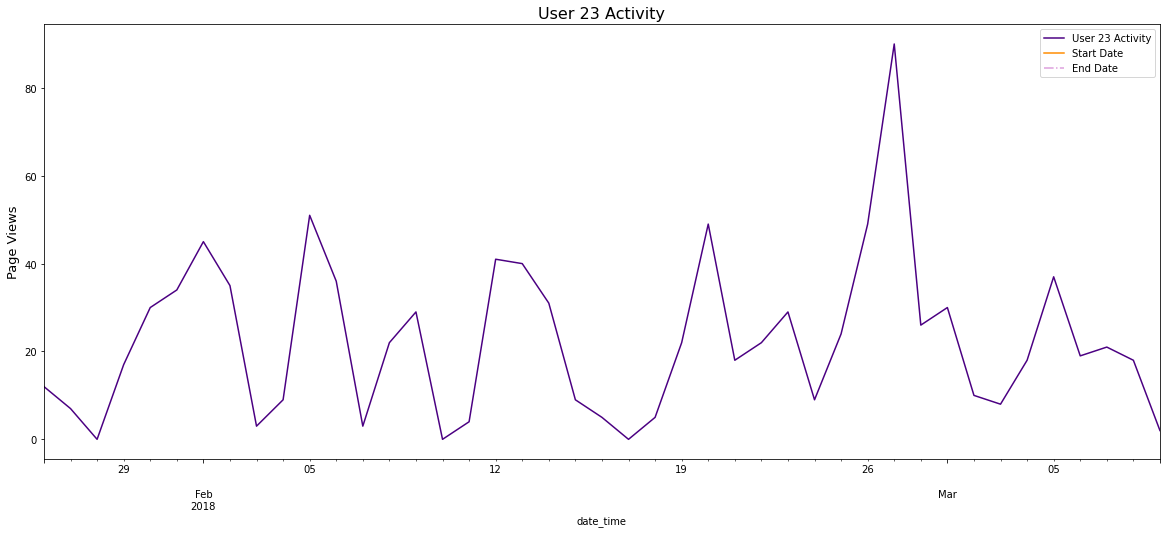

In [41]:
# plot user 23's activity
plot_user_activity(af, 23)

user_pages         lb         mb         ub     pct_b  user_id
date_time                                                                 
2018-02-27          90 -19.812401  27.620995  75.054391  1.157543       23

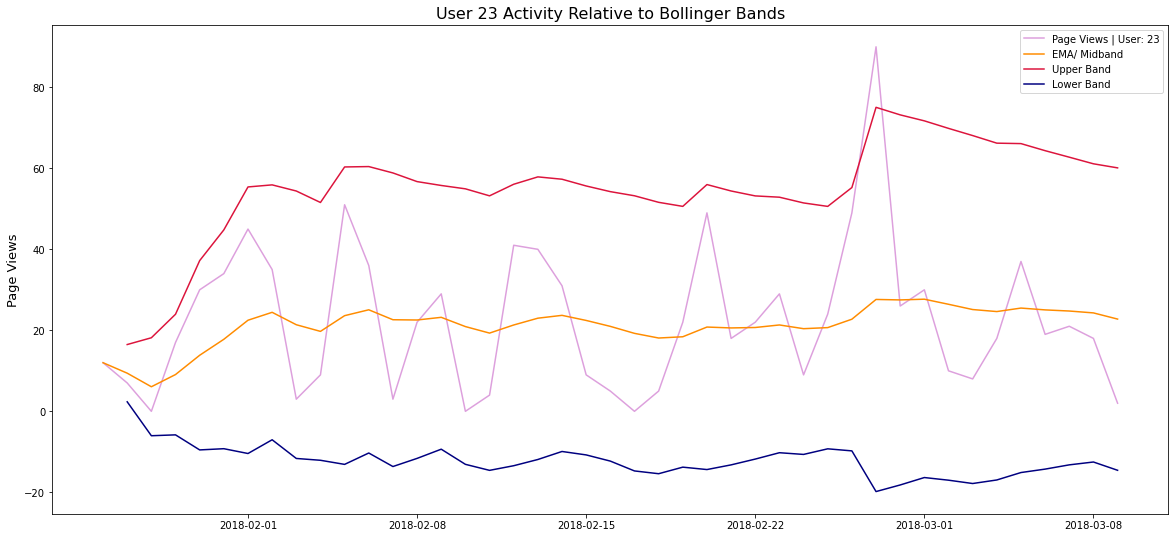

In [42]:
# pull up anomalous data
find_anomalies(af, 23, 30, 2, True)

While 90 page views is outside the normal range of user 23's activity, it is not hard for me to imagine some sort of crackdown on studying on the 27th of February, or some frantic switching back between pages in the curriculum one day. I think this anomalous activity can be construed as normal activity. Or maybe user 23 was copying and pasting pages manually...what program is user 23 in? Why did user 23's activity stop around the beginning of March if user 23 began accessing the curriculum in late January? Oh. Moving on from user 23.

In [43]:
# pull up details for user 23
def user_details(df, user):
    user_info = {'cohort': af[af.user_id == user].name.unique(),
                 'program': af[af.user_id == user].program.unique(), 
                 'start_date': af[af.user_id == user].start_date.unique(),
                 'end_date': af[af.user_id == user].end_date.unique()
                }
    user_info = pd.DataFrame(user_info)
    
    return user_info

In [44]:
# access details for user 23
user23_info = user_details(af, 23)
user23_info

cohort          program start_date   end_date
0  Teddy  Full-Stack Java 2018-01-08 2018-05-17

In [45]:
# pull up activity for march 30
sus2 = af['2018-03-30']

# pull up user ids who were active this day
sus2.user_id.value_counts()

53     25
135    24
164    16
153    16
61     12
35      8
48      6
18      6
145     6
110     5
157     5
155     4
40      3
27      2
51      2
60      2
3       1
165     1
Name: user_id, dtype: int64

User 53 has the most activity for this day. 25 page views? Ain't worried about a thing.

In [46]:
# assign variables to plot activity data on suspicous days
sus3 = af['2018-05-30']
sus4 = af['2018-07-23']
sus5 = af['2018-08-17']
sus6 = af['2018-11-08']
sus7 = af['2019-01-28']
sus8 = af['2019-07-08']
sus9 = af['2019-10-07']
sus10 = af['2020-07-16']
sus11= af['2020-09-08']
sus12= af['2021-03-19']

# set parameters for further investigation
span = 30
weight = k = 2

In [47]:
# pull up user id counts of page views (top 10)
sus3.user_id.value_counts().nlargest(10)

118    65
25     59
171    46
134    45
135    45
127    38
122    35
11     34
203    33
128    31
Name: user_id, dtype: int64

In [48]:
user118_info = user_details(af, 118)
user118_info

cohort          program start_date   end_date
0  Ulysses  Full-Stack Java 2018-03-05 2018-07-19
1    Kings   Full-Stack PHP 2016-05-23 2016-09-15

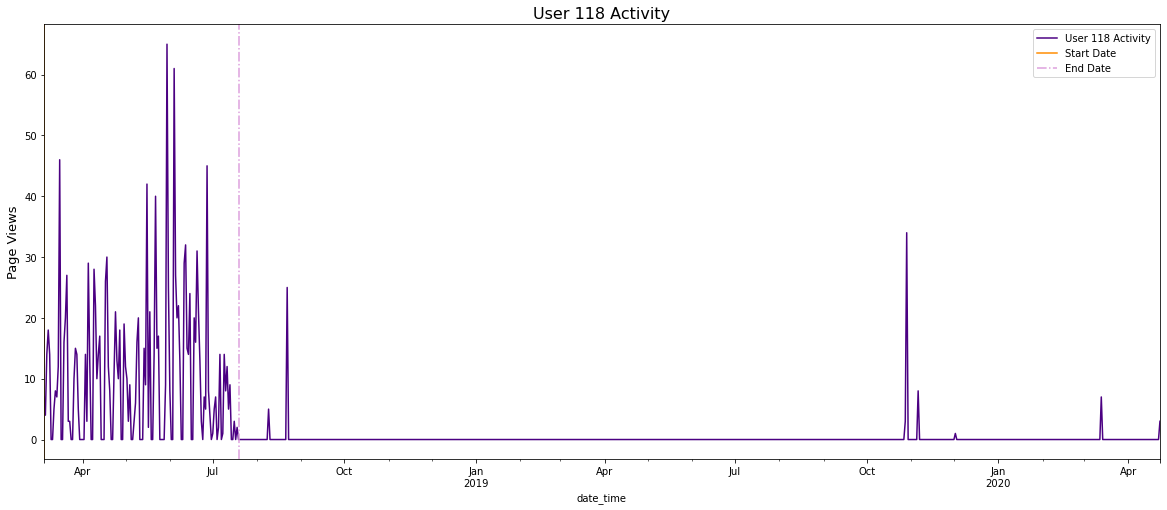

In [49]:
# plot user 118's activity
plot_user_activity(af, 118)

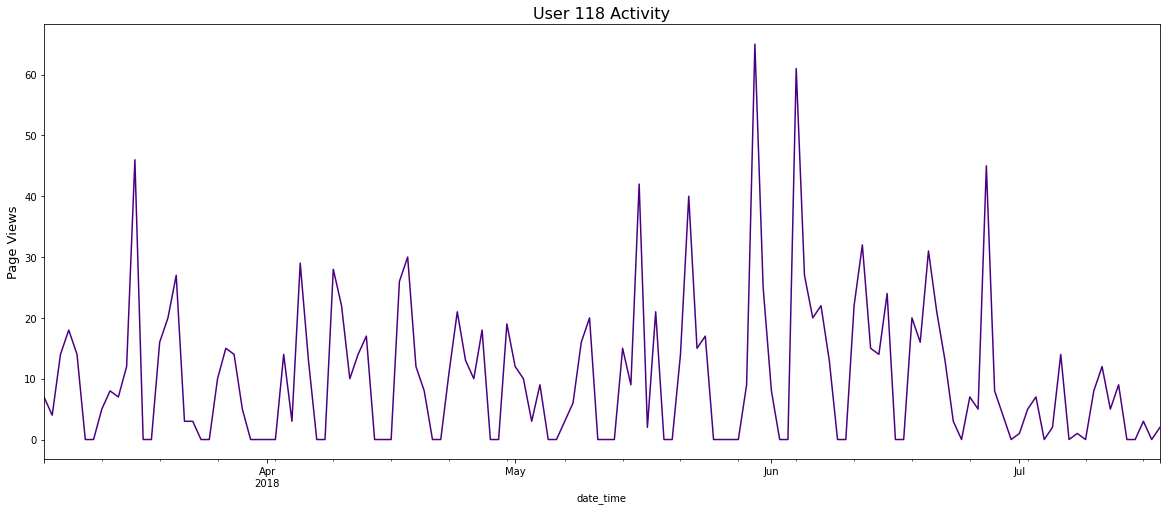

In [50]:
# plot user 118's activity while active
plot_active_user_activity(af, 118)

Seems ok.

user_pages         lb         mb         ub     pct_b  user_id
date_time                                                                 
2018-03-16          46 -15.294771  12.434797  40.164365  1.105224      118
2018-05-16          42 -12.818512  10.381803  33.582118  1.181417      118
2018-05-22          40 -14.535709  11.519609  37.574927  1.046537      118
2018-05-30          65 -22.909904  12.839155  48.588214  1.229542      118
2018-06-04          61 -25.637521  14.796025  55.229571  1.071357      118

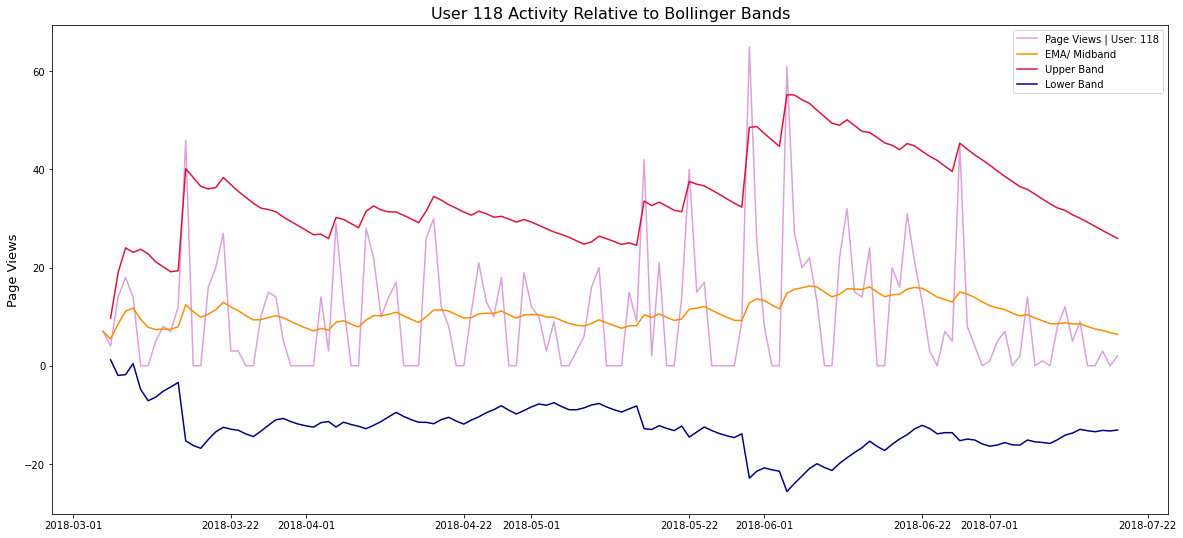

In [51]:
# view user 118 activity
find_active_anomalies(af, 118, span, k, True)

Looks like extra studying to me.

In [52]:
# bring up users' page views on this day
sus4.user_id.value_counts()

191    44
194    41
190    40
215    40
208    39
       ..
1       2
61      1
51      1
50      1
130     1
Name: user_id, Length: 64, dtype: int64

I'm over it.

In [53]:
# bring up users' page views on this day
sus5.user_id.value_counts()

192    97
235    81
227    65
230    61
53     59
       ..
11      3
41      2
128     1
50      1
243     1
Name: user_id, Length: 61, dtype: int64

Let's look at user 192.

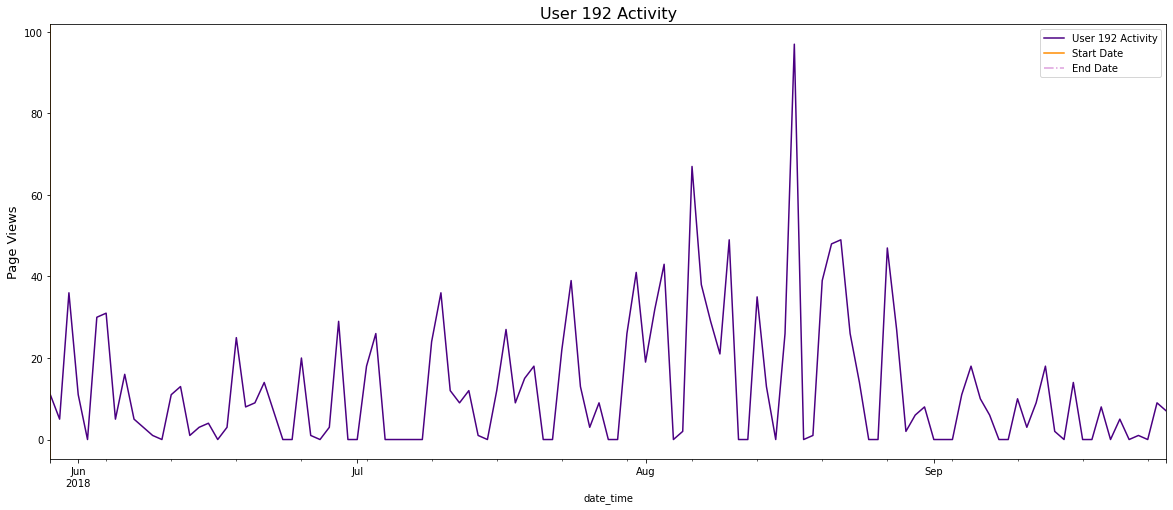

In [54]:
plot_user_activity(af, 192)

In [55]:
# pull up details for user 192
user192_info = user_details(af, 192)
user192_info

cohort          program start_date   end_date
0  Voyageurs  Full-Stack Java 2018-05-29 2018-10-11

user_pages         lb         mb         ub     pct_b  user_id
date_time                                                                 
2018-07-10          36 -15.282782   9.783257  34.849295  1.022953      192
2018-07-24          39 -12.766380  12.254086  37.274551  1.034481      192
2018-07-31          41 -14.259296  13.054116  40.367527  1.011578      192
2018-08-06          67 -21.174843  17.969049  57.112941  1.126291      192
2018-08-17          97 -28.694090  23.960215  76.614521  1.193578      192

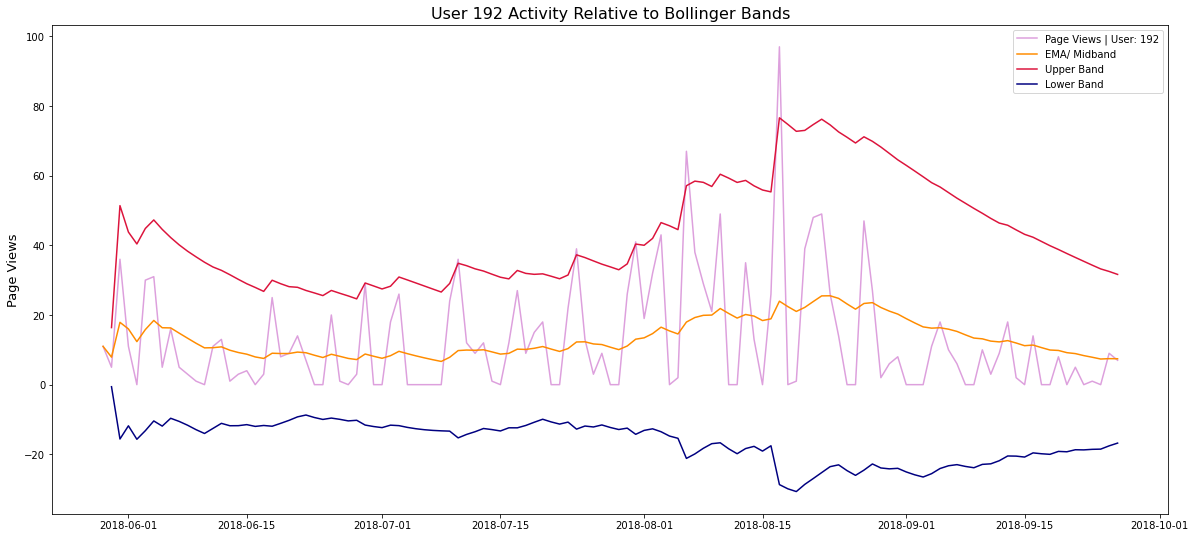

In [56]:
# find 'anomalous' data for user 192
find_anomalies(af, 192, span, k, True)

I'm ok.

In [57]:
# bring up users' page views on this day
sus6.user_id.value_counts()

274    108
302     70
264     61
256     60
275     54
      ... 
50       2
235      1
231      1
227      1
127      1
Name: user_id, Length: 67, dtype: int64

Let's look at user 274.

In [58]:
# pull up details for user 274
user274_info = user_details(af, 274)
user274_info

cohort          program start_date   end_date
0  Xanadu  Full-Stack Java 2018-09-17 2019-02-08

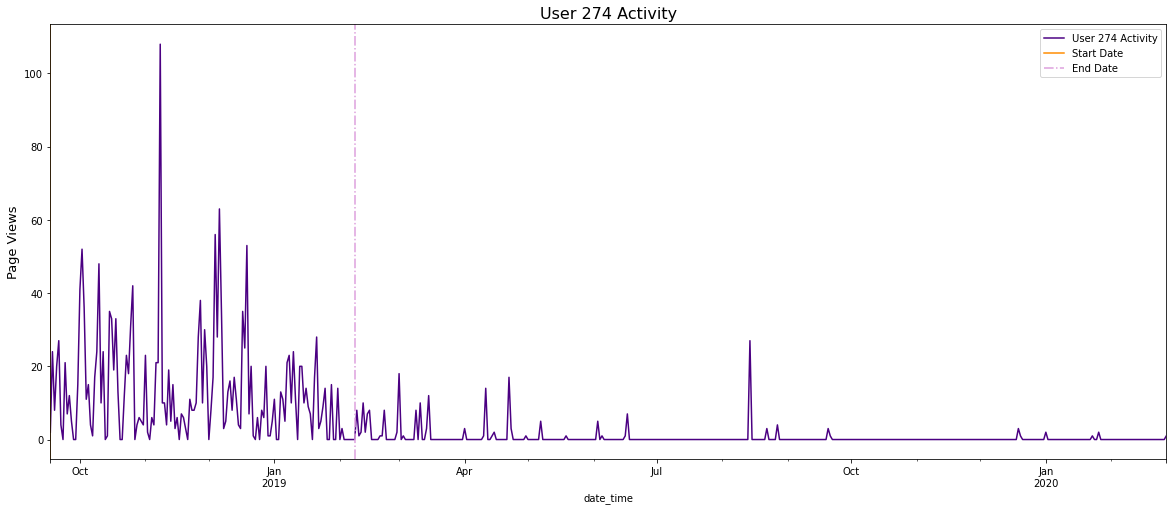

In [59]:
plot_user_activity(af, 274)

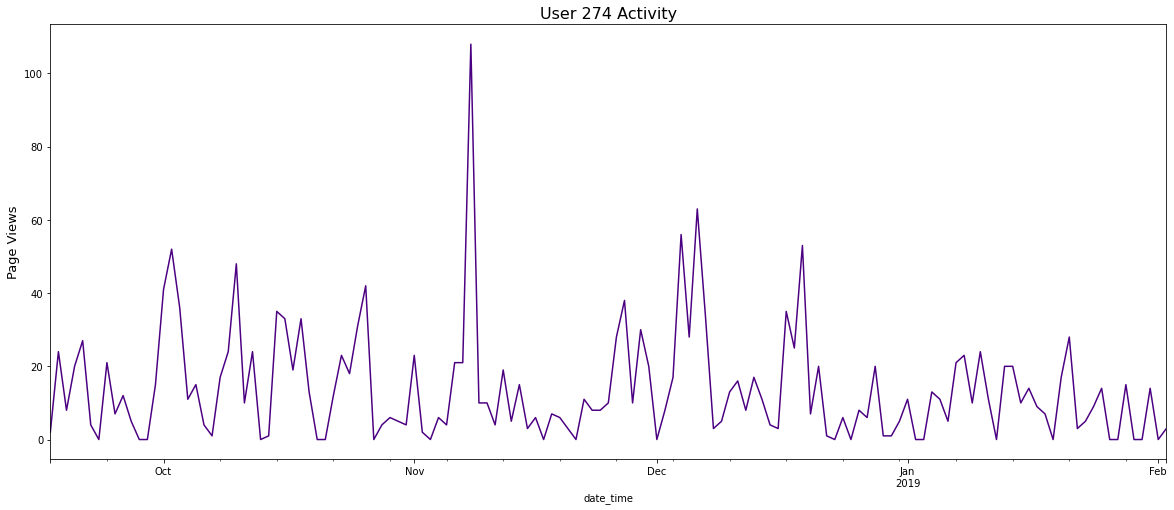

In [60]:
plot_active_user_activity(af, 274)

user_pages         lb         mb         ub     pct_b  user_id
date_time                                                                 
2018-10-01          41 -13.437210  12.799923  39.037056  1.037408      274
2018-10-02          52 -18.031358  16.655267  51.341892  1.009486      274
2018-11-08         108 -34.226023  19.732229  73.690481  1.317927      274
2018-12-04          56 -19.645178  16.617916  52.881011  1.043005      274
2018-12-06          63 -20.954433  20.313921  61.582274  1.017177      274

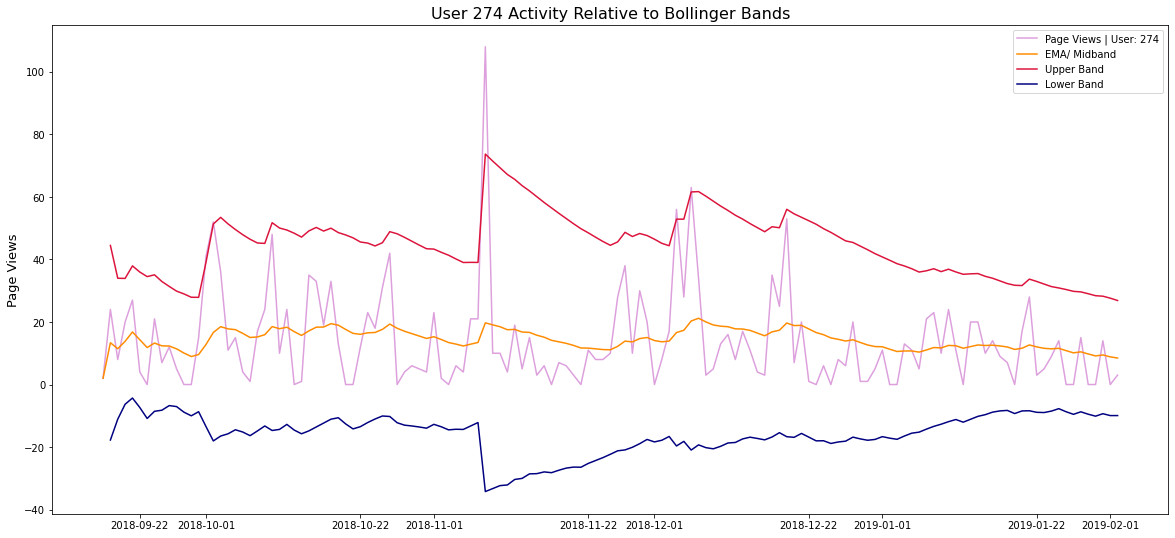

In [61]:
# find 'anomalous' data for user 274
find_active_anomalies(af, 274, span, k, True)

Aside from the November studies, everything else looks ok. A lot of students seem to do a lot of extra studying at one point in time or scrape a bit of the dataframe.

In [62]:
# bring up users' page views on this day
sus7.user_id.value_counts()

304    120
272     66
325     56
344     55
11      49
      ... 
309      3
273      3
263      2
264      2
271      1
Name: user_id, Length: 63, dtype: int64

User 304.

In [63]:
user304_info = user_details(af, 304)
user304_info

cohort          program start_date   end_date
0  Yosemite  Full-Stack Java 2018-11-05 2019-04-03

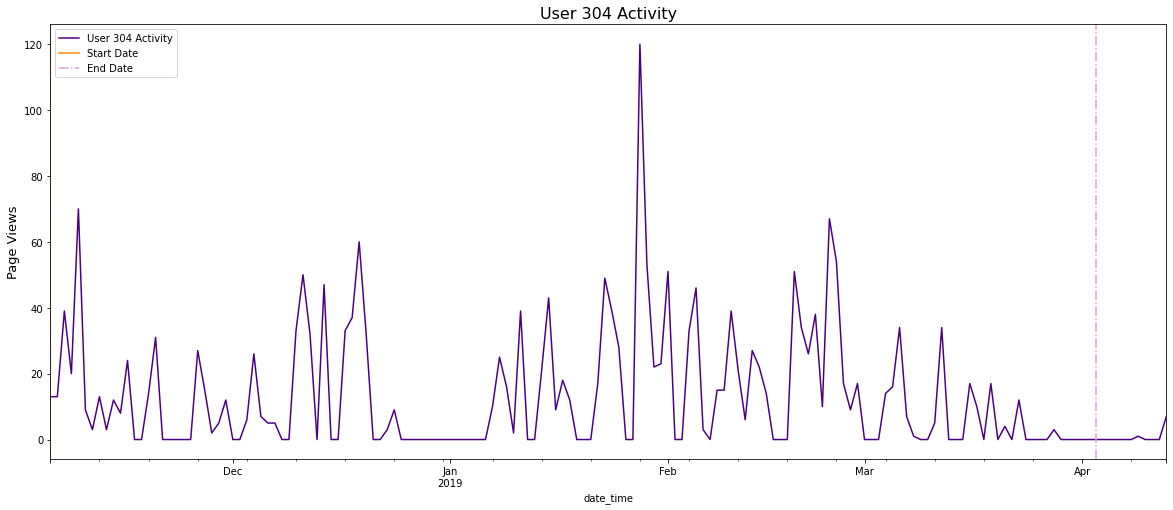

In [64]:
plot_user_activity(af, 304)

user_pages         lb         mb         ub     pct_b  user_id
date_time                                                                 
2018-12-11          50 -19.738123  12.486136  44.710395  1.082075      304
2019-01-23          49 -20.448891  12.795913  46.040717  1.044507      304
2019-01-28         120 -42.153173  20.341395  82.835963  1.297338      304

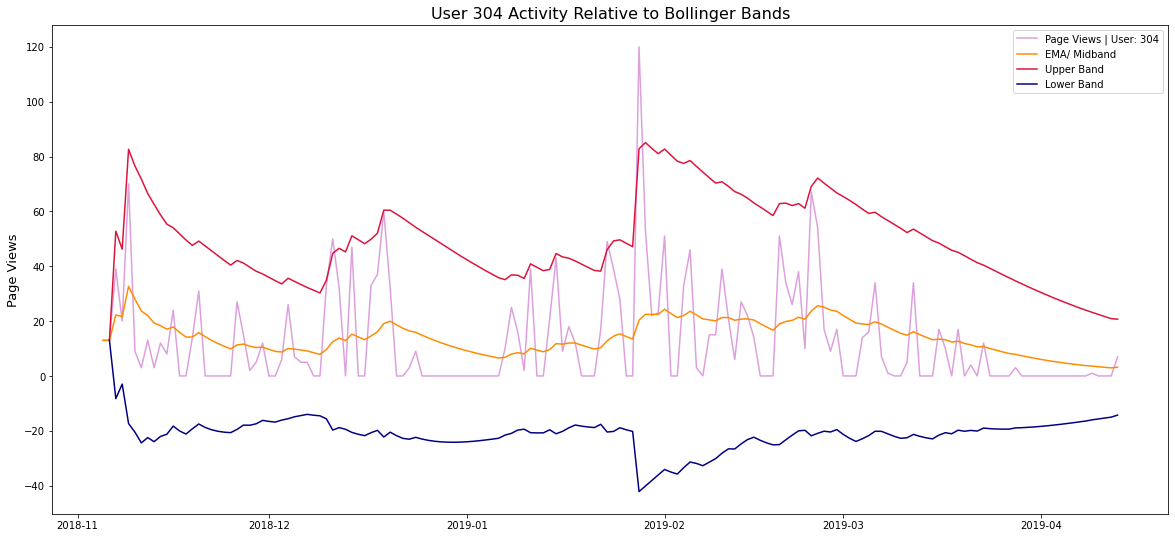

In [65]:
find_anomalies(af, 304, span, k, True)

Ok, maybe there is some lesson in which web scraping is required from the codeup server. Or maybe there is some urgent need for studying within 3 months of starting...no. Then we would see more users from each cohort. Maybe there is something learned that only some students apply, or these students all decided they needed extra studying. All students reviewed so far were in the Full-Stack Java progam.

In [66]:
# bring up users' page views on this day
sus8.user_id.value_counts()

418    104
1      101
314     68
423     65
413     62
422     52
416     48
375     41
407     40
404     40
428     36
410     36
408     35
420     34
376     32
424     29
11      25
380     22
393     22
431     22
262     20
417     20
385     19
412     18
390     17
414     16
426     15
384     15
377     13
415     12
293     11
409     11
389     10
425     10
430     10
302      9
248      9
41       8
382      7
315      7
366      6
419      6
387      5
383      5
361      4
421      4
392      4
373      4
379      3
395      3
381      2
411      2
290      1
354      1
362      1
51       1
394      1
367      1
Name: user_id, dtype: int64

User 418 and Player 1 got something going on.

In [67]:
# pull up user info
user418_info = user_details(af, 418)
user418_info

cohort          program start_date   end_date
0  Betelgeuse  Full-Stack Java 2019-05-28 2019-10-08

In [68]:
# pull up user info
user1_info = user_details(af, 1)
user1_info

cohort          program start_date   end_date
0  Hampton   Full-Stack PHP 2015-09-22 2016-02-06
1    Staff  Full-Stack Java 2014-02-04 2014-02-04

In [69]:
user1_info.start_date[0].year

2015

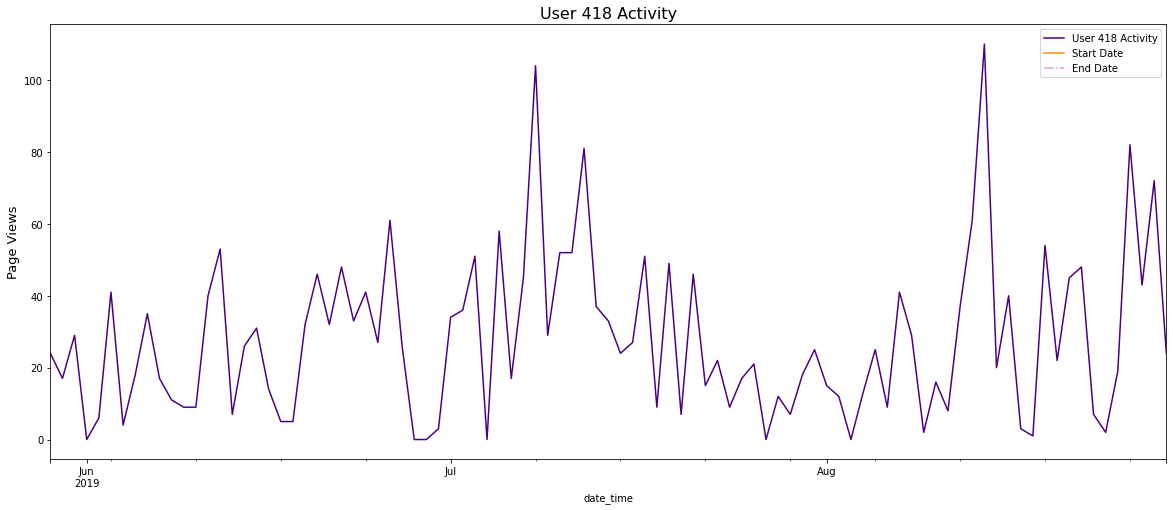

In [70]:
plot_user_activity(af, 418)

user_pages         lb         mb         ub     pct_b  user_id
date_time                                                                 
2019-07-08         104 -21.800798  33.047814  87.896427  1.146800      418
2019-08-14         110 -27.695168  29.373334  86.441836  1.206403      418

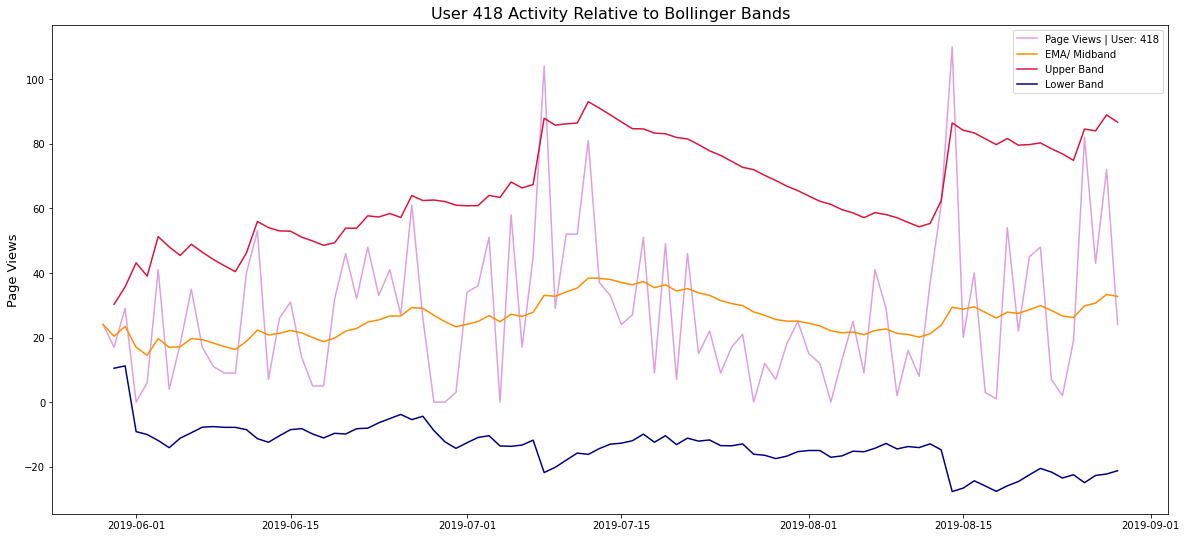

In [71]:
find_anomalies(af, 418, span, k, True)

I don't see anything unusual here. This pretty much matches other students' behavior, except that there were two spikes instead of one. User 481 was, like the users studied prior, also in the Java program. Let's look at user 1...

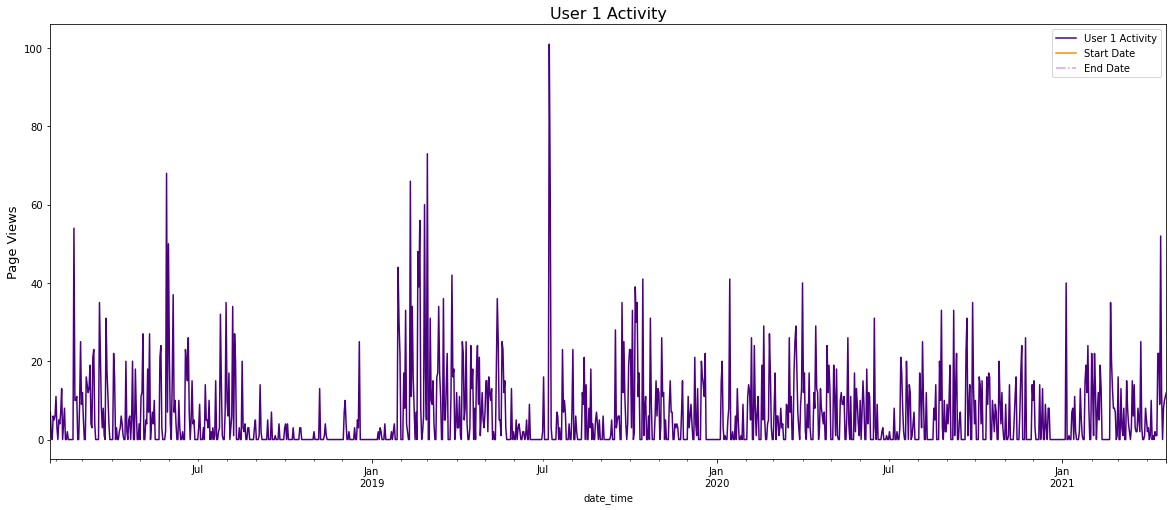

In [72]:
plot_user_activity(af, 1)

#### This is all of User 1's activity as a staff member. 
I don't see anything unusual. Not that I know what usual looks like for a staff member.

In [73]:
user1_pages = user_logs(af, 1)
user1_pages

date_time
2018-01-26     7
2018-01-27     1
2018-01-28     0
2018-01-29     6
2018-01-30     5
              ..
2021-04-17     0
2021-04-18     8
2021-04-19    10
2021-04-20    11
2021-04-21    12
Freq: D, Name: path, Length: 1182, dtype: int64

In [74]:
user1_pages.describe()

count    1182.000000
mean        6.263959
std        10.104352
min         0.000000
25%         0.000000
50%         2.000000
75%         9.000000
max       101.000000
Name: path, dtype: float64

user_pages         lb         mb         ub     pct_b  user_id
date_time                                                                 
2018-02-20          54 -22.804758   6.456745  35.718248  1.312386        1
2018-03-19          35 -13.760453   9.304089  32.368632  1.057044        1
2018-05-04          27 -10.377545   7.179313  24.736171  1.064471        1
2018-05-11          27 -10.405390   8.141119  26.687629  1.008421        1
2018-05-29          68 -25.562347   9.612443  44.787234  1.329963        1
2018-07-25          32 -13.053359   5.833712  24.720784  1.192704        1
2018-07-31          35 -14.864871   7.286941  29.438752  1.125526        1
2018-08-07          34 -14.077468   8.843526  31.764520  1.048765        1
2018-11-07          13  -5.647265   1.221442   8.090149  1.357407        1
2018-12-03           7  -3.847926   0.769359   5.386644  1.174708        1
2018-12-04          10  -5.055622   1.364884   7.785390  1.172464        1
2018-12-19          25  -9.868070   2.880262  15.628594  1.367554        1
2019-01-29          44 -18.352672   3.623334  25.599340  1.418653        1
2019-02-11          66 -27.234859  10.193775  47.622409  1.245502        1
2019-03-01          73 -29.396331  19.779325  68.954982  1.041128        1
2019-05-14          36 -10.511742  10.499032  31.509806  1.106855        1
2019-07-02          16  -8.561190   2.585177  13.731544  1.101758        1
2019-07-08         101 -42.184777   8.248768  58.682313  1.419539        1
2019-09-16          28 -12.508749   3.758497  20.025742  1.245102        1
2019-09-23          35 -14.953096   5.588763  26.130623  1.215885        1
2019-10-07          39 -15.414697  11.225628  37.865953  1.021284        1
2019-12-09          21  -8.829231   5.260044  19.349319  1.058579        1
2020-01-07          20 -10.714122   4.571746  19.857613  1.004657        1
2020-01-15          41 -16.055242   6.259332  28.573906  1.278430        1
2020-02-07          26 -11.205748   6.233135  23.672018  1.066747        1
2020-02-20          29 -11.777590   7.739336  27.256262  1.044672        1
2020-03-18          26  -9.721675   6.630055  22.981784  1.092290        1
2020-04-01          40 -12.236740  10.959220  34.155180  1.125988        1
2020-05-19          26  -8.343354   8.315975  24.975304  1.030754        1
2020-06-16          31 -10.744425   7.293052  25.330528  1.157158        1
2020-07-14          21  -9.796017   3.397094  16.590205  1.167125        1
2020-07-20          20 -10.219158   4.853815  19.926788  1.002429        1
2020-08-06          25  -9.998523   6.210759  22.420041  1.079583        1
2020-08-24          20  -9.651356   4.940871  19.533098  1.015998        1
2020-08-26          33 -12.549642   7.056475  26.662592  1.161618        1
2020-09-08          33 -13.056126   7.550647  28.157421  1.117500        1
2020-09-22          31 -13.972818   7.853728  29.680275  1.030232        1
2020-09-28          35 -14.963679   8.702741  32.369160  1.055582        1
2020-11-19          24  -9.301091   6.764385  22.829861  1.036418        1
2020-11-23          26 -11.267360   6.857942  24.983243  1.028048        1
2021-01-05          40 -16.814184   4.050795  24.915774  1.361472        1
2021-02-21          35 -14.245739   6.721225  27.688188  1.174365        1
2021-03-25          25  -8.358614   6.861105  22.080823  1.095901        1
2021-04-12          22  -9.094085   4.806718  18.707521  1.118428        1
2021-04-13          22 -10.039948   5.915962  21.871871  1.004015        1
2021-04-15          52 -18.326101   9.075259  36.476619  1.283259        1

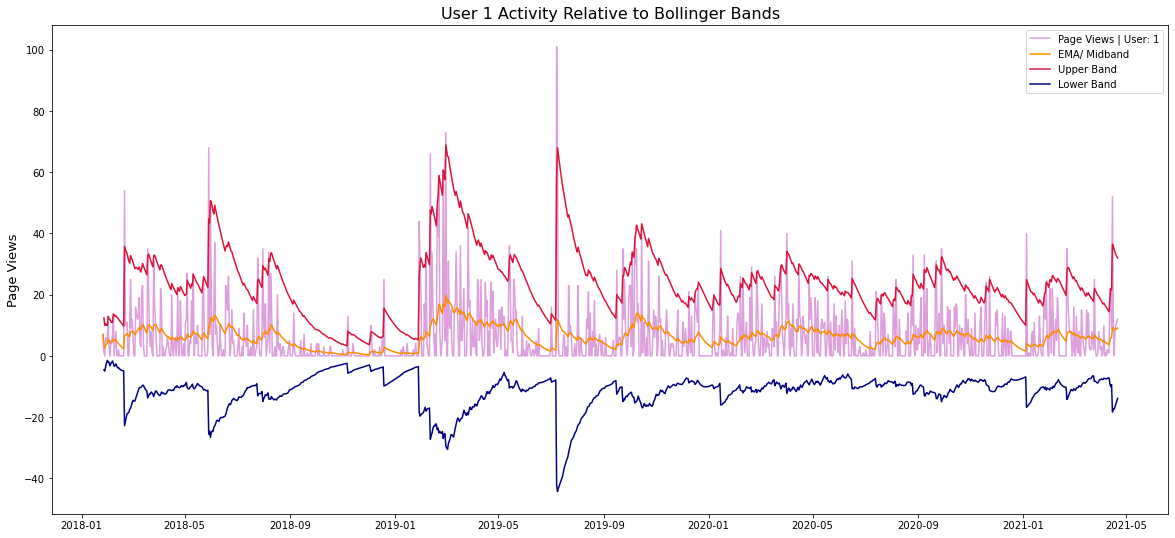

In [75]:
find_anomalies(af, 1, span, k, True)

Looks pretty normal here. Activity is consistently low, and I suspect there would be no anomalies would be detected were the bollinger bands calculated using a 7 day moving average. Wait a second...

Empty DataFrame
Columns: [user_pages, lb, mb, ub, pct_b, user_id]
Index: []

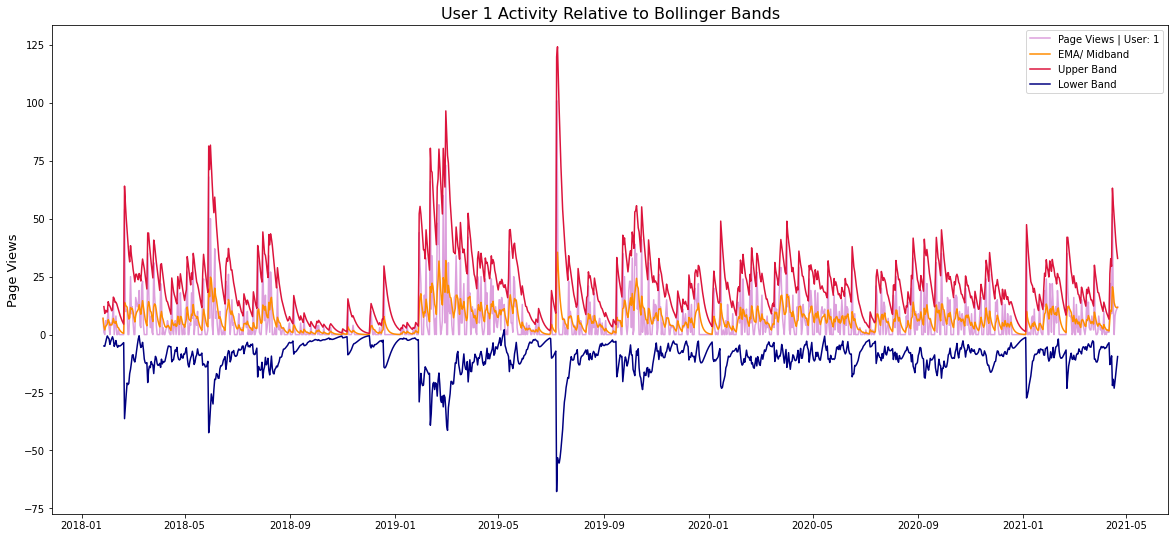

In [76]:
find_anomalies(af, 1, 7, k, True)

Yep no anomalies detected.

In [77]:
# bring up users' page views on this day
sus9.user_id.value_counts()

479    110
438     80
433     75
436     58
11      56
      ... 
497      3
409      2
189      1
416      1
362      1
Name: user_id, Length: 87, dtype: int64

Let's definitely look at user 479.

In [78]:
user479_info = user_details(af, 479)
user479_info

cohort       program start_date   end_date
0  Bayes  Data Science 2019-08-19 2020-01-30

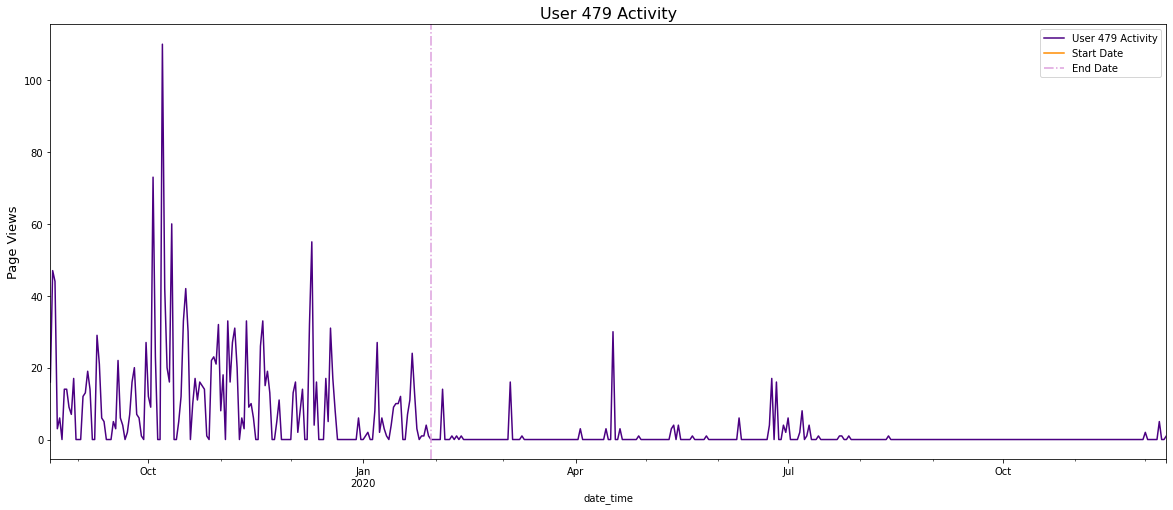

In [79]:
plot_user_activity(af, 479)

Seems like a pretty regular user

user_pages         lb         mb         ub     pct_b  user_id
date_time                                                                 
2019-10-03          73 -23.801314  13.381021  50.563357  1.301711      479
2019-10-07         110 -41.518613  18.764507  79.047628  1.256725      479
2019-12-10          55 -19.226946  12.837667  44.902281  1.157459      479
2020-03-04          16  -8.135223   1.742200  11.619622  1.221737      479
2020-04-17          30 -12.824909   2.267426  17.359761  1.418764      479
2020-06-10           6  -3.492974   0.614874   4.722721  1.155468      479
2020-06-23           4  -2.787501   0.516444   3.820388  1.027181      479
2020-06-24          17  -7.255711   1.579899  10.415509  1.372611      479
2020-06-26          16  -8.611017   2.414875  13.440767  1.116056      479
2020-12-01           2  -0.873112   0.129263   1.131638  1.433152      479
2020-12-07           5  -2.179395   0.409215   2.997826  1.386728      479

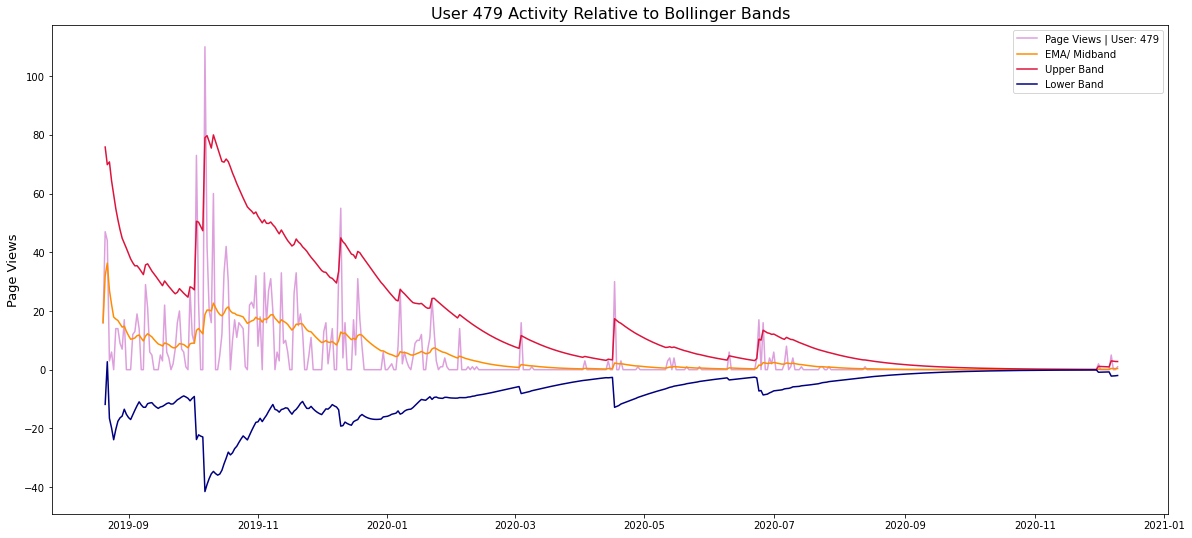

In [80]:
find_anomalies(af, 479, span, k, True)

That looks like a christmas tree that fell down. Other from that, I'd say I was expecting something like this based on the chart above this one.

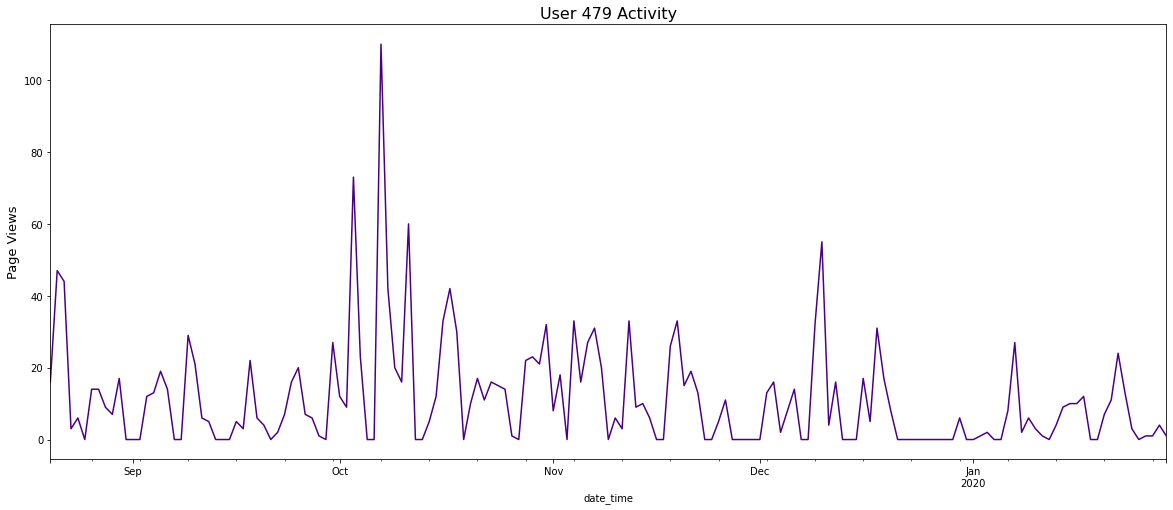

In [81]:
plot_active_user_activity(af, 479)

Yea maybe some extra studying got done. Seems reasonable. Maybe.

user_pages         lb         mb         ub     pct_b  user_id
date_time                                                                 
2019-10-03          73 -23.801314  13.381021  50.563357  1.301711      479
2019-10-07         110 -41.518613  18.764507  79.047628  1.256725      479
2019-12-10          55 -19.226946  12.837667  44.902281  1.157459      479

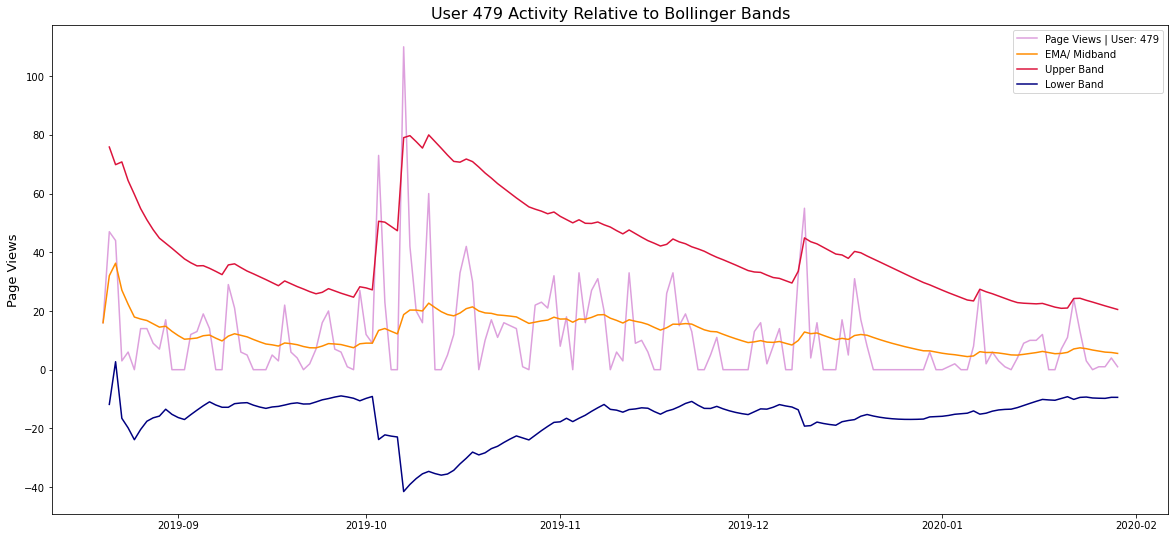

In [82]:
find_active_anomalies(af, 479, span, k, True)

Looks about right.

In [83]:
# bring up users' page views on this day
sus10.user_id.value_counts()

689    177
688    143
699     99
678     89
695     82
      ... 
367      1
517      1
551      1
637      1
480      1
Name: user_id, Length: 113, dtype: int64

Let's look at users 689 and 688.

In [84]:
user689_info = user_details(af, 689)
user689_info

cohort       program start_date   end_date
0  Darden  Data Science 2020-07-13 2021-01-12

In [85]:
user688_info = user_details(af, 688)
user688_info

cohort       program start_date   end_date
0  Darden  Data Science 2020-07-13 2021-01-12

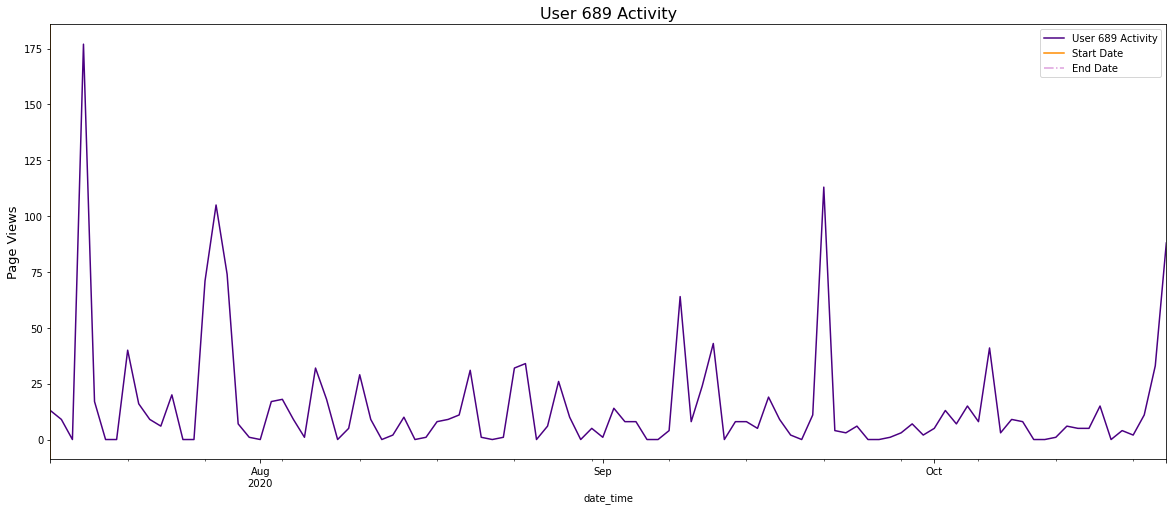

In [86]:
plot_user_activity(af, 689)

Okay, this user looked at over 175 pages at the beginning of the program. Interesting. Regular activity seems to match that of other students except for huge spikes. This user is definitely an anomaly.

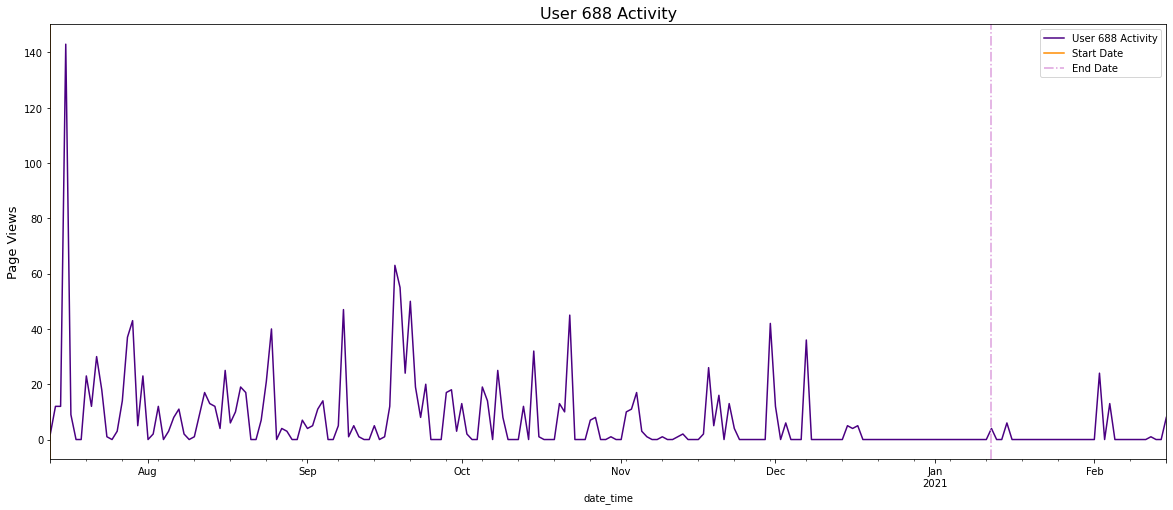

In [87]:
plot_user_activity(af, 688)

This user viewed over 140 pages in the beginning of the program. Perhaps they were merely outlining the curriculum? How long would that take? Is that even worth it? I don't know much about how web scraping the codeup curriculum (how many pages are there for each curriculum?), but that was some spike at the beginning of all this user's activity. Otherwise user activity looks the same relative to other students.

user_pages         lb         mb         ub     pct_b  user_id
date_time                                                                 
2020-09-08          64 -27.352840  13.044555  53.441951  1.130677      689
2020-09-21         113 -41.242657  18.150958  77.544573  1.298478      689
2020-10-22          88 -33.751457  14.784044  63.319545  1.254252      689

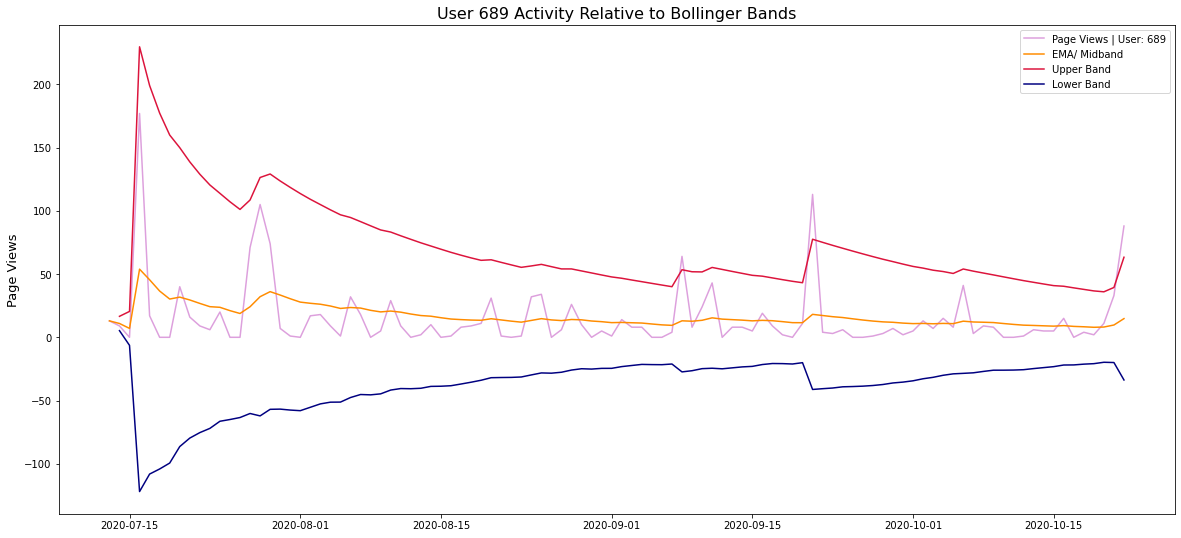

In [88]:
find_anomalies(af, 689, span, k, True)

Interesting. The large spike in activity set a precedent for 30 day exponential moving average. Otherwise, I would expect to see more anomalous data.

user_pages         lb         mb         ub     pct_b  user_id
date_time                                                                 
2020-09-08          47 -18.634290  10.428901  39.492092  1.129165      688
2020-09-18          63 -25.345255  10.713430  46.772115  1.225020      688
2020-09-19          55 -27.755136  13.599590  54.954315  1.000552      688
2020-10-22          45 -18.915085  10.850175  40.615435  1.073652      688
2020-11-18          26 -14.067486   5.019434  24.106354  1.049606      688
2020-11-30          42 -17.872653   6.302965  30.478582  1.238286      688
2020-12-07          36 -18.220978   7.089798  32.400574  1.071105      688
2021-02-02          24 -10.807287   1.923739  14.654765  1.367026      688

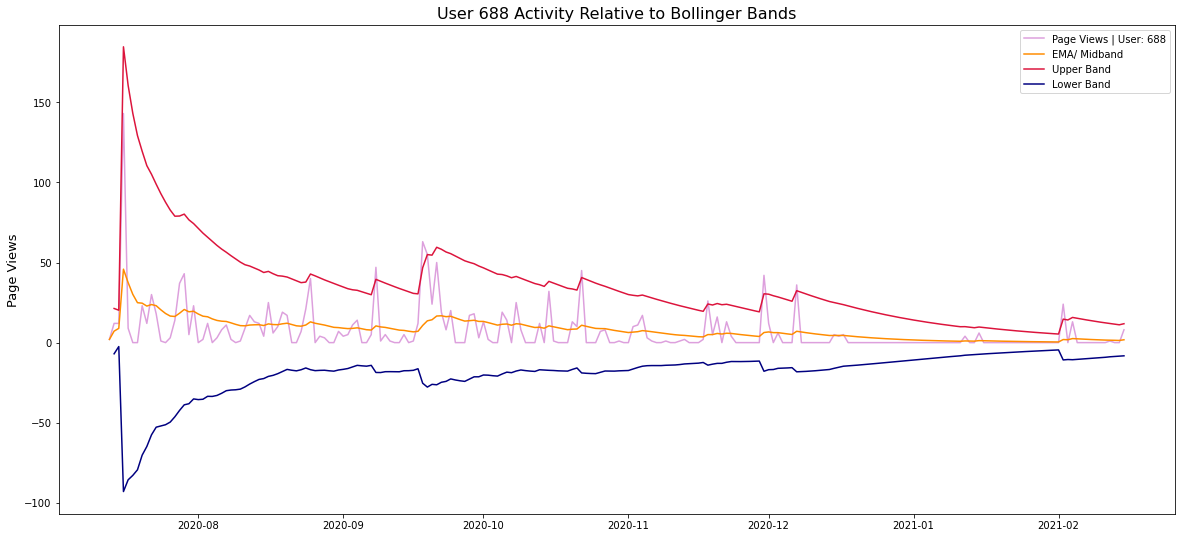

In [89]:
find_anomalies(af, 688, span, k, True)

Nothing out of the ordinary based off what I've seen so far.

In [90]:
user699_info = user_details(af, 699)
user699_info

cohort       program start_date   end_date
0  Darden  Data Science 2020-07-13 2021-01-12

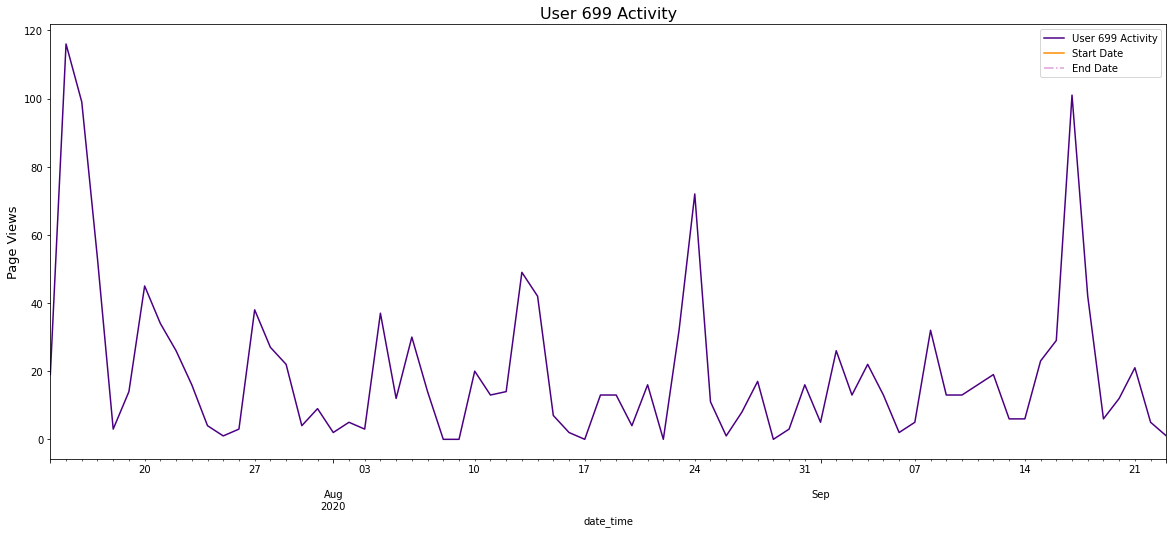

In [91]:
plot_user_activity(af, 699)

I guess user 699 searched despearately for the answers several times. I hope they found them.

user_pages         lb         mb         ub     pct_b  user_id
date_time                                                                 
2020-08-24          72 -24.492019  19.761967  64.015952  1.090207      699
2020-09-17         101 -28.798312  21.136150  71.070613  1.299687      699

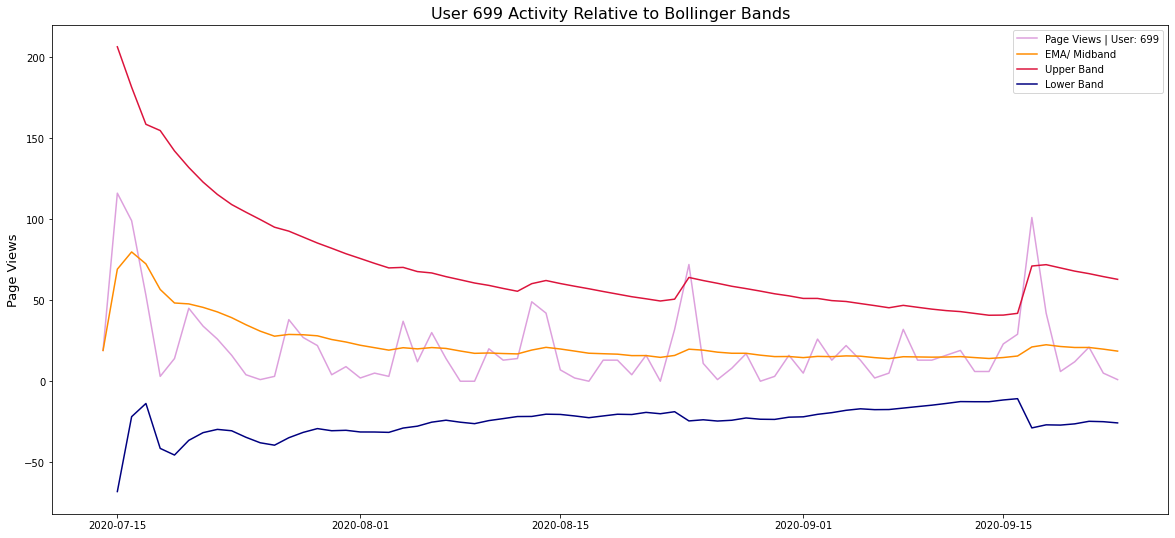

In [92]:
find_anomalies(af, 699, span, k, True)

I wonder what happened...

In [93]:
# bring up users' page views on this day
sus11.user_id.value_counts()

11     91
716    82
671    81
711    71
689    64
       ..
742     1
524     1
571     1
186     1
20      1
Name: user_id, Length: 120, dtype: int64

Let's look at user 11.

In [94]:
user11_info = user_details(af, 11)

ValueError: arrays must all be same length

Alright this user broke my user_details function. I'll settle for user 716.

In [95]:
user716_info = user_details(af, 716)
user716_info

cohort program start_date end_date
0    NaN     NaN        NaT      NaT

Just kidding. 
#### Wow, what? No info? Is this a hacker?

In [96]:
af[af.user_id == 716]

path  \
date_time                                                                
2020-07-20 16:16:16                                                  /   
2020-07-20 16:16:20                                                toc   
2020-07-20 16:16:34                                           html-css   
2020-07-20 16:16:41                                       javascript-i   
2020-07-20 17:22:33                                           html-css   
...                                                                ...   
2021-02-17 01:13:51        appendix/extra-challenges/beef-up-your-blog   
2021-02-17 01:14:07  appendix/further-reading/java/intellij-tomcat-...   
2021-02-17 01:14:19     appendix/professional-development/cover-letter   
2021-02-17 01:14:23     appendix/professional-development/cover-letter   
2021-02-21 20:22:57  appendix/professional-development/job-search-w...   

                     user_id  cohort_id            ip name start_date  \
date_time                                                               
2020-07-20 16:16:16      716        NaN  70.117.16.60  NaN        NaT   
2020-07-20 16:16:20      716        NaN  70.117.16.60  NaN        NaT   
2020-07-20 16:16:34      716        NaN  70.117.16.60  NaN        NaT   
2020-07-20 16:16:41      716        NaN  70.117.16.60  NaN        NaT   
2020-07-20 17:22:33      716        NaN  70.117.16.60  NaN        NaT   
...                      ...        ...           ...  ...        ...   
2021-02-17 01:13:51      716        NaN  70.117.16.60  NaN        NaT   
2021-02-17 01:14:07      716        NaN  70.117.16.60  NaN        NaT   
2021-02-17 01:14:19      716        NaN  70.117.16.60  NaN        NaT   
2021-02-17 01:14:23      716        NaN  70.117.16.60  NaN        NaT   
2021-02-21 20:22:57      716        NaN  70.117.16.60  NaN        NaT   

                    end_date created_at updated_at  program_id  front_end  \
date_time                                                                   
2020-07-20 16:16:16      NaT        NaT        NaT         NaN          0   
2020-07-20 16:16:20      NaT        NaT        NaT         NaN          0   
2020-07-20 16:16:34      NaT        NaT        NaT         NaN          0   
2020-07-20 16:16:41      NaT        NaT        NaT         NaN          0   
2020-07-20 17:22:33      NaT        NaT        NaT         NaN          0   
...                      ...        ...        ...         ...        ...   
2021-02-17 01:13:51      NaT        NaT        NaT         NaN          0   
2021-02-17 01:14:07      NaT        NaT        NaT         NaN          0   
2021-02-17 01:14:19      NaT        NaT        NaT         NaN          0   
2021-02-17 01:14:23      NaT        NaT        NaT         NaN          0   
2021-02-21 20:22:57      NaT        NaT        NaT         NaN          0   

                     data_science  java  php program  staff  
date_time                                                    
2020-07-20 16:16:16             0     0    0     NaN  False  
2020-07-20 16:16:20             0     0    0     NaN  False  
2020-07-20 16:16:34             0     0    0     NaN  False  
2020-07-20 16:16:41             0     0    0     NaN  False  
2020-07-20 17:22:33             0     0    0     NaN  False  
...                           ...   ...  ...     ...    ...  
2021-02-17 01:13:51             0     0    0     NaN  False  
2021-02-17 01:14:07             0     0    0     NaN  False  
2021-02-17 01:14:19             0     0    0     NaN  False  
2021-02-17 01:14:23             0     0    0     NaN  False  
2021-02-21 20:22:57             0     0    0     NaN  False  

[2136 rows x 16 columns]

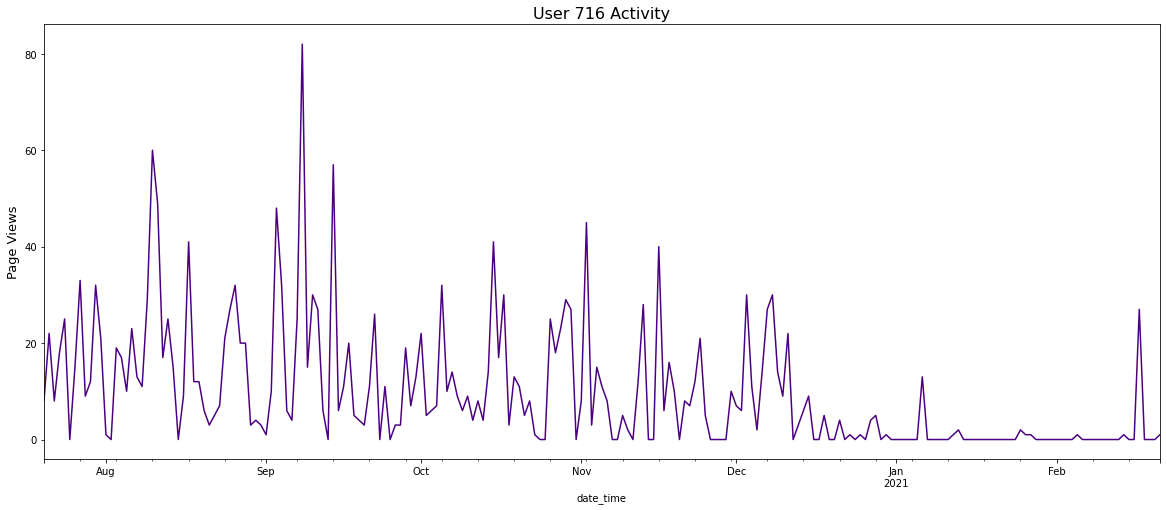

In [97]:
plot_activity(af, 716)

Hmm. Maybe just extra spikey.

user_pages         lb         mb         ub     pct_b  user_id
date_time                                                                 
2020-08-10          60 -11.656466  19.563958  50.784381  1.147590      716
2020-09-03          48 -13.716317  16.344864  46.406045  1.026512      716
2020-09-08          82 -22.602769  20.781051  64.164871  1.205550      716
2020-10-15          41 -12.704840  13.248507  39.201855  1.034642      716
2020-11-02          45 -12.415005  15.231739  42.878484  1.038368      716
2020-11-16          40 -15.555698  12.049518  39.654735  1.006254      716
2021-02-17          27 -11.726146   2.136833  15.999813  1.396747      716

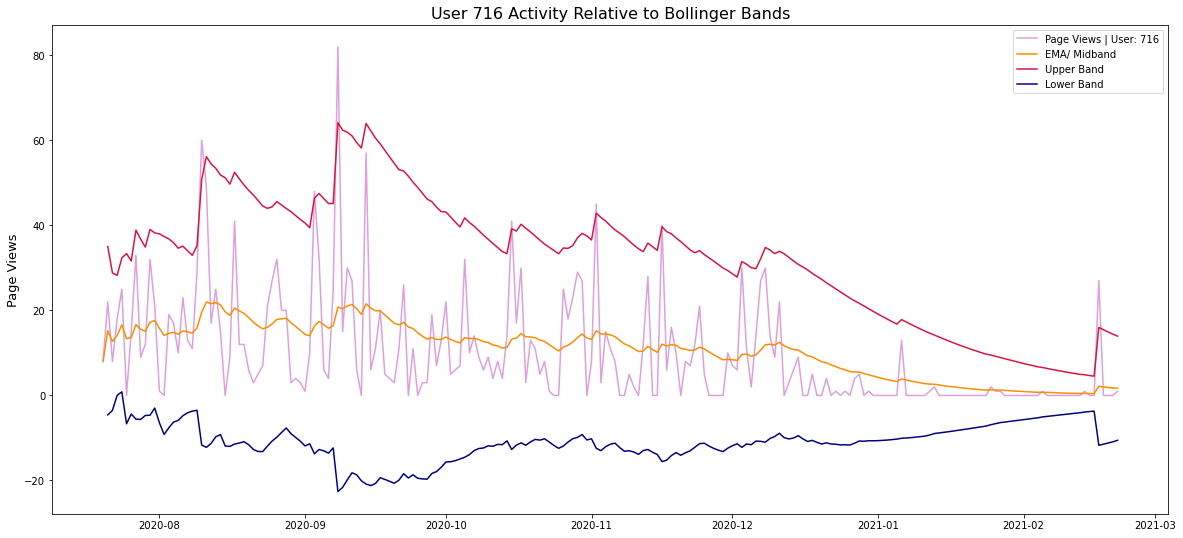

In [98]:
find_anomalies(af, 716, span, k, True)

Who is user 716? Are they staff? Much more spikes here. Activity seems low except for both spikes above and below the height of the upper band.

What about user 671?

In [99]:
user671_info = user_details(af, 671)
user671_info

cohort          program start_date   end_date
0  Hyperion  Full-Stack Java 2020-05-26 2020-11-10

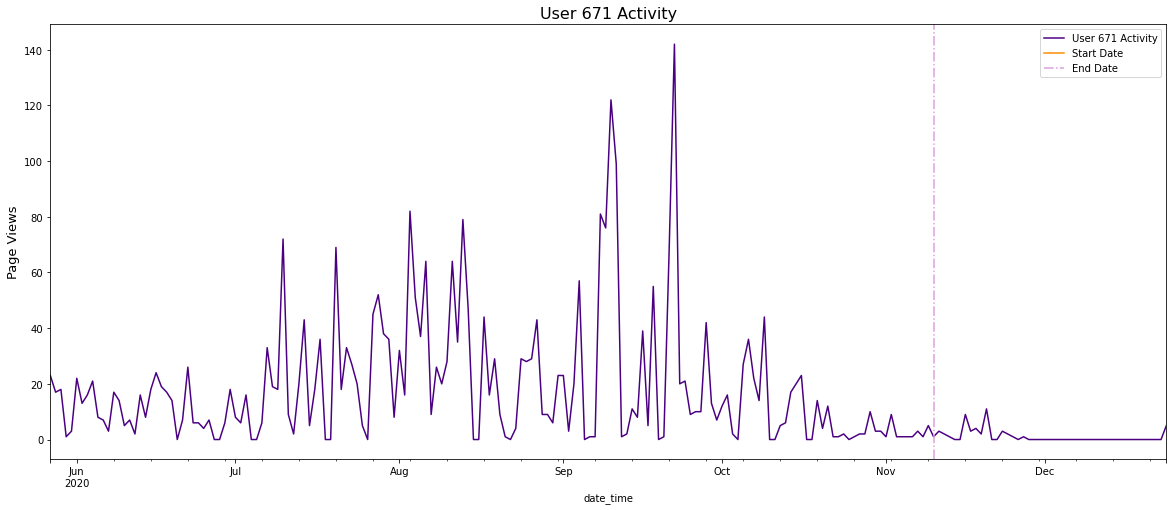

In [100]:
plot_user_activity(af, 671)

user_pages         lb         mb          ub     pct_b  user_id
date_time                                                                  
2020-07-07          33  -9.010049  10.114030   29.238109  1.098355      671
2020-07-10          72 -20.680612  15.344441   51.369494  1.286336      671
2020-07-20          69 -24.074958  18.492649   61.060255  1.093260      671
2020-08-03          82 -19.953157  26.559770   73.072696  1.095966      671
2020-09-08          81 -26.158951  23.534932   73.228816  1.078191      671
2020-09-10         122 -38.098933  33.061566  104.222065  1.124914      671
2020-09-22         142 -49.584822  36.719933  123.024688  1.109932      671

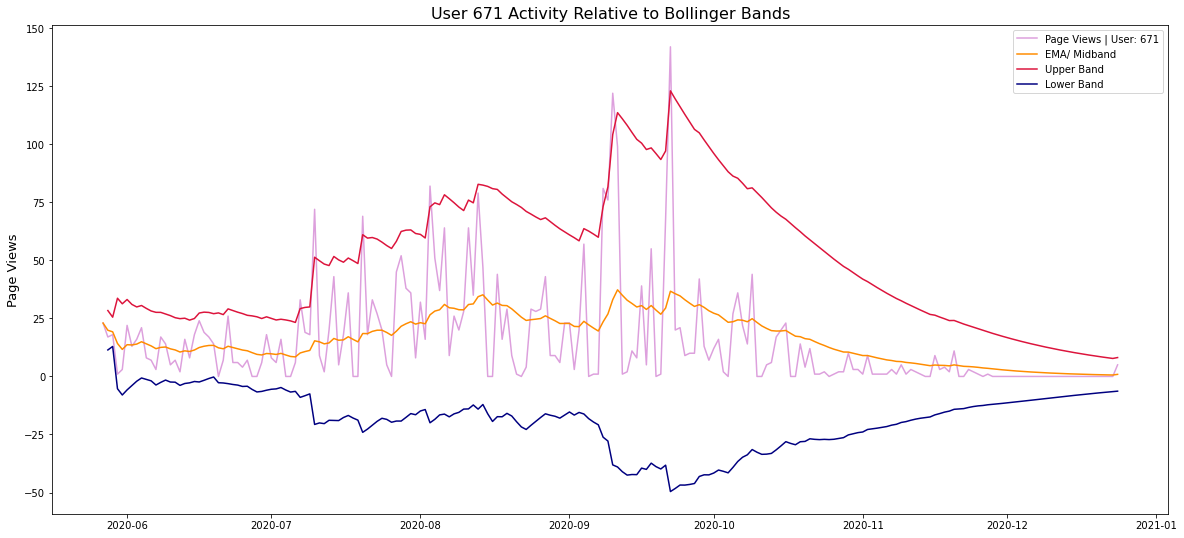

In [101]:
find_anomalies(af, 671, span, k, True)

Whoa. This user has a shape unlike any of the other ones. Those last two spikes above the upper band are very high, kind of like User 689-- User 689 had 3 big spikes of over 100 page views. I don't know what to make of this except that it seems like this person navigated the curriculum a lot. 

What about user 11?

In [102]:
af[af.user_id == 11].name.unique()

array(['Arches', 'Staff'], dtype=object)

In [103]:
af[af.user_id == 11].start_date.unique()

array(['2014-02-04T00:00:00.000000000'], dtype='datetime64[ns]')

In [104]:
af[af.user_id == 11].end_date.unique()

array(['2014-04-22T00:00:00.000000000', '2014-02-04T00:00:00.000000000'],
      dtype='datetime64[ns]')

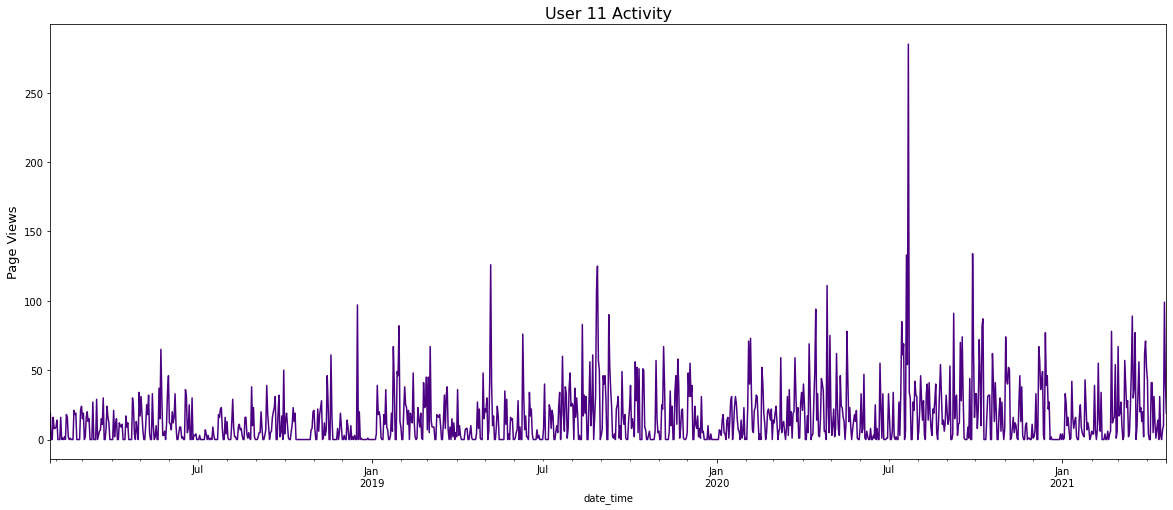

In [105]:
plot_activity(af, 11)

Whoa.

Empty DataFrame
Columns: [user_pages, lb, mb, ub, pct_b, user_id]
Index: []

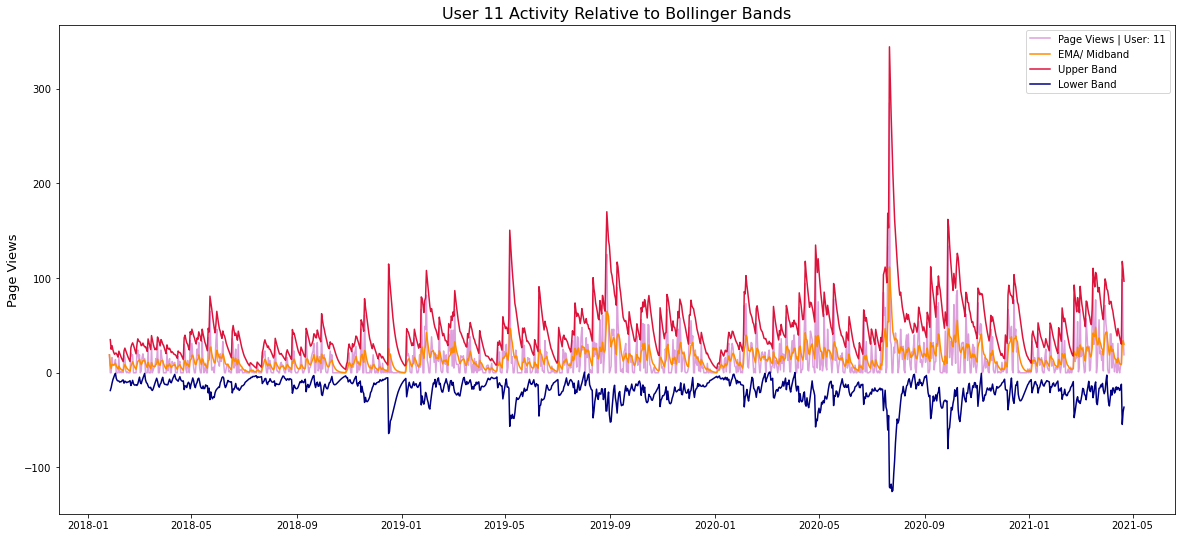

In [106]:
find_anomalies(af, 11, 7, k, True)

Same thing happened earlier with another staff member. Maybe there can be no anomalies with a 7-day exponential moving average as the basis for the bollinger bands.

#### Let's look at all users with anomalous data.

In [107]:
# set empty frame
anomalies = pd.DataFrame()

# loop through all unique user ids to find anomalous data amongst users
for u in list(af.user_id.unique()):
    user_df = find_anomalies(af, u, 30, 2)
    anomalies = pd.concat([anomalies, user_df], axis=0)

In [108]:
# view anomalous data
anomalies

user_pages         lb         mb          ub     pct_b  user_id
date_time                                                                  
2018-02-20          54 -22.804758   6.456745   35.718248  1.312386        1
2018-03-19          35 -13.760453   9.304089   32.368632  1.057044        1
2018-05-04          27 -10.377545   7.179313   24.736171  1.064471        1
2018-05-11          27 -10.405390   8.141119   26.687629  1.008421        1
2018-05-29          68 -25.562347   9.612443   44.787234  1.329963        1
...                ...        ...        ...         ...       ...      ...
2021-03-29          28 -12.418268   6.004114   24.426496  1.096988      948
2021-04-17          25  -6.815837   8.260254   23.336345  1.055175      948
2021-04-18          50 -15.120712  11.264267   37.649246  1.234049      948
2021-04-02          40 -13.977567  10.999621   35.976810  1.080537      949
2021-04-06         122 -55.532420  27.694512  110.921445  1.066556      951

[6724 rows x 6 columns]

In [109]:
# view heaviest anomalous data
anomalies.sort_values('user_pages', ascending = False).nlargest(88, columns = 'user_pages')

user_pages          lb         mb          ub     pct_b  user_id
date_time                                                                   
2020-07-22         285 -102.667146  44.915959  192.499064  1.313386       11
2019-03-03         272 -113.597508  24.721632  163.040772  1.393869      341
2020-04-16         271 -104.899276  44.194413  193.288101  1.260614      570
2019-07-25         253  -90.641543  34.698961  160.039466  1.370832      422
2020-04-26         234 -101.468663  54.999406  211.467475  1.072004      570
...                ...         ...        ...         ...       ...      ...
2019-07-08         104  -21.800798  33.047814   87.896427  1.146800      418
2020-08-18         104  -35.770808  29.188690   94.148188  1.075830       64
2021-03-29         103  -29.107281  21.763702   72.634684  1.298454      823
2019-04-08         103  -20.402377  34.932904   90.268184  1.115042      344
2020-05-05         102  -37.482148  13.566012   64.614173  1.366182      564

[88 rows x 6 columns]

In [110]:
# view user ids with heavy anomalous data
print('Users with anomalous data')
print('-------------------------')
weird_users = list(anomalies.sort_values('user_pages', ascending = False)\
           .nlargest(88, columns = 'user_pages')\
           .user_id.unique())

# sort list for giggles
weird_users.sort()

# view weird users
print(weird_users)

Users with anomalous data
-------------------------
[11, 64, 101, 111, 138, 157, 183, 218, 221, 223, 248, 272, 274, 304, 309, 310, 313, 314, 325, 341, 344, 347, 354, 374, 386, 410, 418, 422, 423, 435, 479, 480, 482, 484, 494, 495, 521, 526, 531, 554, 564, 570, 571, 581, 600, 615, 632, 635, 658, 666, 671, 685, 689, 742, 785, 823, 875, 911, 951]


### Exercise V
Plot the access activity of these students.

In [111]:
# pull up all data for top 88 anomalous activity logs
anomaly_days = af[af.user_id.apply(lambda x: af.user_id[x] in weird_users)]
anomaly_days

path  \
date_time                                                                
2018-01-26 11:46:42  appendix/further-reading/javascript/hoisting.html   
2018-01-26 11:47:09                                           appendix   
2018-01-26 11:47:14       appendix/further-reading/javascript/hoisting   
2018-01-26 11:49:07                                           appendix   
2018-01-26 11:49:11                         appendix/capstone-workbook   
...                                                                ...   
2021-04-19 15:20:55                        timeseries/modeling-lesson1   
2021-04-21 09:15:32                         anomaly-detection/overview   
2021-04-21 09:15:32     anomaly-detection/AnomalyDetectionCartoon.jpeg   
2021-04-21 11:09:00  anomaly-detection/continuous-probabilistic-met...   
2021-04-21 16:23:53                                                  /   

                     user_id  cohort_id              ip     name start_date  \
date_time                                                                     
2018-01-26 11:46:42       30       22.0    97.105.19.61    Teddy 2018-01-08   
2018-01-26 11:47:09       31       22.0    97.105.19.61    Teddy 2018-01-08   
2018-01-26 11:47:14       31       22.0    97.105.19.61    Teddy 2018-01-08   
2018-01-26 11:49:07       33       21.0    97.105.19.61  Sequoia 2017-09-27   
2018-01-26 11:49:11       33       21.0    97.105.19.61  Sequoia 2017-09-27   
...                      ...        ...             ...      ...        ...   
2021-04-19 15:20:55      143      133.0  173.174.194.60   Easley 2020-12-07   
2021-04-21 09:15:32      143      133.0  173.174.194.60   Easley 2020-12-07   
2021-04-21 09:15:32      143      133.0  173.174.194.60   Easley 2020-12-07   
2021-04-21 11:09:00      143      133.0  173.174.194.60   Easley 2020-12-07   
2021-04-21 16:23:53      143      133.0  173.174.194.60   Easley 2020-12-07   

                      end_date          created_at          updated_at  \
date_time                                                                
2018-01-26 11:46:42 2018-05-17 2018-01-08 13:59:10 2018-01-08 13:59:10   
2018-01-26 11:47:09 2018-05-17 2018-01-08 13:59:10 2018-01-08 13:59:10   
2018-01-26 11:47:14 2018-05-17 2018-01-08 13:59:10 2018-01-08 13:59:10   
2018-01-26 11:49:07 2018-02-15 2017-09-27 20:22:41 2017-09-27 20:22:41   
2018-01-26 11:49:11 2018-02-15 2017-09-27 20:22:41 2017-09-27 20:22:41   
...                        ...                 ...                 ...   
2021-04-19 15:20:55 2021-06-08 2020-12-07 15:20:18 2020-12-07 15:20:18   
2021-04-21 09:15:32 2021-06-08 2020-12-07 15:20:18 2020-12-07 15:20:18   
2021-04-21 09:15:32 2021-06-08 2020-12-07 15:20:18 2020-12-07 15:20:18   
2021-04-21 11:09:00 2021-06-08 2020-12-07 15:20:18 2020-12-07 15:20:18   
2021-04-21 16:23:53 2021-06-08 2020-12-07 15:20:18 2020-12-07 15:20:18   

                     program_id  front_end  data_science  java  php  \
date_time                                                             
2018-01-26 11:46:42         2.0          0             0     1    0   
2018-01-26 11:47:09         2.0          0             0     1    0   
2018-01-26 11:47:14         2.0          0             0     1    0   
2018-01-26 11:49:07         2.0          0             0     1    0   
2018-01-26 11:49:11         2.0          0             0     1    0   
...                         ...        ...           ...   ...  ...   
2021-04-19 15:20:55         3.0          0             1     0    0   
2021-04-21 09:15:32         3.0          0             1     0    0   
2021-04-21 09:15:32         3.0          0             1     0    0   
2021-04-21 11:09:00         3.0          0             1     0    0   
2021-04-21 16:23:53         3.0          0             1     0    0   

                             program  staff  
date_time                                    
2018-01-26 11:46:42  Full-Stack Java  False  
2018-01-26 11:47:09  Full-Stack Java  False  
2018

In [112]:
# verify unique users found
ways = af[af.user_id.apply(lambda x : af.user_id[x] in weird_users)].user_id.unique()
ways

array([ 30,  31,  33, 134, 136, 139, 141, 142, 143, 179, 180, 181, 211,
       212, 213, 222, 289, 312, 316])

In [114]:
len(ways)

19

Weird. Guess I did that lambda wrong. Let's just look at top 10 instances of anomalous data.

In [115]:
# pull up top 10 days of anomalous data
anomalies.sort_values('user_pages', ascending = False).nlargest(10, columns = 'user_pages')

user_pages          lb         mb          ub     pct_b  user_id
date_time                                                                   
2020-07-22         285 -102.667146  44.915959  192.499064  1.313386       11
2019-03-03         272 -113.597508  24.721632  163.040772  1.393869      341
2020-04-16         271 -104.899276  44.194413  193.288101  1.260614      570
2019-07-25         253  -90.641543  34.698961  160.039466  1.370832      422
2020-04-26         234 -101.468663  54.999406  211.467475  1.072004      570
2020-04-05         232  -83.597902  32.133967  147.865836  1.363487      570
2018-12-19         225 -109.636842  20.831494  151.299829  1.282445      313
2018-06-02         198  -81.962052  16.484863  114.931779  1.421893      138
2019-12-19         192  -76.186407  19.601776  115.389959  1.399893      526
2018-12-10         187  -72.169392  22.688588  117.546568  1.366092      310

We already looked at user 11.

In [116]:
heavy_users = list(anomalies\
                   .sort_values('user_pages', ascending = False)\
                   .nlargest(10, columns = 'user_pages')\
                   .user_id.unique()
                  )
heavy_users

[11, 341, 570, 422, 313, 138, 526, 310]

In [117]:
user341_info = user_details(af, 341)
user341_info

cohort          program start_date   end_date
0   Zion  Full-Stack Java 2019-01-22 2019-06-04

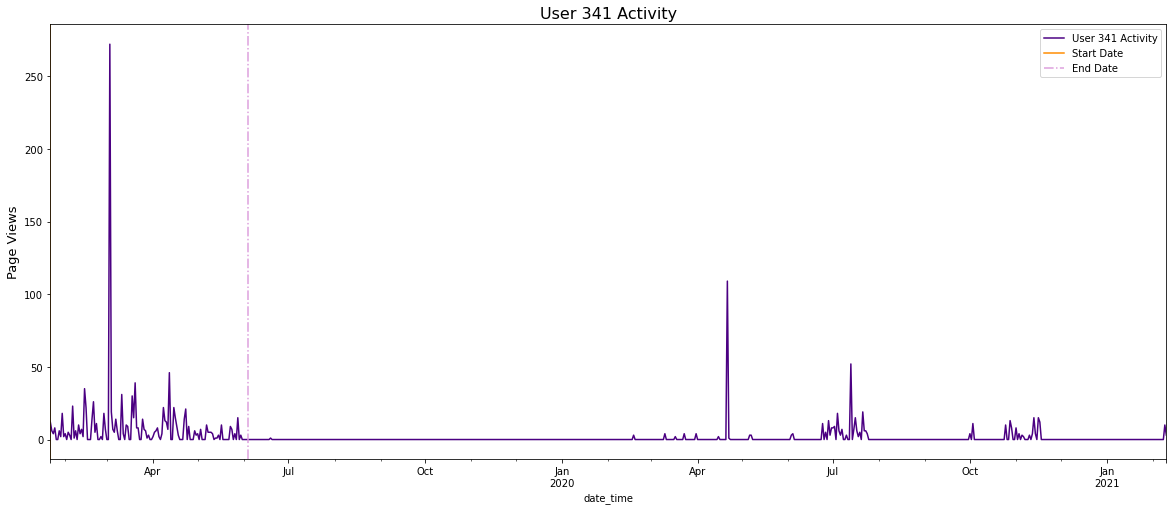

In [118]:
plot_user_activity(af, 341)

Interesting. Much activity after the program was over, but only about a year later.

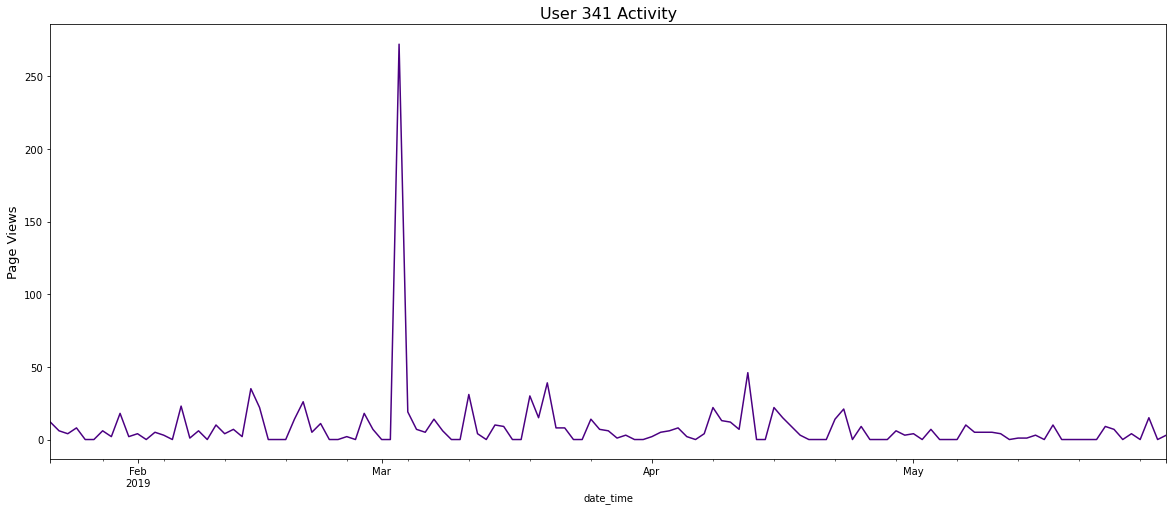

In [119]:
plot_active_user_activity(af, 341)

These numbers are very similar to other students with anomalous data, except for the one and only spike. What a spike. What a spike. Over 250 page views. Wow. What happened that day?

user_pages          lb         mb          ub     pct_b  user_id
date_time                                                                   
2019-02-06          23   -8.813193   6.070363   20.953918  1.068736      341
2019-02-14          35  -12.443903   7.660569   27.765041  1.179934      341
2019-03-03         272 -113.597508  24.721632  163.040772  1.393869      341

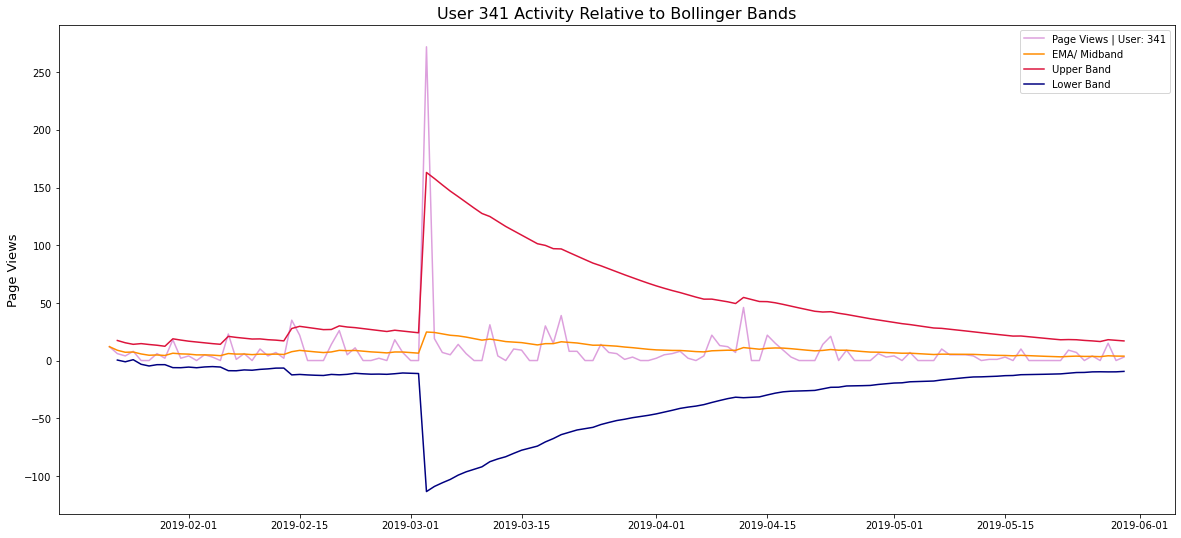

In [120]:
find_active_anomalies(af, 341, span, k, True)

I just wanted to watch the bollinger bands plot. I don't see anything here that I wasn't expecting from the chart above this one.

In [121]:
heavy_users[2]

570

In [122]:
user570_info = user_details(af, 570)
user570_info

cohort          program start_date   end_date
0  Fortuna  Full-Stack Java 2020-01-13 2020-06-23

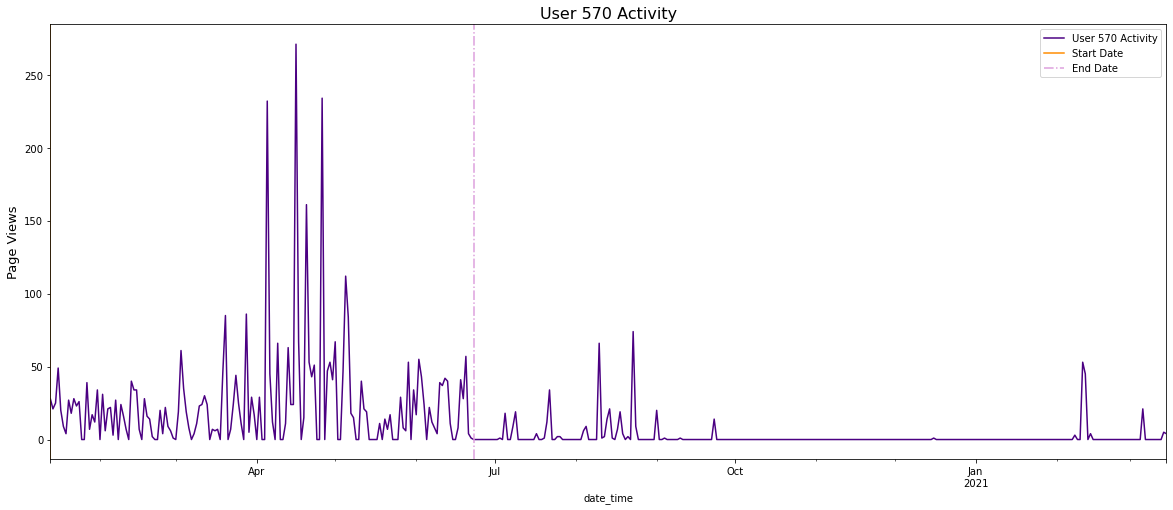

In [123]:
plot_user_activity(af, 570)

Talk about spikey.

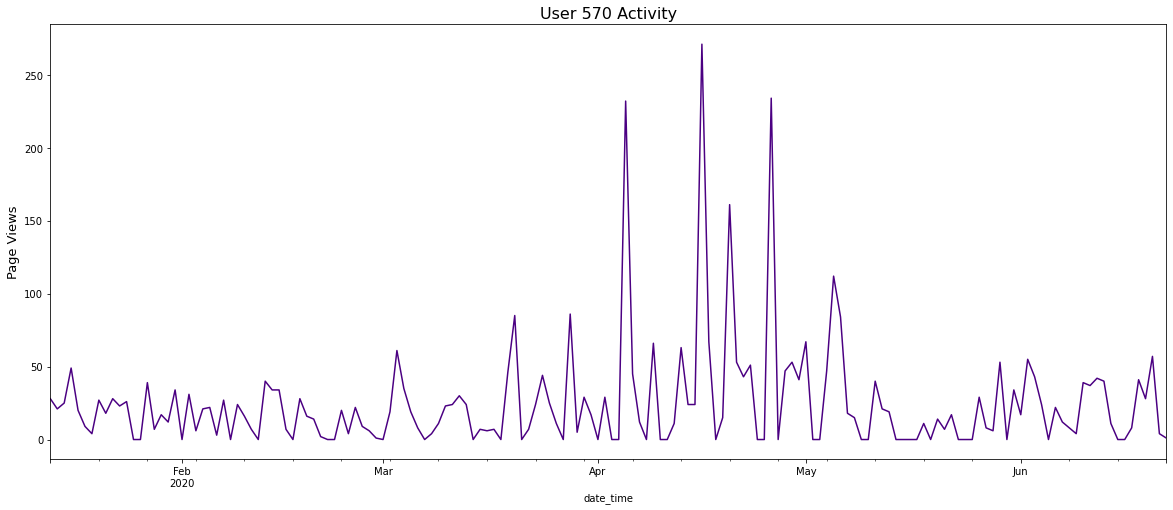

In [124]:
plot_active_user_activity(af, 570)

Somebody order the spikey supreme?

user_pages          lb         mb          ub     pct_b  user_id
date_time                                                                   
2020-03-03          61  -18.152533  15.580157   49.312847  1.173232      570
2020-03-20          85  -26.100223  19.914882   65.929986  1.207215      570
2020-03-28          86  -29.374393  22.774600   74.923594  1.106200      570
2020-04-05         232  -83.597902  32.133967  147.865836  1.363487      570
2020-04-16         271 -104.899276  44.194413  193.288101  1.260614      570
2020-04-26         234 -101.468663  54.999406  211.467475  1.072004      570

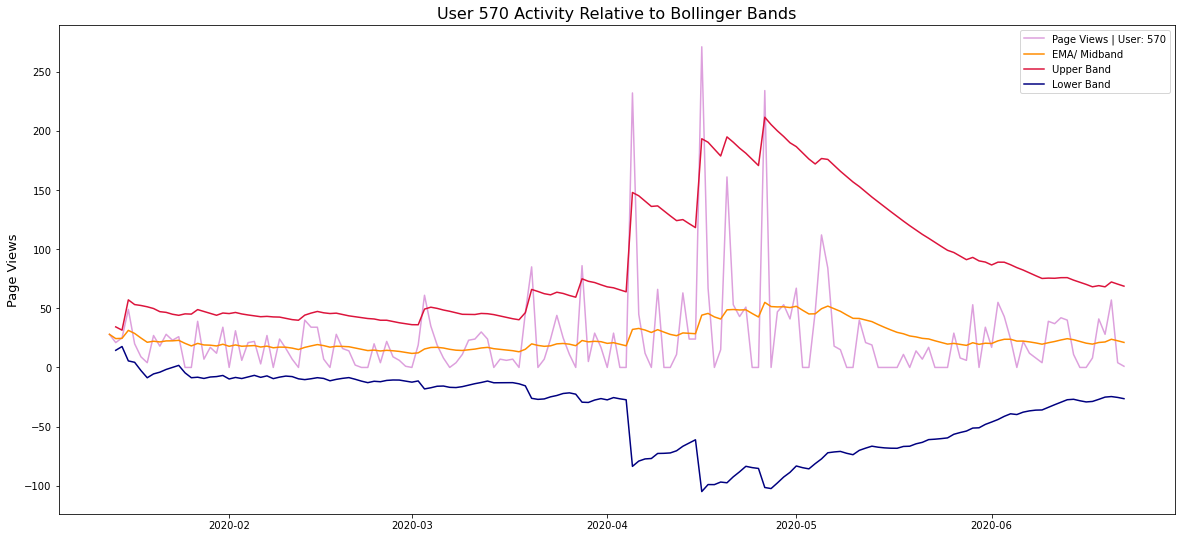

In [125]:
find_active_anomalies(af, 570, span, k, True)

That'll be $13.

In [126]:
heavy_users[3]

422

In [127]:
user422_info = user_details(af, 422)
user422_info

cohort          program start_date   end_date
0  Betelgeuse  Full-Stack Java 2019-05-28 2019-10-08

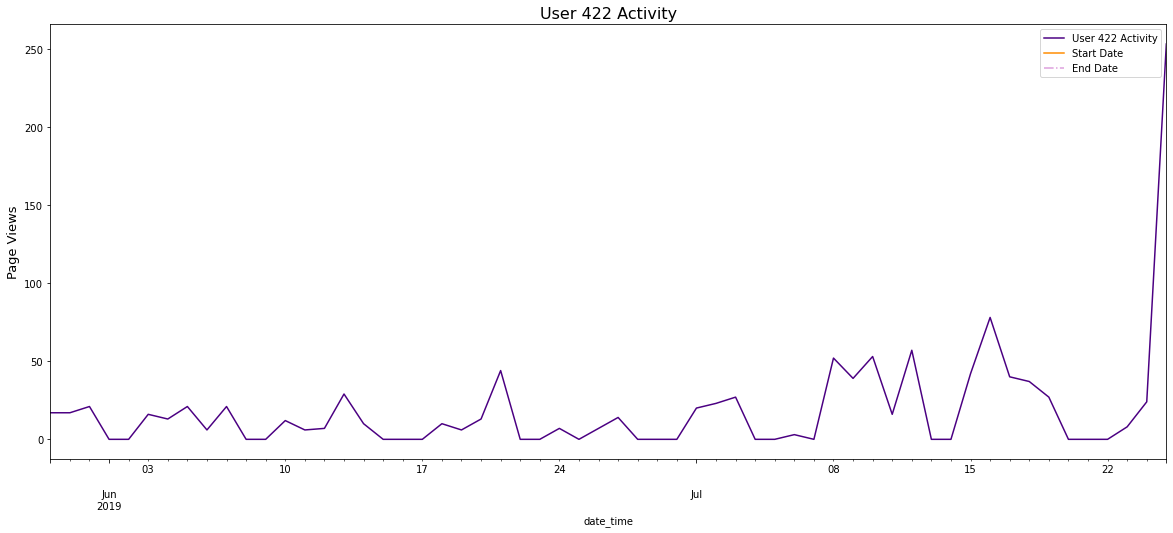

In [128]:
plot_user_activity(af, 422)

User 422 got the big ugly axe right when it was getting good. Denial of stealing proprietary curriculum material? Activity suddenly stops after what looks like a web scrape. Did they get what they were searching for? Was this a mission success? 

user_pages         lb         mb          ub     pct_b  user_id
date_time                                                                  
2019-06-21          44 -13.615305  11.720353   37.056012  1.137040      422
2019-07-08          52 -19.811060  11.122930   42.056919  1.160715      422
2019-07-16          78 -28.344280  21.927781   72.199841  1.057688      422
2019-07-25         253 -90.641543  34.698961  160.039466  1.370832      422

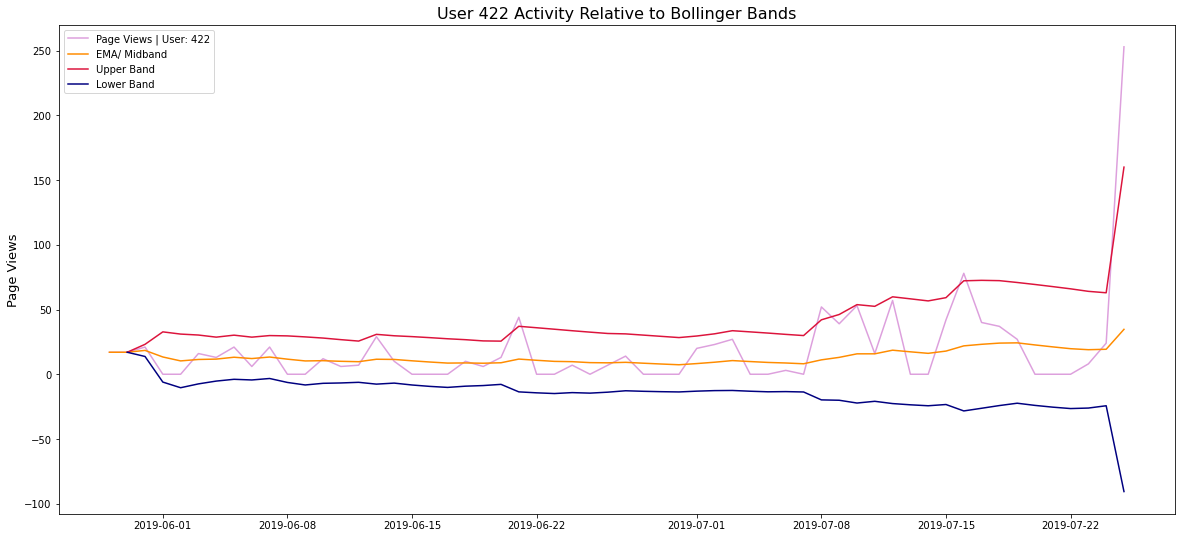

In [129]:
find_anomalies(af, 422, span, k, True)

In [130]:
heavy_users[4]

313

In [131]:
user313_info = user_details(af, 313)
user313_info

cohort         program start_date   end_date
0  Arches  Full-Stack PHP 2014-02-04 2014-04-22

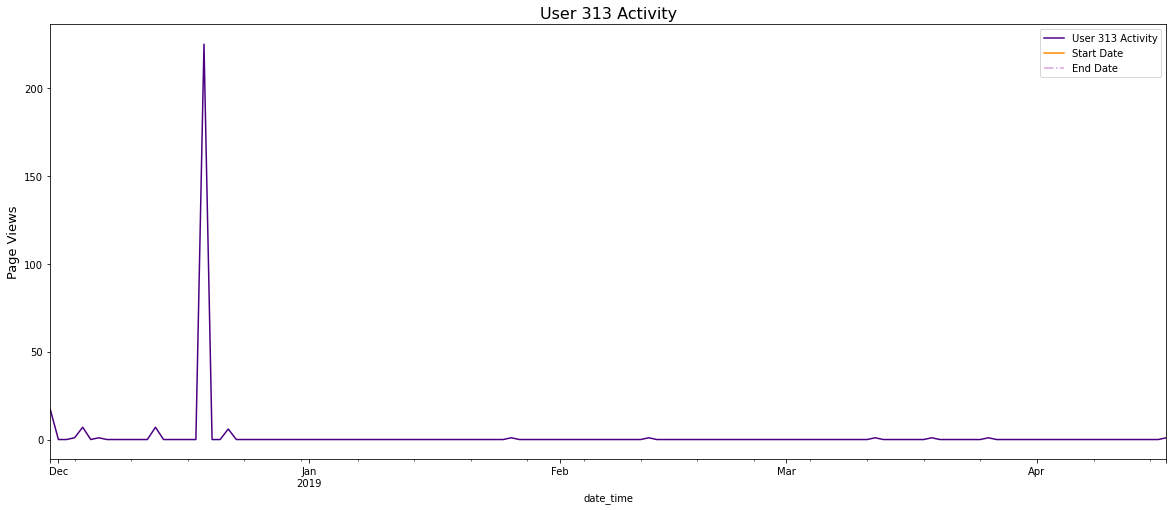

In [132]:
plot_user_activity(af, 313)

Barely any activity at all. All of this activity is post graduation. Was this a scrape? Is this a staff member? What did they access?

In [133]:
af[af.user_id == 313].path.value_counts()

javascript-ii/map-filter-reduce                  8
html-css                                         7
/                                                5
toc                                              5
appendix/slides                                  4
                                                ..
slides/methods                                   1
appendix/extra-challenges/website-status-page    1
slides/collections                               1
spring/extra-features/file-upload                1
javascript-i/bom-and-dom                         1
Name: path, Length: 194, dtype: int64

Java stuff. Maybe they came back to download the curriculum just in case the internet went down, haha.

In [134]:
heavy_users[5]

138

In [135]:
user138_info = user_details(af, 138)
user138_info

cohort          program start_date   end_date
0  Teddy  Full-Stack Java 2018-01-08 2018-05-17

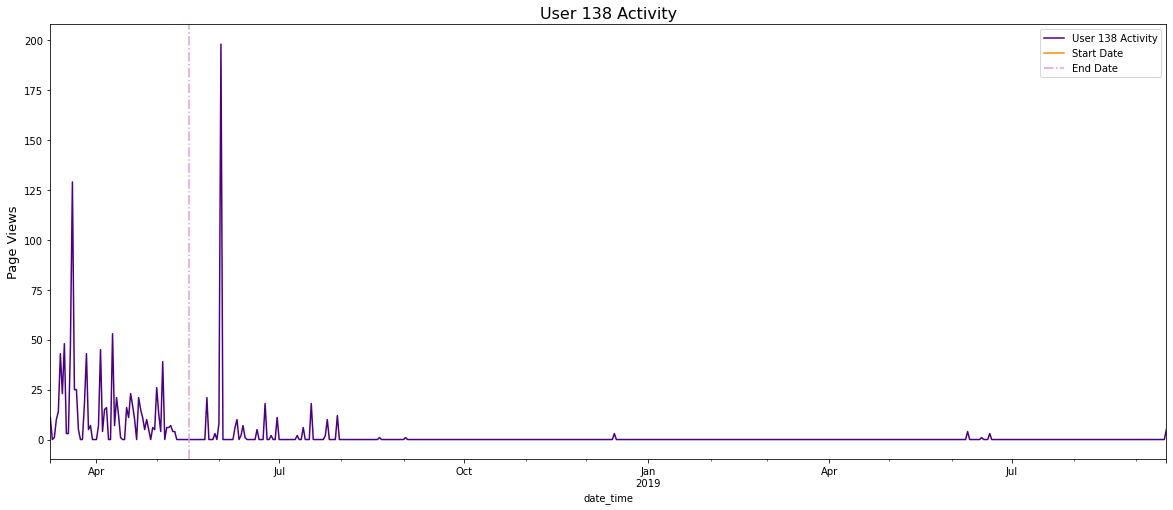

In [136]:
plot_user_activity(af, 138)

Whoa. Big activity post graduation.

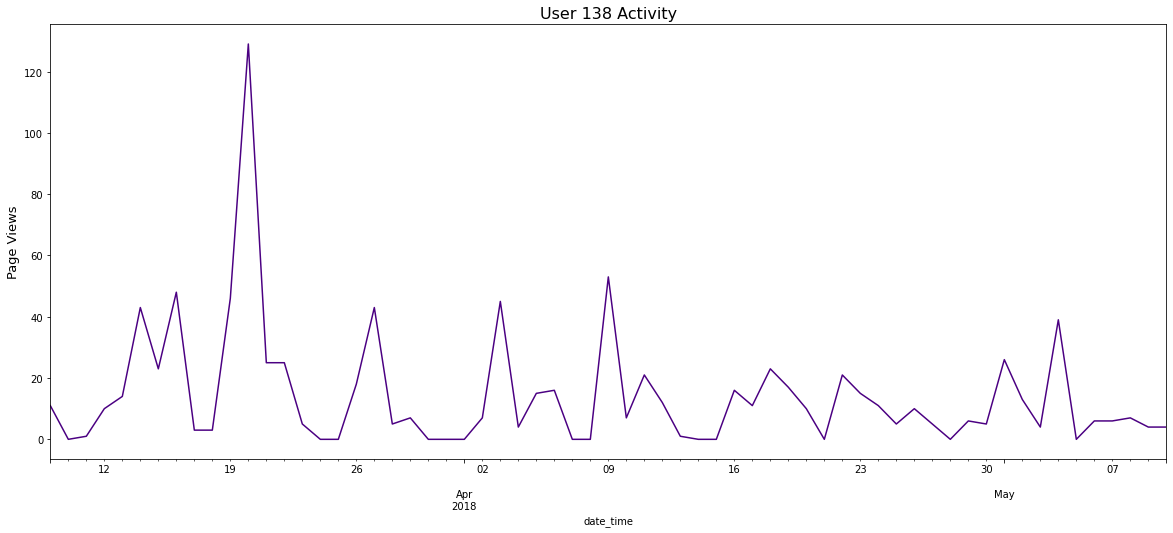

In [137]:
plot_active_user_activity(af, 138)

user_pages         lb         mb          ub     pct_b  user_id
date_time                                                                  
2018-03-20         129 -49.263674  32.755142  114.773958  1.086724      138

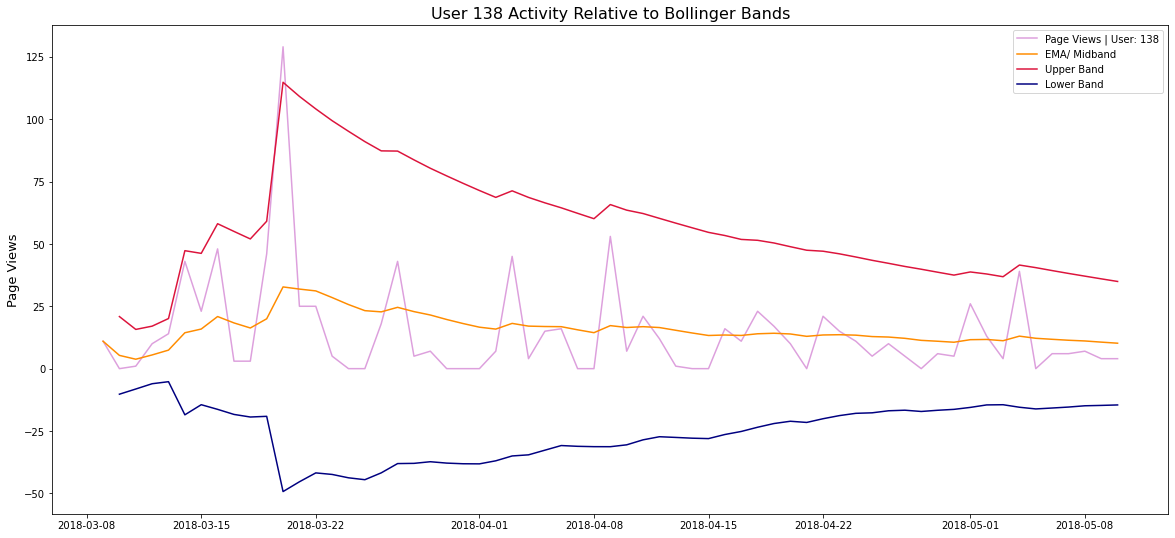

In [138]:
find_active_anomalies(af, 138, span, k, True)

user_pages         lb         mb          ub     pct_b  user_id
date_time                                                                  
2018-03-20         129 -49.263674  32.755142  114.773958  1.086724      138
2018-06-02         198 -81.962052  16.484863  114.931779  1.421893      138
2018-12-15           3  -1.316560   0.193901    1.704362  1.428888      138
2019-06-09           4  -1.740897   0.258066    2.257029  1.435969      138
2019-06-20           3  -1.658268   0.366875    2.392018  1.150108      138
2019-09-16           5  -2.177160   0.323617    2.824395  1.434986      138

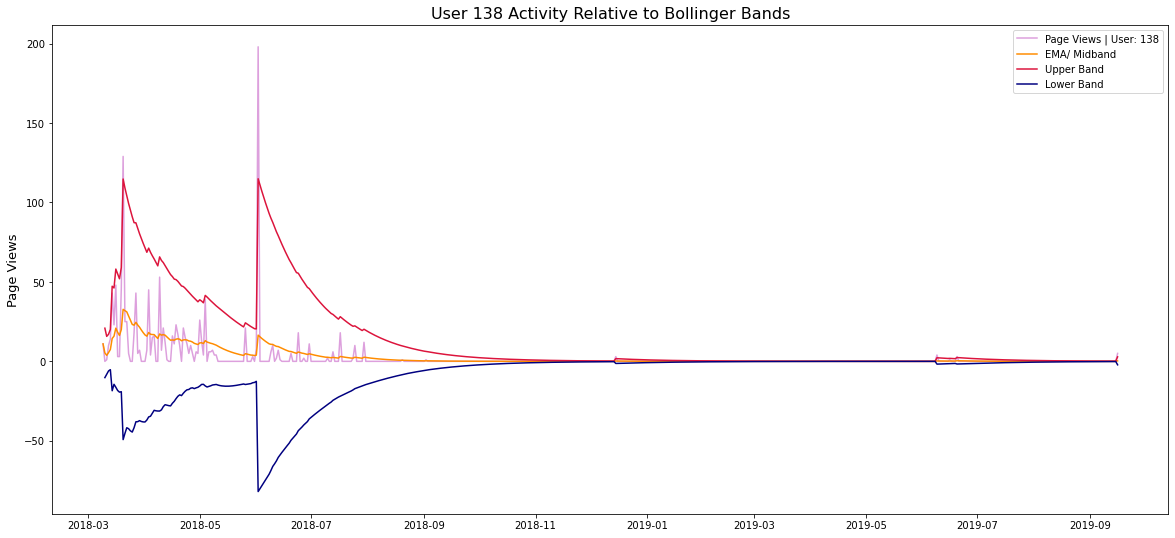

In [139]:
find_anomalies(af, 138, span, k, True)

Looks like a poison dart.

In [140]:
heavy_users[6]

526

In [141]:
user526_info = user_details(af, 526)
user526_info

cohort          program start_date   end_date
0  Europa  Full-Stack Java 2019-11-04 2020-04-17

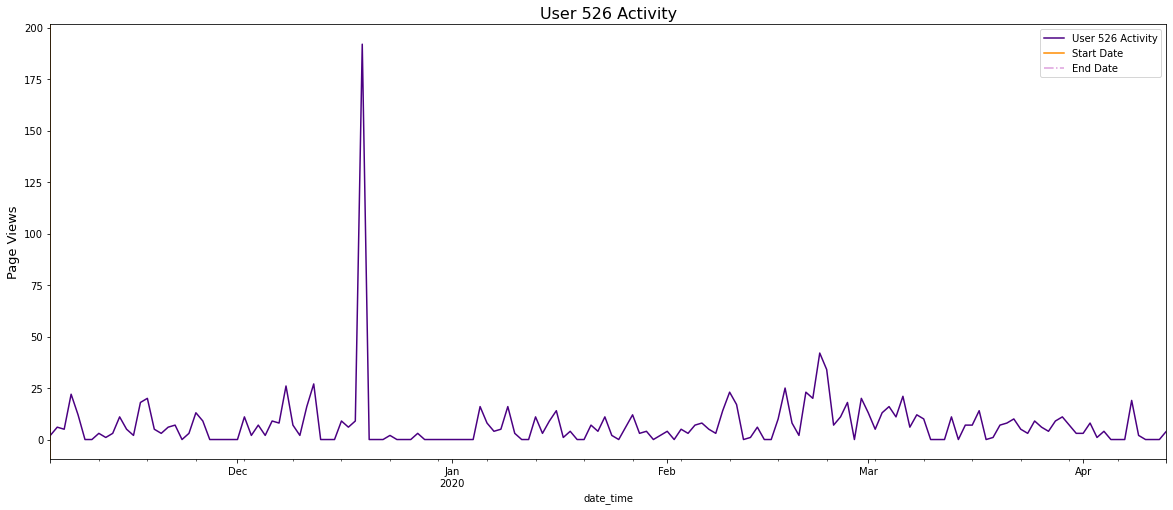

In [142]:
plot_user_activity(af, 526)

That is a spike.

user_pages         lb         mb          ub     pct_b  user_id
date_time                                                                  
2019-12-08          26  -8.077036   6.791680   21.660396  1.145931      526
2019-12-12          27  -8.791295   8.519902   25.831098  1.033761      526
2019-12-19         192 -76.186407  19.601776  115.389959  1.399893      526
2020-02-23          42 -14.870620  10.783049   36.436717  1.108431      526

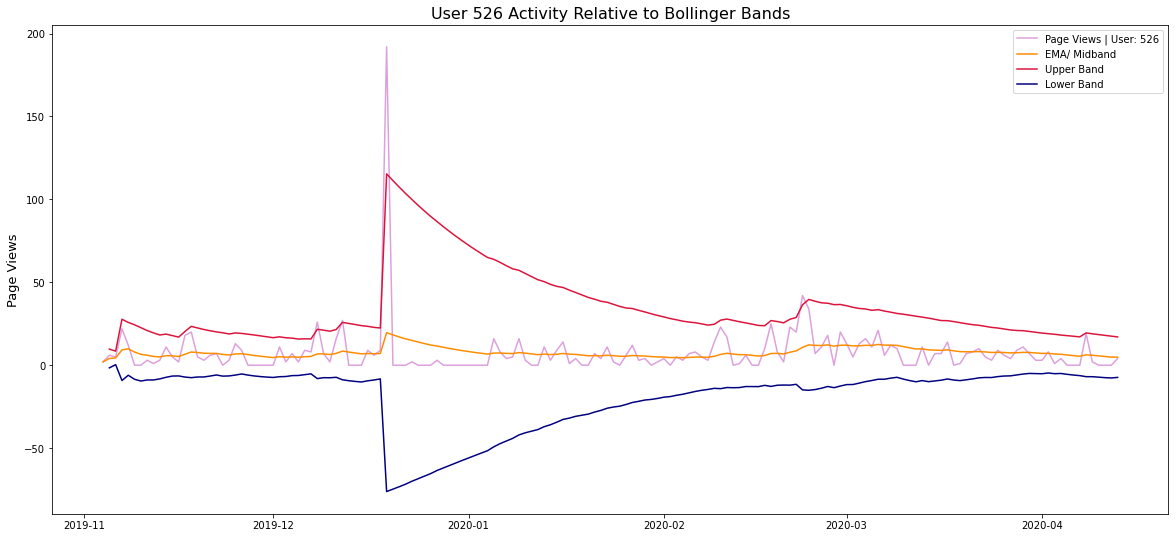

In [143]:
find_anomalies(af, 526, span, k, True)

In [144]:
heavy_users[7]

310

In [145]:
user310_info = user_details(af, 310)
user310_info

cohort          program start_date   end_date
0  Yosemite  Full-Stack Java 2018-11-05 2019-04-03

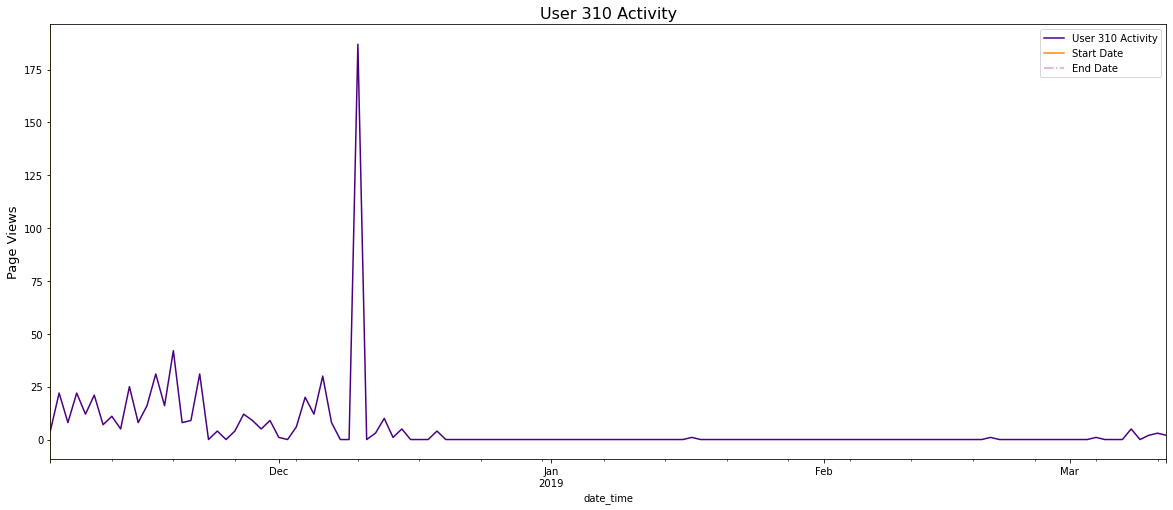

In [146]:
plot_user_activity(af, 310)

These must be web scrape spikes. This guy must've scraped the curriculum and then referenced the scraped version for nearly the rest of the program.

In [147]:
anomalies.user_id.value_counts()

64     51
53     49
1      46
11     45
186    44
       ..
378     1
543     1
402     1
610     1
951     1
Name: user_id, Length: 825, dtype: int64

Let's look at user 64, 53 and 186.

In [148]:
user64_info = user_details(af, 64)
user64_info

ValueError: arrays must all be same length

Alright, this is a staff member.

In [149]:
af[af.user_id == 64].name.unique()

array(['Arches', 'Staff', nan, 'Europa'], dtype=object)

In [150]:
af[af.user_id == 64].start_date.unique()

array(['2014-02-04T00:00:00.000000000',                           'NaT',
       '2019-11-04T00:00:00.000000000'], dtype='datetime64[ns]')

In [151]:
af[af.user_id == 64].end_date.unique()

array(['2014-04-22T00:00:00.000000000', '2014-02-04T00:00:00.000000000',
                                 'NaT', '2020-04-17T00:00:00.000000000'],
      dtype='datetime64[ns]')

Yea.

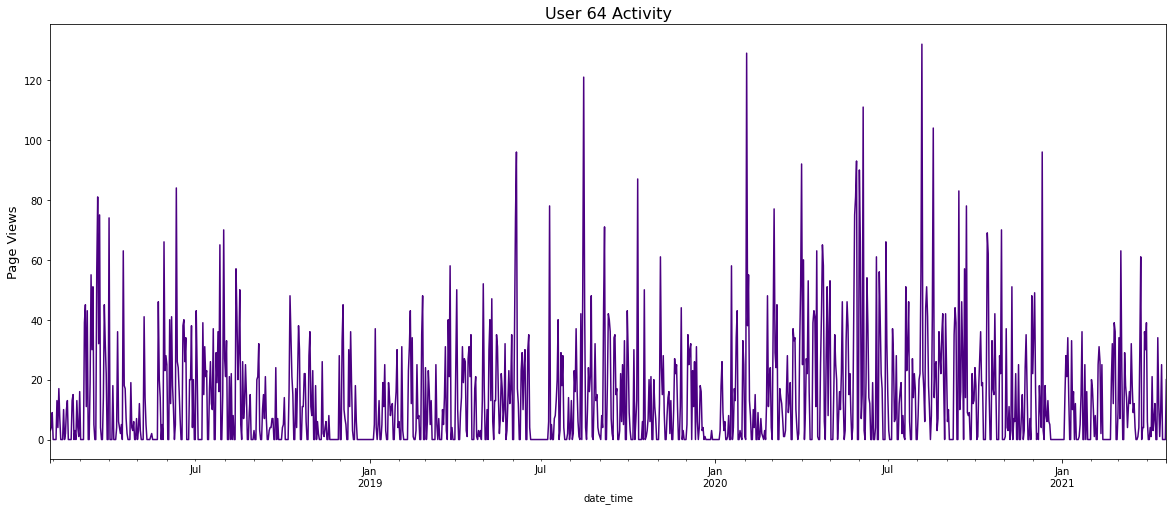

In [152]:
plot_activity(af, 64)

I guess this is typical for staff activity.

Empty DataFrame
Columns: [user_pages, lb, mb, ub, pct_b, user_id]
Index: []

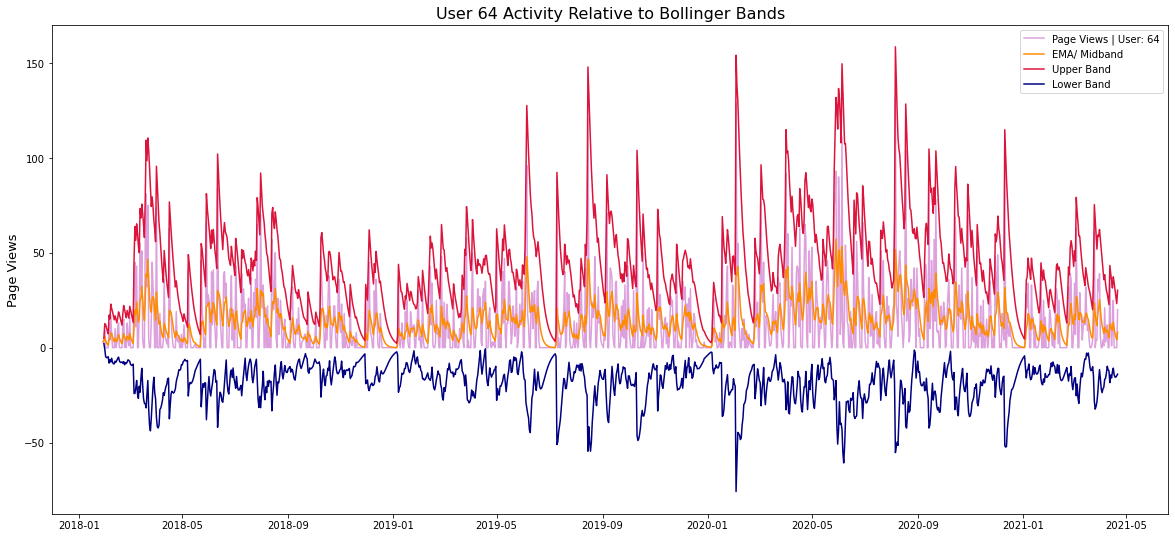

In [153]:
find_anomalies(af, 64, 7, k, True)

The 7-day exponential moving average is too strong.

In [154]:
user53_info = user_details(af, 53)
user53_info

cohort          program start_date   end_date
0  Lassen   Full-Stack PHP 2016-07-18 2016-11-10
1   Staff  Full-Stack Java 2014-02-04 2014-02-04

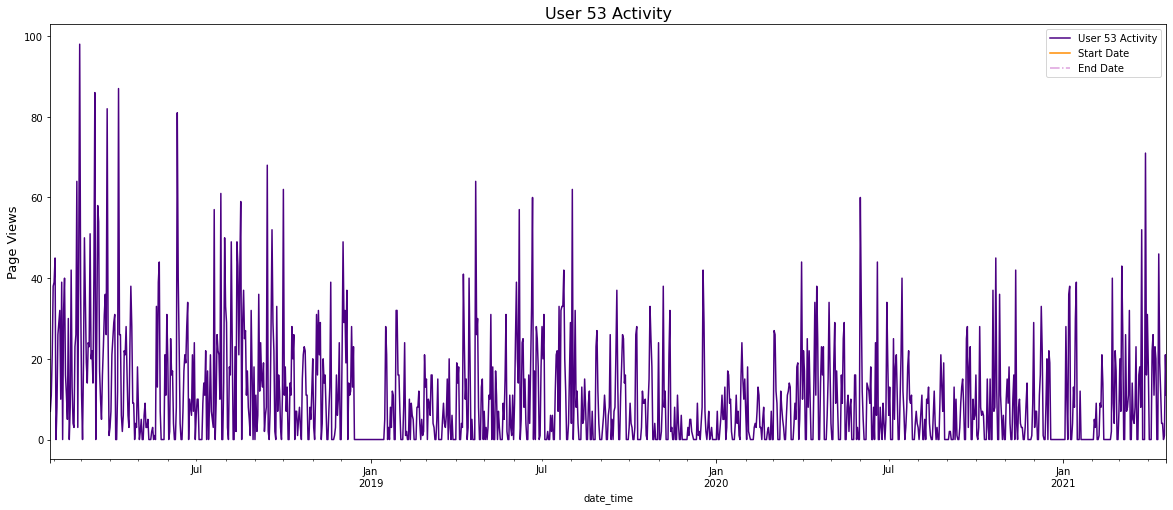

In [155]:
plot_user_activity(af, 53)

This screams, "Stafffff!!!!"

Empty DataFrame
Columns: [user_pages, lb, mb, ub, pct_b, user_id]
Index: []

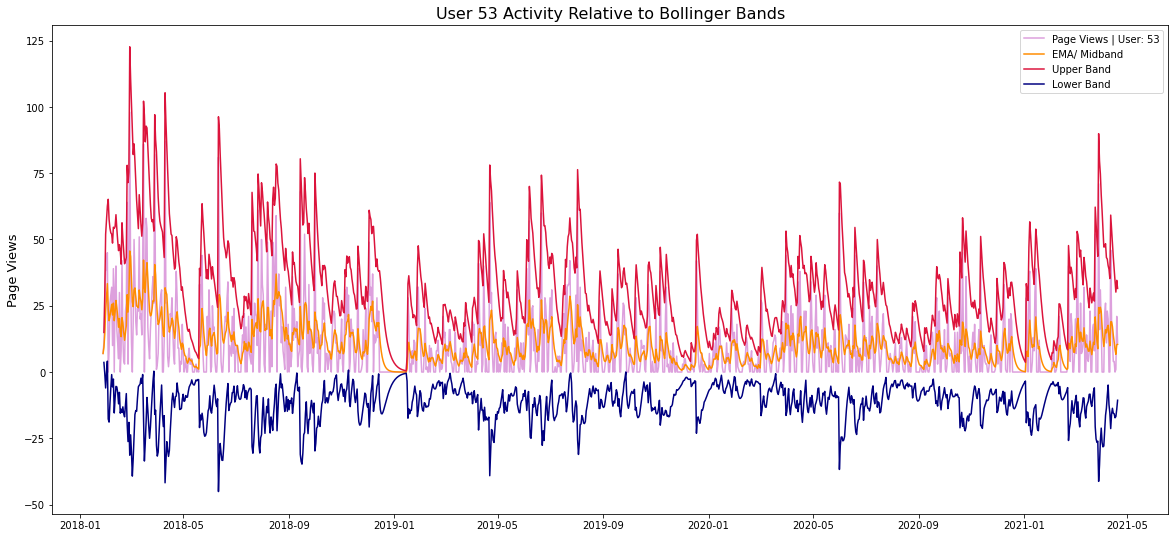

In [156]:
find_anomalies(af, 53, 7, k, True)

7-day EMA.

In [157]:
user186_info = user_details(af, 186)
user186_info

cohort          program start_date   end_date
0  Voyageurs  Full-Stack Java 2018-05-29 2018-10-11

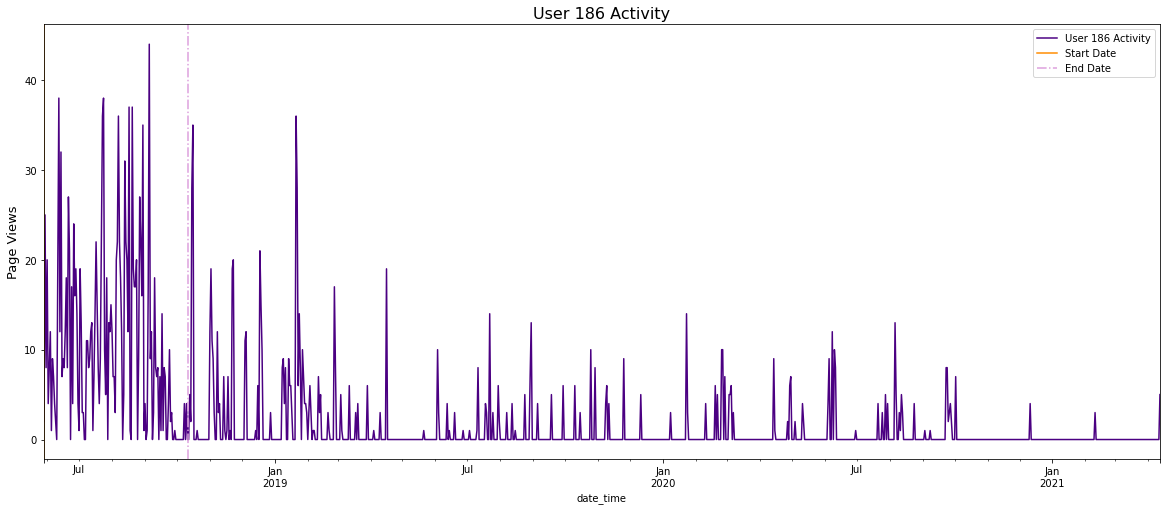

In [158]:
plot_user_activity(af, 186)

This really looks like a staff member, too. Interesting.

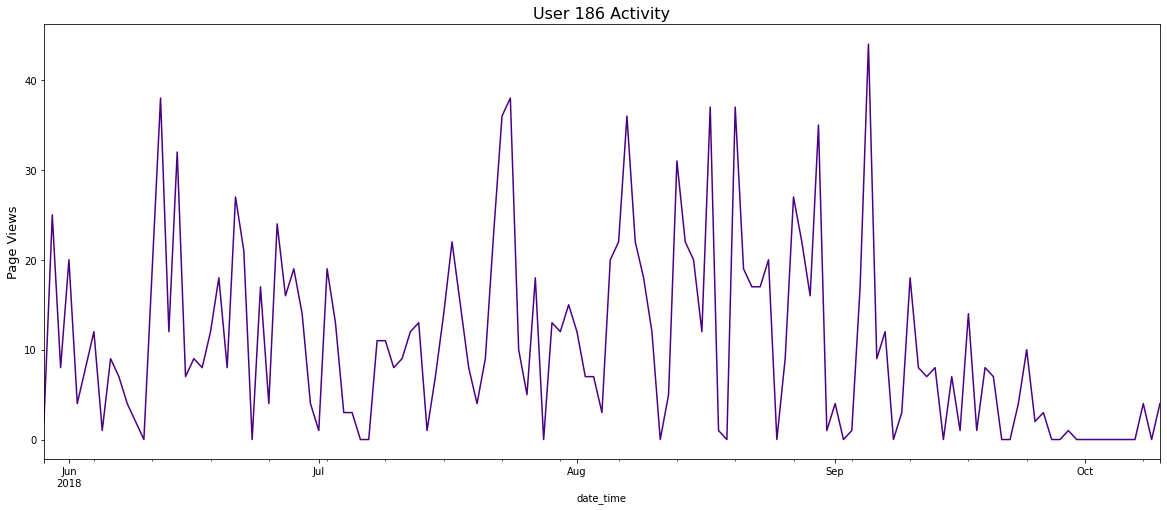

In [159]:
plot_active_user_activity(af, 186)

user_pages         lb         mb         ub     pct_b  user_id
date_time                                                                 
2018-06-12          38 -12.331272  11.236624  34.804520  1.067793      186
2018-07-23          36  -6.585330  12.645103  31.875536  1.107238      186
2018-07-24          38  -8.255735  14.318280  36.892296  1.024535      186
2018-08-07          36  -6.753354  14.248961  35.251277  1.017825      186
2018-09-05          44 -11.396398  15.802739  43.001875  1.018348      186

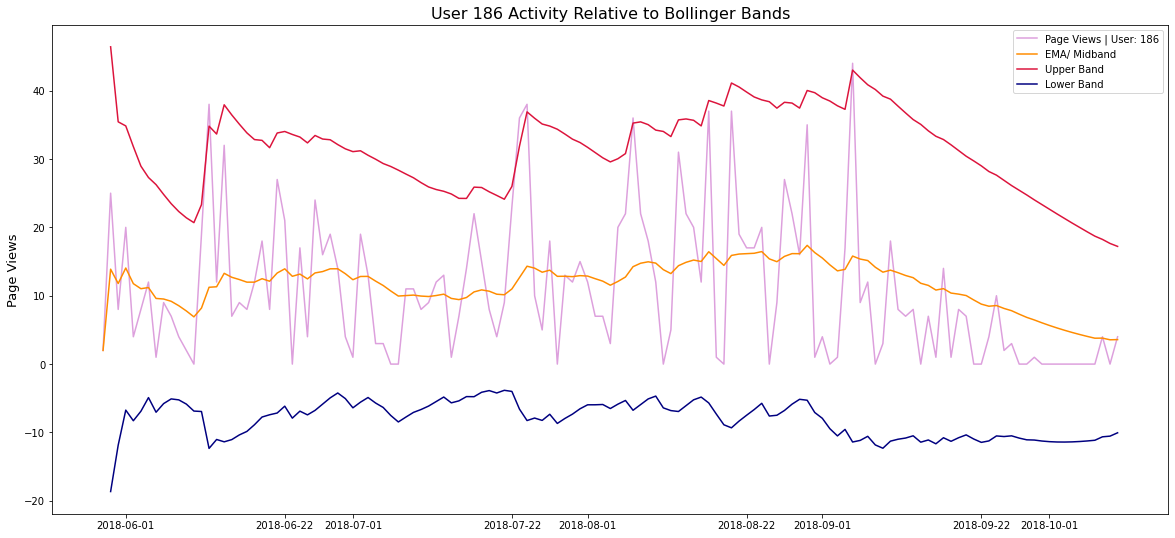

In [160]:
find_active_anomalies(af, 186, span, k, True)

No real anomalous data here. Student diligence, perhaps.

In [161]:
# pull up top 10 anomalous data users
anomalies.user_id.value_counts().nlargest(10)

64     51
53     49
1      46
11     45
186    44
315    44
41     43
211    41
248    38
146    37
Name: user_id, dtype: int64

### BONUS: Identify users who are viewing both the web dev and data science curriculum

In [167]:
# assign variables to respective program data
full_stack_php = af[af.program_id == 1.0]
full_stack_java = af[af.program_id == 2.0]
data_science = af[af.program_id == 3.0]
front_end = af[af.program_id == 4.0]

In [168]:
# look at largest values and counts for paths for users in the java program
print('Most Accessed Paths from the Full-Stack Java Program Students')
print('-------------------------------------------------------------')
print(full_stack_java.path.value_counts().nlargest(30))
print(' ')

# view largest values and counts for the paths of data science students
print('Most Accessed Logs for the Data Science Program Students')
print('--------------------------------------------------------')
data_science.path.value_counts().nlargest(30)

Most Accessed Paths from the Full-Stack Java Program Students
-------------------------------------------------------------
/                                                                            35814
javascript-i                                                                 17457
toc                                                                          17428
search/search_index.json                                                     15212
java-iii                                                                     12683
html-css                                                                     12569
java-ii                                                                      11719
spring                                                                       11376
jquery                                                                       10693
mysql                                                                        10318
java-i                                        

/                                                                8358
search/search_index.json                                         2203
classification/overview                                          1785
1-fundamentals/modern-data-scientist.jpg                         1655
1-fundamentals/AI-ML-DL-timeline.jpg                             1651
1-fundamentals/1.1-intro-to-data-science                         1633
classification/scale_features_or_not.svg                         1590
fundamentals/AI-ML-DL-timeline.jpg                               1443
fundamentals/modern-data-scientist.jpg                           1438
sql/mysql-overview                                               1424
fundamentals/intro-to-data-science                               1413
6-regression/1-overview                                          1124
anomaly-detection/AnomalyDetectionCartoon.jpeg                    829
anomaly-detection/overview                                        804
10-anomaly-detection

In [169]:
# look at records where users in java program viewed regression material in the curriculum
cross_activity = full_stack_java[(full_stack_java.path.str.contains('regression') == True) & (full_stack_java.name != 'Staff')]
cross_activity

path  user_id  cohort_id  \
date_time                                                                    
2019-07-11 16:34:16            5-regression/1-overview      344       29.0   
2019-08-02 09:14:21            6-regression/1-overview       18       22.0   
2019-08-23 11:46:24            6-regression/1-overview      410       32.0   
2019-09-01 00:03:01            6-regression/1-overview       18       22.0   
2019-09-01 00:03:04    6-regression/2-regression-excel       18       22.0   
2019-10-02 16:31:58            6-regression/1-overview       41       21.0   
2019-10-02 16:32:04           6-regression/3.3-explore       41       21.0   
2019-10-02 16:32:05  6-regression/3.1-acquire-and-prep       41       21.0   
2019-10-08 11:43:03            6-regression/1-overview      458       33.0   
2019-12-22 19:44:50            6-regression/1-overview       18       22.0   
2020-01-13 15:00:45            6-regression/1-overview      410       32.0   

                                ip        name start_date   end_date  \
date_time                                                              
2019-07-11 16:34:16   70.122.40.62        Zion 2019-01-22 2019-06-04   
2019-08-02 09:14:21  45.20.117.182       Teddy 2018-01-08 2018-05-17   
2019-08-23 11:46:24   97.105.19.58  Betelgeuse 2019-05-28 2019-10-08   
2019-09-01 00:03:01  45.20.117.182       Teddy 2018-01-08 2018-05-17   
2019-09-01 00:03:04  45.20.117.182       Teddy 2018-01-08 2018-05-17   
2019-10-02 16:31:58   97.105.19.58     Sequoia 2017-09-27 2018-02-15   
2019-10-02 16:32:04   97.105.19.58     Sequoia 2017-09-27 2018-02-15   
2019-10-02 16:32:05   97.105.19.58     Sequoia 2017-09-27 2018-02-15   
2019-10-08 11:43:03   97.105.19.58       Ceres 2019-07-15 2019-12-11   
2019-12-22 19:44:50  45.20.117.182       Teddy 2018-01-08 2018-05-17   
2020-01-13 15:00:45   172.58.107.0  Betelgeuse 2019-05-28 2019-10-08   

                             created_at          updated_at  program_id  \
date_time                                                                 
2019-07-11 16:34:16 2019-01-20 23:18:57 2019-01-20 23:18:57         2.0   
2019-08-02 09:14:21 2018-01-08 13:59:10 2018-01-08 13:59:10         2.0   
2019-08-23 11:46:24 2019-05-28 18:41:05 2019-05-28 18:41:05         2.0   
2019-09-01 00:03:01 2018-01-08 13:59:10 2018-01-08 13:59:10         2.0   
2019-09-01 00:03:04 2018-01-08 13:59:10 2018-01-08 13:59:10         2.0   
2019-10-02 16:31:58 2017-09-27 20:22:41 2017-09-27 20:22:41         2.0   
2019-10-02 16:32:04 2017-09-27 20:22:41 2017-09-27 20:22:41         2.0   
2019-10-02 16:32:05 2017-09-27 20:22:41 2017-09-27 20:22:41         2.0   
2019-10-08 11:43:03 2019-07-15 16:57:21 2019-07-15 16:57:21         2.0   
2019-12-22 19:44:50 2018-01-08 13:59:10 2018-01-08 13:59:10         2.0   
2020-01-13 15:00:45 2019-05-28 18:41:05 2019-05-28 18:41:05         2.0   

                     front_end  data_science  java  php          program  \
date_time                                                                  
2019-07-11 16:34:16          0             0     1    0  Full-Stack Java   
2019-08-02 09:14:21          0             0     1    0  Full-Stack Java   
2019-08-23 11:46:24          0             0     1    0  Full-Stack Java   
2019-09-01 00:03:01          0             0     1    0  Full-Stack Java   
2019-09-01 00:03:04          0             0     1    0  Full-Stack Java   
2019-10-02 16:31:58          0             0     1    0  Full-Stack Java   
2019-10-02 16:32:04          0             0     1    0  Full-Stack Java   
2019-10-02 16:32:05          0             0     1    0  Full-Stack Java   
2019-10-08 11:43:03          0             0     1    0  Full-Stack Java   
2019-12-22 19:44:50          0             0     1    0  Full-Stack Java   
2020-01-13 15:00:45          0             0     1    0  Full-Stack Java   

                     staff  
date_time                   
2019-07-11 16:34:16  False  
2019-08-02 09:14:21  False  
2019-08-23 11:46:

In [170]:
# view records where data science students had a path that contains 'java'
cross_active = data_science[(data_science.path.str.contains('java') == True) & (data_science.name != 'Staff')]
cross_active

path  user_id  cohort_id  \
date_time                                                                      
2019-09-23 11:45:09                             java-iii      476       34.0   
2019-09-25 19:30:44                         javascript-i      476       34.0   
2019-09-25 19:31:07                         javascript-i      476       34.0   
2019-09-25 19:31:11                               java-i      476       34.0   
2019-09-25 19:31:12                         javascript-i      476       34.0   
2019-09-25 19:31:14                               java-i      476       34.0   
2019-09-25 19:31:19                              java-ii      476       34.0   
2019-09-25 19:32:23                         javascript-i      476       34.0   
2019-09-25 19:32:34                               java-i      476       34.0   
2019-09-25 19:32:38                               java-i      476       34.0   
2019-09-25 19:32:44                    java-i/console-io      476       34.0   
2019-11-25 14:26:14                         javascript-i      476       34.0   
2019-11-25 14:26:16                        javascript-ii      476       34.0   
2019-11-25 14:26:17                               java-i      476       34.0   
2019-11-25 14:26:18                              java-ii      476       34.0   
2019-11-25 14:26:20                             java-iii      476       34.0   
2019-11-25 14:26:24                             java-iii      476       34.0   
2019-11-26 10:31:16         javascript-i/bom-and-dom/dom      467       34.0   
2019-11-26 10:37:35                         javascript-i      476       34.0   
2019-11-26 10:37:39                        javascript-ii      476       34.0   
2019-11-26 10:38:06                               java-i      476       34.0   
2019-11-26 10:55:05                         javascript-i      476       34.0   
2019-11-26 15:32:05            javascript-i/conditionals      472       34.0   
2019-12-03 10:04:40                         javascript-i      467       34.0   
2019-12-03 10:04:48                        javascript-ii      467       34.0   
2019-12-03 10:04:48                               java-i      467       34.0   
2019-12-03 10:04:49                              java-ii      467       34.0   
2019-12-03 10:05:25                             java-iii      467       34.0   
2019-12-03 11:49:29                         javascript-i      467       34.0   
2019-12-03 11:49:33                        javascript-ii      467       34.0   
2019-12-03 11:49:35                              java-ii      467       34.0   
2019-12-14 16:46:24                         javascript-i      476       34.0   
2020-05-19 16:03:32  java-ii/object-oriented-programming      590       55.0   

                                ip   name start_date   end_date  \
date_time                                                         
2019-09-23 11:45:09   97.105.19.58  Bayes 2019-08-19 2020-01-30   
2019-09-25 19:30:44  136.50.49.145  Bayes 2019-08-19 2020-01-30   
2019-09-25 19:31:07  136.50.49.145  Bayes 2019-08-19 2020-01-30   
2019-09-25 19:31:11  136.50.49.145  Bayes 2019-08-19 2020-01-30   
2019-09-25 19:31:12  136.50.49.145  Bayes 2019-08-19 2020-01-30   
2019-09-25 19:31:14  136.50.49.145  Bayes 2019-08-19 2020-01-30   
2019-09-25 19:31:19  136.50.49.145  Bayes 2019-08-19 2020-01-30   
2019-09-25 19:32:23  136.50.49.145  Bayes 2019-08-19 2020-01-30   
2019-09-25 19:32:34  136.50.49.145  Bayes 2019-08-19 2020-01-30   
2019-09-25 19:32:38  136.50.49.145  Bayes 2019-08-19 2020-01-30   
2019-09-25 19:32:44  136.50.49.145  Bayes 2019-08-19 2020-01-30   
2019-11-25 14:26:14   97.105.19.58  Bayes 2019-08-19 2020-01-30   
2019-11-25 14:26:16   97.105.19.58  Bayes 2019-08-19 2020-01-30   
2019-11-25 14:26:17   97.105.19.58  Bayes 2019-08-19 2020-01-30   
2019-11-25 14:26:18   97.105.19.58  Bayes 2019-08-19 2020-01-30   
2019-11-25 14:26:20   97.105.19.58  Bayes 2019-08-19 2020-01-30   
2019-11-25 14:26:24   97.105.19.58  Bayes 201

In [171]:
# assign variable to records where users in java program viewed pandas material in the curriculum
cross_activity2 = full_stack_java[(full_stack_java.path.str.contains('pandas') == True) & (full_stack_java.name != 'Staff')]

# assign variable to records where users in java program viewed python material in the curriculum
cross_activity3 = full_stack_java[(full_stack_java.path.str.contains('python') == True) & (full_stack_java.name != 'Staff')]

# assign variable to records where users in java program viewed statistics material in the curriculum
cross_activity4 = full_stack_java[(full_stack_java.path.str.contains('stats') == True) & (full_stack_java.name != 'Staff')]

# assign variable to records where users in java program viewed anomaly material in the curriculum
cross_activity5 = full_stack_java[(full_stack_java.path.str.contains('anomaly') == True) & (full_stack_java.name != 'Staff')]

# assign variable to records where users in java program viewed classification material in the curriculum
cross_activity6 = full_stack_java[(full_stack_java.path.str.contains('classification') == True) & (full_stack_java.name != 'Staff')]

# assign variable to records where users in java program viewed data-science paths in the curriculum
cross_activity7 = full_stack_java[(full_stack_java.path.str.contains('data-sci') == True) & (full_stack_java.name != 'Staff')]

# assign variable to records where datascience students had a path that contains 'html'
cross_active2 = data_science[(data_science.path.str.contains('html') == True) & (data_science.name != 'Staff')]

# assign variable to records where datascience students had a path that contains 'spring'
cross_active3 = data_science[(data_science.path.str.contains('spring') == True) & (data_science.name != 'Staff')]

# assign variable to records where datascience students had a path that contains 'jquery'
cross_active4 = data_science[(data_science.path.str.contains('jquery') == True) & (data_science.name != 'Staff')]

### I am assuming these users are accessing their own curriculum as well (they view both the web dev and data science curriculum).

In [172]:
# set empty list
divergents = []

# add user ids from resourceful users
divergents.append(cross_active.user_id.unique())
divergents.append(cross_active2.user_id.unique())
divergents.append(cross_active3.user_id.unique())
divergents.append(cross_active4.user_id.unique())
divergents.append(cross_activity.user_id.unique())
divergents.append(cross_activity2.user_id.unique())
divergents.append(cross_activity3.user_id.unique())
divergents.append(cross_activity4.user_id.unique())
divergents.append(cross_activity5.user_id.unique())
divergents.append(cross_activity6.user_id.unique())
divergents.append(cross_activity7.user_id.unique())

# view list
divergents

[array([476, 467, 472, 590]),
 array([484, 475, 476, 467, 472, 477, 474, 471, 485, 480, 479, 482, 473,
        481, 469, 468, 470, 478, 466, 483, 579, 585, 582, 616, 581, 590,
        617, 583, 586, 578, 575, 588, 584, 678, 687, 268, 688, 699, 694,
        698, 781, 785, 692, 691, 783, 690, 895, 847, 904, 906, 907, 909,
        914, 902, 911, 949, 905, 900, 840]),
 array([476, 481, 472, 467, 581]),
 array([476, 467]),
 array([344,  18, 410,  41, 458]),
 array([223, 187,  18, 186, 420]),
 array([450, 414, 420, 423, 249, 433, 451, 458,  18, 410, 627, 929]),
 array([186, 344,  18, 420, 450, 508]),
 array([ 18, 410, 489]),
 array([373,  20]),
 array([220, 410, 423,  41,  18, 450, 373, 417, 138, 201, 249, 433, 451,
        124, 458, 171,  20, 495, 143])]

In [173]:
# determine length of list of lists
len(divergents)

11

In [174]:
# assign first list to set
set0 = set(divergents[0])

# loop through lists in divergents to combine sets and drop duplicates
for x in range(1, len(divergents)):
    set0 = set0.union(set(divergents[x]))
    
# convert final set into list and sort
divergents = list(set0)
divergents.sort()

# view some user ids that view popular material from another curriculum
print(f'Users who access both curriculums are listed as so\n\
--------------------------------------------------\n   {divergents}')

Users who access both curriculums are listed as so
--------------------------------------------------
   [18, 20, 41, 124, 138, 143, 171, 186, 187, 201, 220, 223, 249, 268, 344, 373, 410, 414, 417, 420, 423, 433, 450, 451, 458, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 489, 495, 508, 575, 578, 579, 581, 582, 583, 584, 585, 586, 588, 590, 616, 617, 627, 678, 687, 688, 690, 691, 692, 694, 698, 699, 781, 783, 785, 840, 847, 895, 900, 902, 904, 905, 906, 907, 909, 911, 914, 929, 949]


In [175]:
# count number of divergents found 
len(divergents)

88

In [176]:
## create a set for each list in the list
#set1 = set(divergents[0])
#set2 = set(divergents[1])
#set3 = set(divergents[2])
#set4 = set(divergents[3])
#set5 = set(divergents[4])
#set6 = set(divergents[5])
#set7 = set(divergents[6])
#set8 = set(divergents[7])
#set9 = set(divergents[8])
#set10 = set(divergents[9])
#set11 = set(divergents[10])

## combine sets (remove duplicates)
#divergents = set1.union(set2.\
#union(set3.\
#union(set4.\
#union(set5.\
#union(set6.\
#union(set7.\
#union(set8.\
#union(set9.\
#union(set10.\
#union(set11)))))))))
#                       )

And for giggles: plot activity

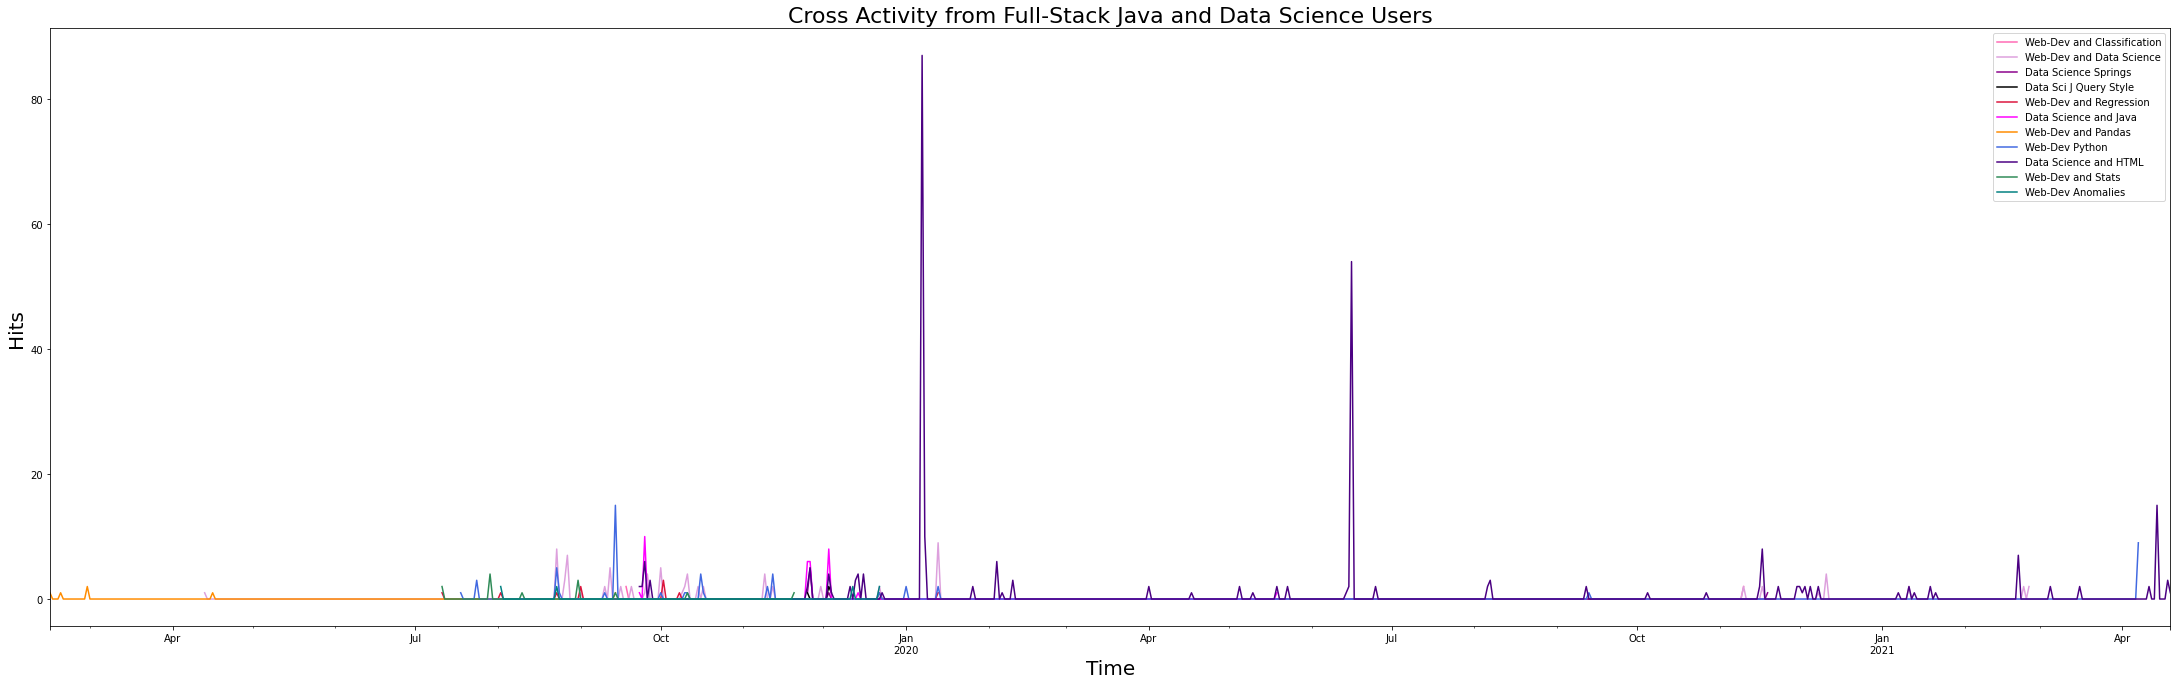

In [177]:
plt.figure(figsize = (38, 11))    # create figure for plots

plt.title('Cross Activity from Full-Stack Java and Data Science Users', size = 22)    # title

## RESAMPLE ##

java_regression = cross_activity.path.resample('D').count()    # resample web dev users looking up regression

ds_java = cross_active.path.resample('D').count()    # resample data science users looking up java 

java_pandas = cross_activity2.path.resample('D').count()    # resample web dev users looking up pandas

java_python = cross_activity3.path.resample('D').count()    # resample web dev users looking up python

ds_html = cross_active2.path.resample('D').count()    # resample data science users looking up html

java_stats = cross_activity4.path.resample('D').count()    # resample web dev users looking up stats

jawa_anomaly = cross_activity5.path.resample('D').count()    # resample web dev users looking up anomaly material

cross_act6 = cross_activity6.path.resample('D').count()    # resample web dev and classification logs 

cross_act7 = cross_activity7.path.resample('D').count()    # resample web dev and classification logs

cross_act3 = cross_active3.path.resample('D').count()    # resample data science research into spring

cross_act4 = cross_active4.path.resample('D').count()    # resample data science research into jquery

## PLOT ## 

cross_act6.plot(color = 'hotpink', label = 'Web-Dev and Classification')    # plot web dev and classification logs

cross_act7.plot(color = 'plum', label = 'Web-Dev and Data Science')     # plot web dev data science paths

cross_act3.plot(color = 'darkmagenta', label = 'Data Science Springs')    # plot data science research into spring

cross_act4.plot(color = 'black', label = 'Data Sci J Query Style')    # plot data science research into jquery

java_regression.plot(color = 'crimson', label = 'Web-Dev and Regression')   # plot web dev user activity in regards to regression

ds_java.plot(color = 'magenta', label =  'Data Science and Java')    # plot data science user activity in regards to java

java_pandas.plot(color = 'darkorange', label = 'Web-Dev and Pandas')    # plot web dev users looking up pandas

java_python.plot(color = 'royalblue', label = 'Web-Dev Python')    # plot we dev users looking up python

ds_html.plot(color = 'indigo', label = 'Data Science and HTML')    # plot data science users looking up html

java_stats.plot(color = 'seagreen', label = 'Web-Dev and Stats')    # plot web dev users researching stats

jawa_anomaly.plot(color = 'teal', label = 'Web-Dev Anomalies')    # plot web dev users looking up anomaly material

plt.legend(loc = 'best')    # include legend

plt.ylabel('Hits', size = 20)    # label y-axis

plt.xlabel('Time', size = 20);    # label x-axis